---
# DATA PREPARATION
---

## Setup

In [1]:
%reset-f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14

## Load Toronto Shelter Data

### Load files, concatenate, add date index to create DataFrame: **shelter_use**

In [3]:
# Load files from GitHub; add year labels
path = 'https://raw.githubusercontent.com/VernonNaidoo-Toronto/Understanding-Toronto-Shelters/master/Shelter%20Data/'
dso2017 = pd.read_csv(path + 'daily-shelter-occupancy-2017-csv.csv', 
                    parse_dates=['OCCUPANCY_DATE']); dso2017['source_file']=2017
dso2018 = pd.read_csv(path + 'daily-shelter-occupancy-2018-csv.csv',
                    parse_dates=['OCCUPANCY_DATE']); dso2018['source_file']=2018
dso2019 = pd.read_csv(path + 'daily-shelter-occupancy-2019-csv.csv',
                    parse_dates=['OCCUPANCY_DATE']); dso2019['source_file']=2019

# Get summary of records loaded
for year, df in [[2017,dso2017], [2018,dso2018], [2019,dso2019]]:
  print(f'Loaded {df.shape[0]} records and {df.shape[1]} columns from the {year} file.')

Loaded 38700 records and 14 columns from the 2017 file.
Loaded 37770 records and 14 columns from the 2018 file.
Loaded 39446 records and 14 columns from the 2019 file.


In [4]:
# Concatenate DataFrames
shelter_use = pd.concat([dso2017, dso2018, dso2019], ignore_index=True) 

# Get list of column names; change to Python standard lowercase:
cols = [column_name.lower() for column_name in shelter_use.columns] 
shelter_use.columns = cols

# Move source_file column to front of DataFrame
cols = cols[-1:] + cols[0:-1]
shelter_use = shelter_use[cols]

#Move occupancy_date column to index
shelter_use['Date']=shelter_use.occupancy_date
shelter_use.set_index('Date', inplace=True)

# Show sample records
print('Shape:',shelter_use.shape)
display(shelter_use.sample(5))

Shape: (115916, 14)


source_file    _id occupancy_date  ... sector occupancy capacity
Date                                           ...                          
2019-10-01         2019  29324     2019-10-01  ...  Co-ed        16     16.0
2019-04-18         2019  11506     2019-04-18  ...  Women         6      6.0
2019-08-10         2019  23783     2019-08-10  ...  Co-ed        38     40.0
2018-01-04         2018    352     2018-01-04  ...    Men        28     28.0
2017-10-14         2017  30592     2017-10-14  ...  Co-ed        81     83.0

[5 rows x 14 columns]

## Data Preparation

### Drop Nulls; Fix Data Types

- The shelter_postal_code column has 5494 missing values.
- The capacity column has 343 missing values.
  - 11 of those (null capacity) rows have occupancy values, which total 43 - all in 2017
  - All 343 rows were dropped.

In [5]:
# Identify columns with missing values:
for col in shelter_use.columns:
  null_count = shelter_use[col].isna().sum()
  if null_count >0:
    print(f'The {col} column has {null_count} rows without values.')

The shelter_postal_code column has 5494 rows without values.
The capacity column has 343 rows without values.


In [6]:
# Drop 343 rows with null capacity
original_row_count=shelter_use.shape[0]
shelter_use.dropna(subset=['capacity'], inplace=True)
dropped_row_count=original_row_count-shelter_use.shape[0]
print(f'Dropped {dropped_row_count} of {original_row_count} rows, due to nulls in capacity column.')

Dropped 343 of 115916 rows, due to nulls in capacity column.


In [7]:
# After removing nulls, change capacity column to integer
shelter_use.capacity = shelter_use.capacity.astype(int)

### Add New Columns (vacancy, vacancy_rate)

In [8]:
shelter_use['vacancy']=shelter_use.capacity - shelter_use.occupancy

## EXPLORE FAMILY ISSUE!

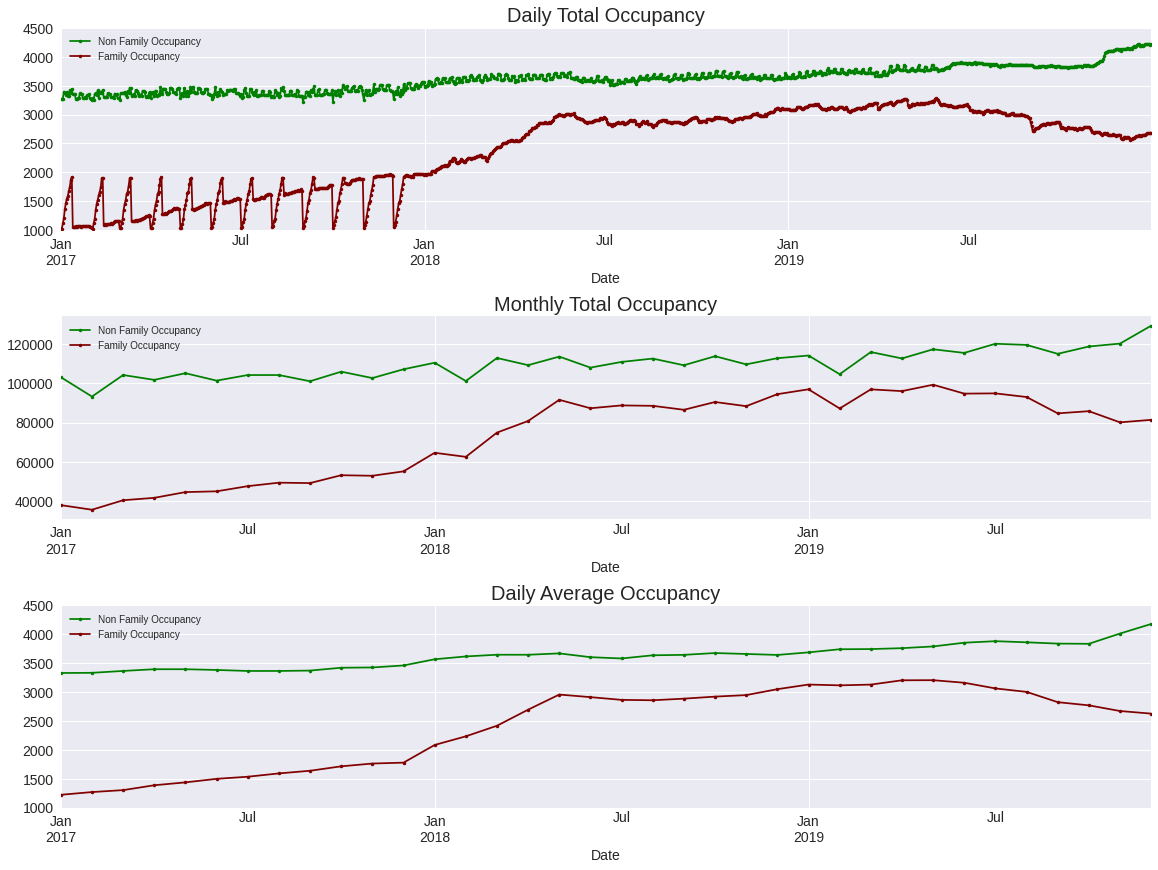

In [9]:
fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=2)

df = shelter_use[shelter_use.sector!='Families']
df = df.resample('D')[['occupancy']].sum().rename(columns={'occupancy':'Non Family Occupancy'})
df.plot(marker='.', ax=ax1, ylim=(1000,4500), color='green');

df = shelter_use[shelter_use.sector=='Families']
df = df.resample('D')[['occupancy']].sum().rename(columns={'occupancy':'Family Occupancy'})
df.plot(title='Daily Total Occupancy', marker='.', ax=ax1, color='maroon')
#---
df = shelter_use[shelter_use.sector!='Families']
df = df.resample('D')[['occupancy']].sum()
df = df.resample('M')[['occupancy']].sum().rename(columns={'occupancy':'Non Family Occupancy'})
df.plot(marker='.', ax=ax3, color='green')

df = shelter_use[shelter_use.sector=='Families']
df = df.resample('D')[['occupancy']].sum()
df = df.resample('M')[['occupancy']].sum().rename(columns={'occupancy':'Family Occupancy'})
df.plot(title='Monthly Total Occupancy', marker='.', ax=ax3, color='maroon')
#---
df = shelter_use[shelter_use.sector!='Families']
df = df.resample('D')[['occupancy']].sum()
df = df.resample('M')[['occupancy']].mean().rename(columns={'occupancy':'Non Family Occupancy'})
df.plot(marker='.', ax=ax5, ylim=(1000,4500), color='green');

df = shelter_use[shelter_use.sector=='Families']
df = df.resample('D')[['occupancy']].sum()
df = df.resample('M')[['occupancy']].mean().rename(columns={'occupancy':'Family Occupancy'})
df.plot(title='Daily Average Occupancy', marker='.', ax=ax5, color='maroon')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0);

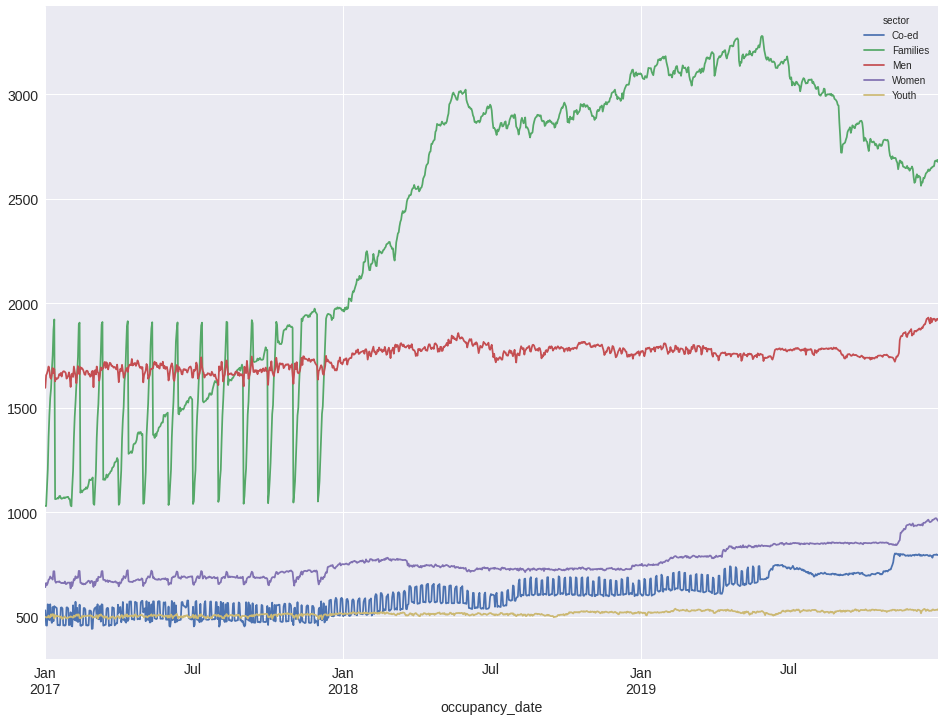

In [10]:
shelter_use.pivot_table(
    index=['occupancy_date'], 
    columns=['sector'],
    values='occupancy',
    aggfunc='sum').plot(figsize=(16, 12));plt.show();

## Export CSV Files for Further Analysis


Output Files:
- **shelter_use.csv**
  - original format with data prep
- **shelter_use_totals__daily.csv**
  - columns: capacity,	occupancy,	vacancy
  - one row per day (1095 rows)
- **shelter_use_totals_without_families__daily.csv**
  - data for 'Families' sector removed
- **shelter_use_totals_by_sector__daily.csv**
  - multi-level column index
  - one section of columns for capacity,	occupancy,	vacancy
    - one column (in each section) per sector

### Save File: **shelter_use.csv** 
### (original format with data prep)

In [11]:
#Save as csv:
filename_with_path = 'shelter_use.csv'
shelter_use.to_csv(filename_with_path)

#### Test csv: **shelter_use_totals__daily.csv**

In [12]:
#Test:
test = pd.read_csv(filename_with_path)
test.set_index(['Date']).head(3)

source_file  _id occupancy_date  ... occupancy capacity vacancy
Date                                         ...                           
2017-01-01         2017    1     2017-01-01  ...        16       16       0
2017-01-01         2017    2     2017-01-01  ...        13       17       4
2017-01-01         2017    3     2017-01-01  ...        63       63       0

[3 rows x 15 columns]

### Save File: **shelter_use_totals__daily.csv**
### (Pivot DataFrame to one row per day)

capacity  occupancy  vacancy
Date                                    
2017-01-01      4653       4295      358
2017-01-02      4704       4299      405
2017-01-03      4733       4386      347
2017-01-04      4938       4600      338
2017-01-05      5011       4729      282

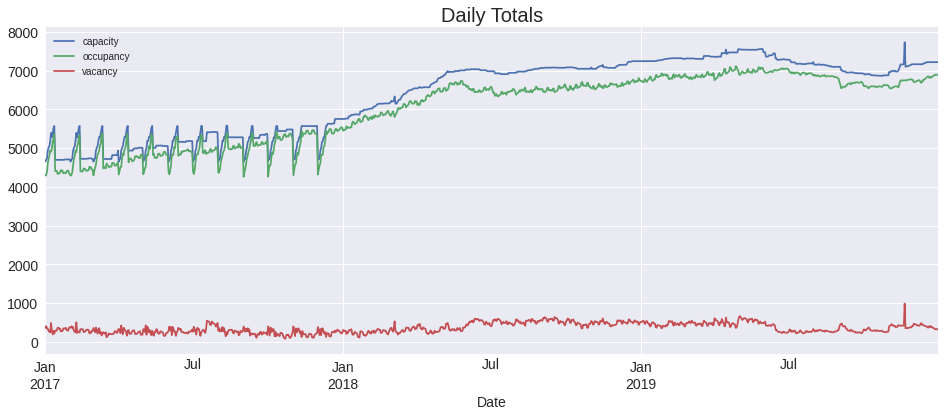

In [13]:
# Create monthly totals DataFrame:
shelter_use_totals_D = shelter_use.reset_index().pivot_table(values=['occupancy','capacity','vacancy'],aggfunc='sum',index='Date')
display(shelter_use_totals_D.head())
shelter_use_totals_D.plot(title='Daily Totals');

#Save as csv:
filename_with_path = 'shelter_use_totals__daily.csv'
shelter_use_totals_D.to_csv(filename_with_path)

#### Test csv: **shelter_use_totals__daily.csv**

In [14]:
#Test:
test = pd.read_csv(filename_with_path)
test

Date  capacity  occupancy  vacancy
0     2017-01-01      4653       4295      358
1     2017-01-02      4704       4299      405
2     2017-01-03      4733       4386      347
3     2017-01-04      4938       4600      338
4     2017-01-05      5011       4729      282
...          ...       ...        ...      ...
1090  2019-12-27      7222       6899      323
1091  2019-12-28      7222       6895      327
1092  2019-12-29      7222       6904      318
1093  2019-12-30      7223       6896      327
1094  2019-12-31      7223       6890      333

[1095 rows x 4 columns]

### Save File: **shelter_use_totals_without_families__daily.csv**
###(Pivot to One Row Per Day; Remove Family Sector)

capacity  occupancy  vacancy
Date                                    
2017-01-01      3503       3265      238
2017-01-02      3548       3270      278
2017-01-03      3577       3268      309
2017-01-04      3607       3396      211
2017-01-05      3629       3367      262

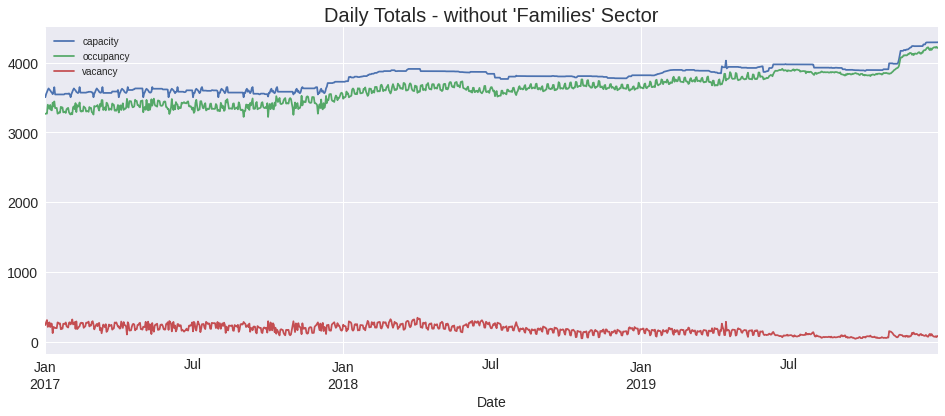

In [15]:
# Create monthly totals DataFrame:
shelter_use_totals_without_families_D = \
  shelter_use[shelter_use.sector!='Families'].reset_index().pivot_table(values=['occupancy','capacity','vacancy'],aggfunc='sum',index='Date')
display(shelter_use_totals_without_families_D.head())
shelter_use_totals_without_families_D.plot(title='Daily Totals - without \'Families\' Sector');

#Save as csv:
filename_with_path = 'shelter_use_totals_without_families__daily.csv'
shelter_use_totals_without_families_D.to_csv(filename_with_path)

### Save File: **shelter_use_totals_by_sector__daily.csv**
### (Pivot to one row *per sector* per day)

capacity                       ...  vacancy                 
sector        Co-ed Families   Men Women  ... Families  Men Women Youth
Date                                      ...                          
2017-01-01      582     1150  1706   697  ...      120  111    56    19
2017-01-02      582     1156  1751   697  ...      127   96    36    22
2017-01-03      582     1156  1780   697  ...       38  116    46    22
2017-01-04      612     1331  1792   685  ...      127  114    24    20
2017-01-05      622     1382  1792   697  ...       20   95    20    13

[5 rows x 15 columns]

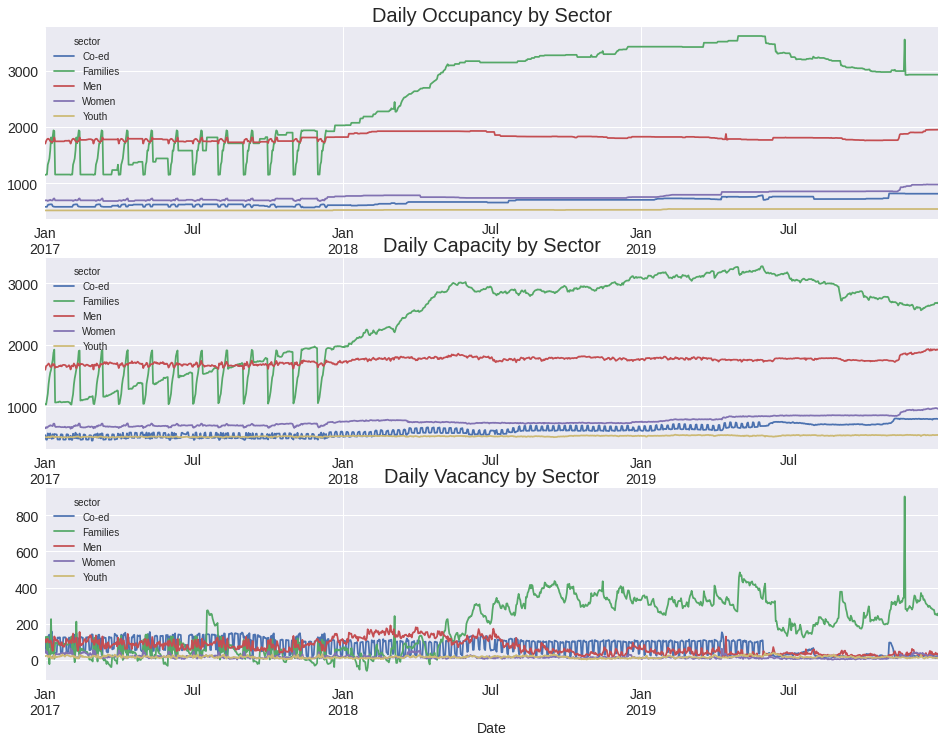

In [16]:
# Create monthly totals by sector DataFrame:
shelter_use_by_sector_D = shelter_use.reset_index().pivot_table(values=['occupancy','capacity','vacancy'],aggfunc='sum',columns='sector',index='Date')
display(shelter_use_by_sector_D.head())

fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((3, 1), (0, 0))
ax2 = plt.subplot2grid((3, 1), (1, 0))
ax3 = plt.subplot2grid((3, 1), (2, 0))
shelter_use_by_sector_D.capacity.plot(title='Daily Occupancy by Sector', ax=ax1);
shelter_use_by_sector_D.occupancy.plot(title='Daily Capacity by Sector', ax=ax2);
shelter_use_by_sector_D.vacancy.plot(title='Daily Vacancy by Sector', ax=ax3);

#Save:
filename_with_path = 'shelter_use_totals_by_sector__daily.csv'
shelter_use_by_sector_D.to_csv(filename_with_path)

#### Test csv: **shelter_use_totals_by_sector__daily.csv**

In [17]:
#Test:
test = pd.read_csv(filename_with_path, header=[0,1], index_col=0)
test

capacity                       ...  vacancy                 
sector        Co-ed Families   Men Women  ... Families  Men Women Youth
Date                                      ...                          
2017-01-01      582     1150  1706   697  ...      120  111    56    19
2017-01-02      582     1156  1751   697  ...      127   96    36    22
2017-01-03      582     1156  1780   697  ...       38  116    46    22
2017-01-04      612     1331  1792   685  ...      127  114    24    20
2017-01-05      622     1382  1792   697  ...       20   95    20    13
...             ...      ...   ...   ...  ...      ...  ...   ...   ...
2019-12-27      815     2932  1953   979  ...      252   30    10    12
2019-12-28      815     2932  1953   979  ...      250   39     8    11
2019-12-29      815     2932  1953   979  ...      253   29     9    10
2019-12-30      815     2932  1954   979  ...      246   34    16    11
2019-12-31      815     2932  1954   979  ...      257   28    21     7

[1095 rows x 15 columns]

#### Sample Code for Dropping All 'Families' Columns

In [18]:
# Sample Code for Dropping All Family Columns:
test.drop('Families', axis=1, level=1)

capacity                   occupancy  ...       vacancy                 
sector        Co-ed   Men Women Youth     Co-ed  ... Youth   Co-ed  Men Women Youth
Date                                             ...                               
2017-01-01      582  1706   697   518       530  ...   499      52  111    56    19
2017-01-02      582  1751   697   518       458  ...   496     124   96    36    22
2017-01-03      582  1780   697   518       457  ...   496     125  116    46    22
2017-01-04      612  1792   685   518       559  ...   498      53  114    24    20
2017-01-05      622  1792   697   518       488  ...   505     134   95    20    13
...             ...   ...   ...   ...       ...  ...   ...     ...  ...   ...   ...
2019-12-27      815  1953   979   543       796  ...   531      19   30    10    12
2019-12-28      815  1953   979   543       796  ...   532      19   39     8    11
2019-12-29      815  1953   979   543       798  ...   533      17   29     9    10
2019-12-30      815  1954   979   543       795  ...   532      20   34    16    11
2019-12-31      815  1954   979   543       795  ...   536      20   28    21     7

[1095 rows x 12 columns]

---
# Correlation between Capacity and Occupancy
---

## Hypotheses

* $H_0:$ The number of occupants is ***dependent*** of the number of available spaces (beds), meaning that as more spaces are made available (increased capacity), they are filled (increased occupancy).
* $H_a:$ The number of occupants is ***not dependent*** of the number of available spaces (beds).  This suggests that the number of available spaces is adequate but would require further study/research.

## Setup

In [19]:
%reset-f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as sm
from statsmodels.graphics.regressionplots import plot_regress_exog, plot_leverage_resid2, influence_plot

In [20]:
plt.style.use('seaborn') #plt.style.available
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams.update({'figure.autolayout': True})

## Load Shelter Use Data - Daily Totals

In [21]:
#Load Prepared Data:
filename_with_path = 'https://raw.githubusercontent.com/VernonNaidoo-Toronto/Understanding-Toronto-Shelters/master/Shelter%20Data/shelter_use_totals_without_families__daily.csv'
shelter_use__daily_totals = pd.read_csv(filename_with_path, index_col=0, parse_dates=True)
shelter_use__daily_totals

capacity  occupancy  vacancy
Date                                    
2017-01-01      3503       3265      238
2017-01-02      3548       3270      278
2017-01-03      3577       3268      309
2017-01-04      3607       3396      211
2017-01-05      3629       3367      262
...              ...        ...      ...
2019-12-27      4290       4219       71
2019-12-28      4290       4213       77
2019-12-29      4290       4225       65
2019-12-30      4291       4210       81
2019-12-31      4291       4215       76

[1095 rows x 3 columns]

## Summarize to Weekly Totals to Remove Weekly Seasonality
- Remove partial weeks (first and last row)

In [22]:
# Resample daily totals to weekly totals
shelter_use__weekly_totals = shelter_use__daily_totals.resample('W').sum()

# Drop partial weeks (first and last row)
shelter_use__weekly_totals = shelter_use__weekly_totals.iloc[1:len(shelter_use__weekly_totals)-1]
shelter_use__daily_totals.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2017-01-01 to 2019-12-31
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   capacity   1095 non-null   int64
 1   occupancy  1095 non-null   int64
 2   vacancy    1095 non-null   int64
dtypes: int64(3)
memory usage: 34.2 KB


## Plot Capacity vs. Occupancy - Compare Daily and Weekly

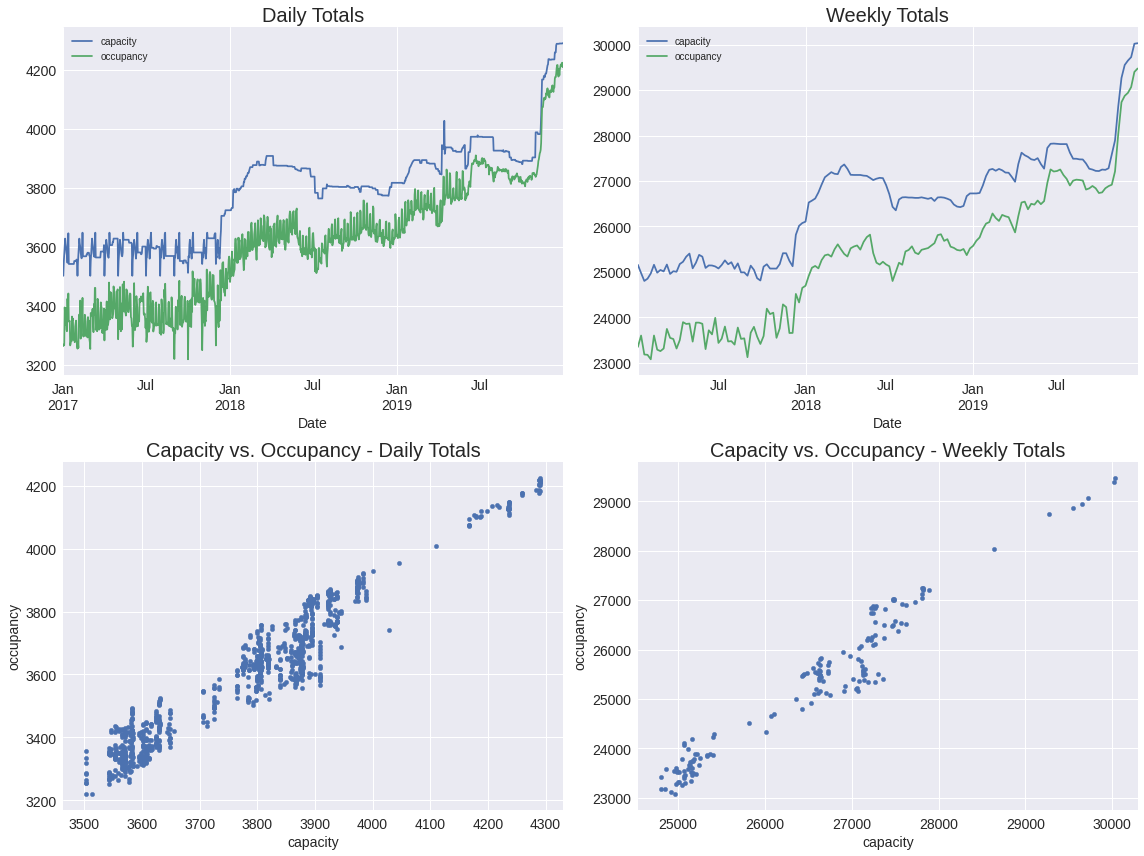

In [23]:
fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0))
ax4 = plt.subplot2grid((2, 2), (1, 1))

shelter_use__daily_totals[['capacity','occupancy']].plot(ax=ax1, title='Daily Totals');
shelter_use__weekly_totals[['capacity','occupancy']].plot(ax=ax2, title='Weekly Totals');
shelter_use__daily_totals.plot.scatter('capacity','occupancy',title='Capacity vs. Occupancy - Daily Totals', ax=ax3);
shelter_use__weekly_totals.plot.scatter('capacity','occupancy',title='Capacity vs. Occupancy - Weekly Totals', ax=ax4);

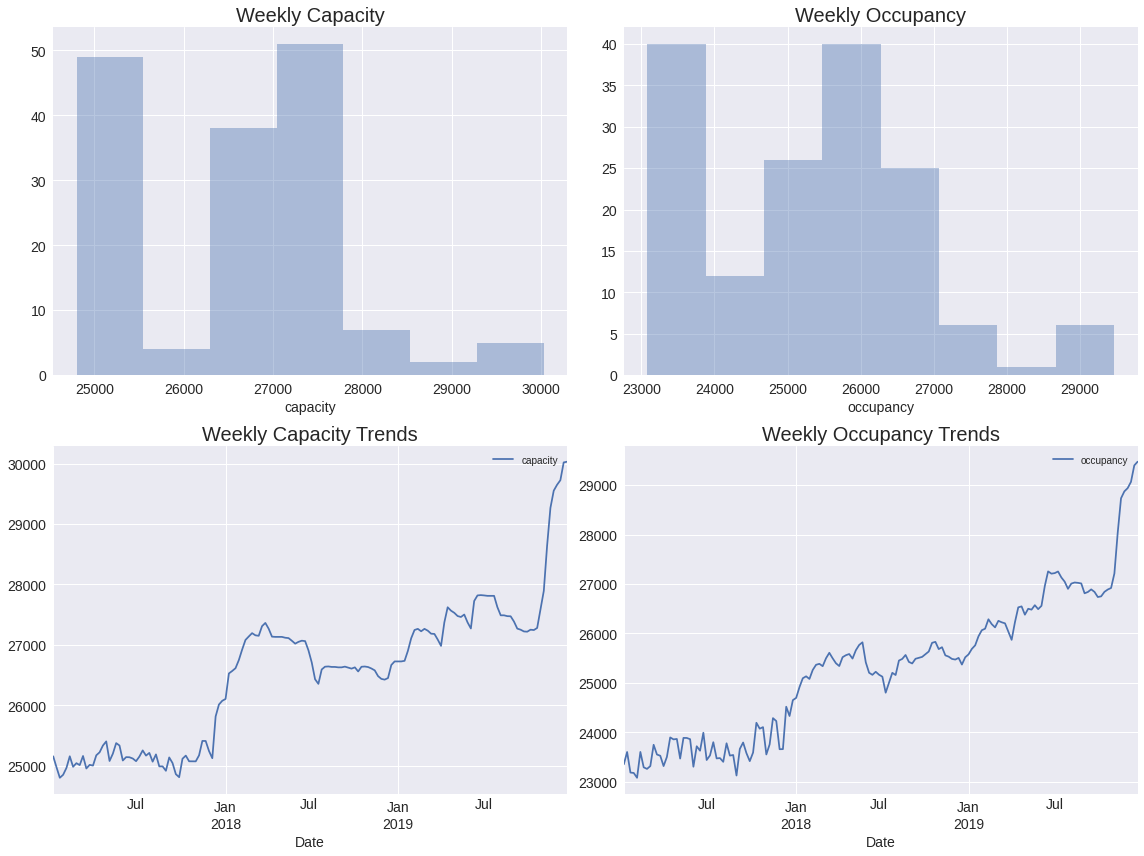

In [24]:
fig = plt.figure(figsize=(16, 12))
ax00 = plt.subplot2grid((2, 2), (0, 0))
ax01 = plt.subplot2grid((2, 2), (0, 1))
ax10 = plt.subplot2grid((2, 2), (1, 0))
ax11 = plt.subplot2grid((2, 2), (1, 1))

data = shelter_use__weekly_totals

sns.distplot(data.capacity, kde=False, norm_hist=False, ax=ax00,).set_title('Weekly Capacity');
sns.distplot(data.occupancy, kde=False, norm_hist=False,ax=ax01).set_title('Weekly Occupancy');
data[['capacity']].plot(ax=ax10, title='Weekly Capacity Trends');
data[['occupancy']].plot(ax=ax11, title='Weekly Occupancy Trends');

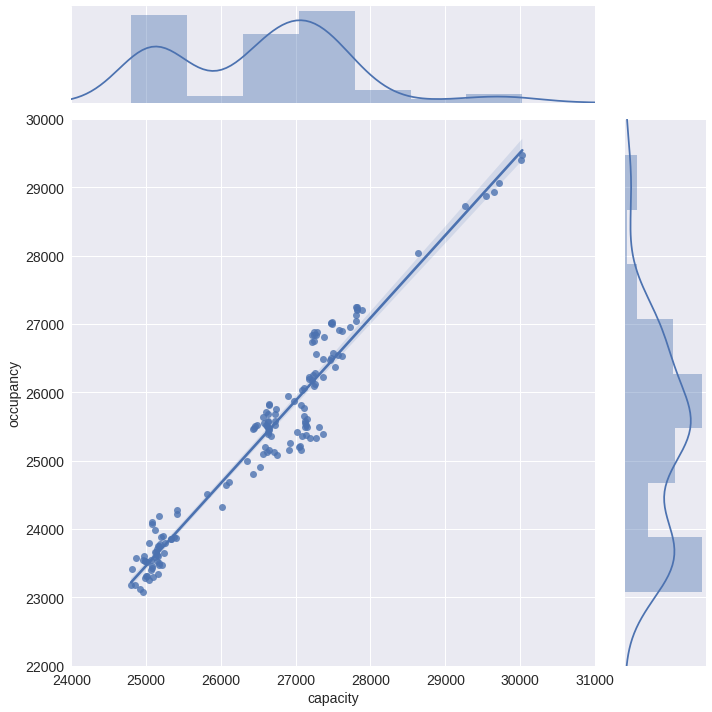

In [25]:
data = shelter_use__weekly_totals
g = sns.JointGrid(x='capacity', y='occupancy', data=data, height=10, ratio=5, xlim=(24000,31000), ylim=(22000,30000))
g.plot(sns.regplot, sns.distplot);

## Fit the Linear Regression Model

In [26]:
data = shelter_use__weekly_totals

# Calculate intercept and slope
m = sm.ols('occupancy ~ capacity', data = data[['capacity','occupancy']])
m = m.fit()
intercept, slope = m.params

# Find y estimates and residual errors
data['y_est'] = intercept + slope * data.capacity
data['residuals'] = data['y_est'] - data['occupancy']

In [27]:
# Describe the residuals
display(pd.DataFrame(data.residuals.describe().round(2)).T)
print('\n')

# OLS Regression Results 
print(m.summary())

count  mean     std     min     25%    50%     75%     max
residuals  156.0   0.0  341.31 -706.48 -197.33 -30.53  151.38  923.91



                            OLS Regression Results                            
Dep. Variable:              occupancy   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     2619.
Date:                Sun, 09 Aug 2020   Prob (F-statistic):           1.41e-98
Time:                        20:54:47   Log-Likelihood:                -1130.8
No. Observations:                 156   AIC:                             2266.
Df Residuals:                     154   BIC:                             2272.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6757.1462    627.482    -10.769      0

## Inspect Regression Model

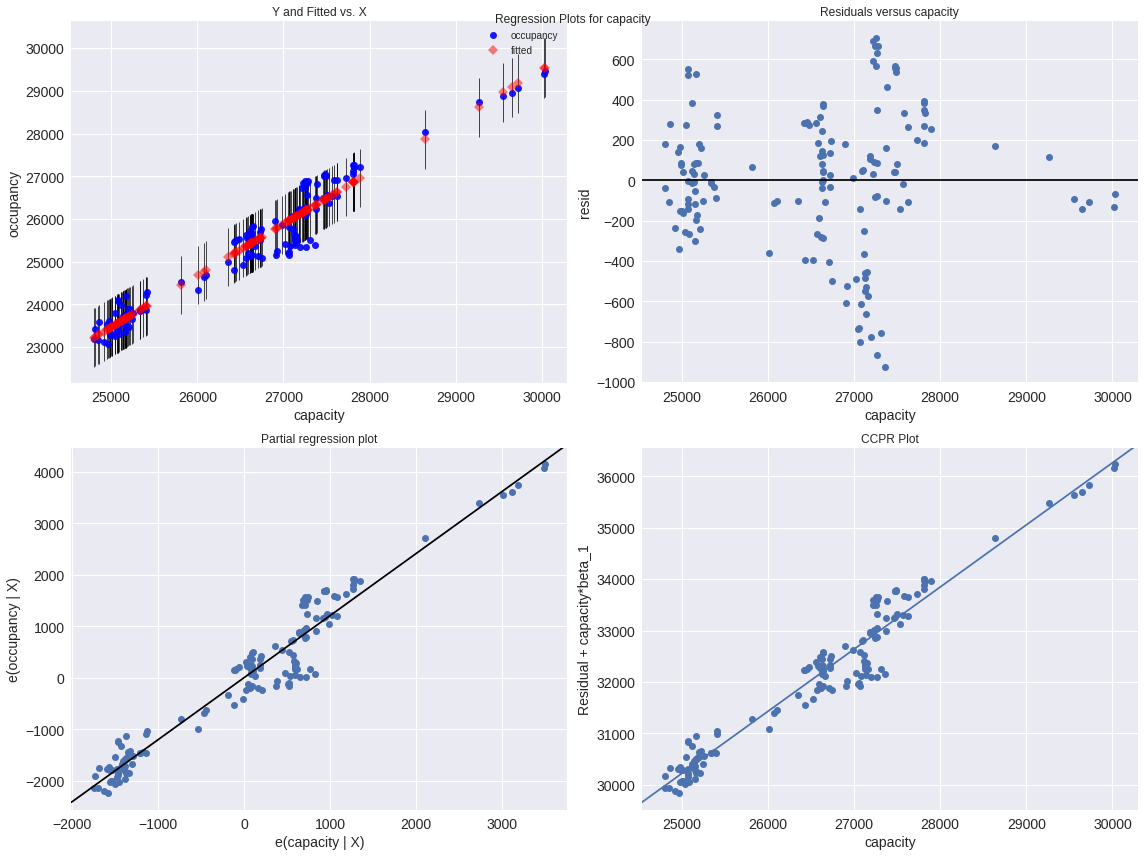

In [28]:
fig = plt.figure(figsize=(16, 12))
fig = plot_regress_exog(m, "capacity", fig = fig);

### Confirm that larger residuals have lower leverage.

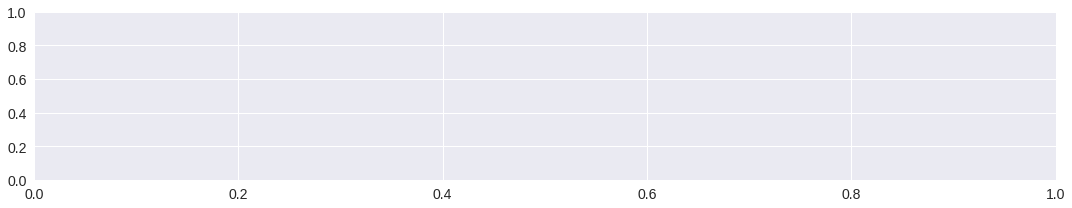

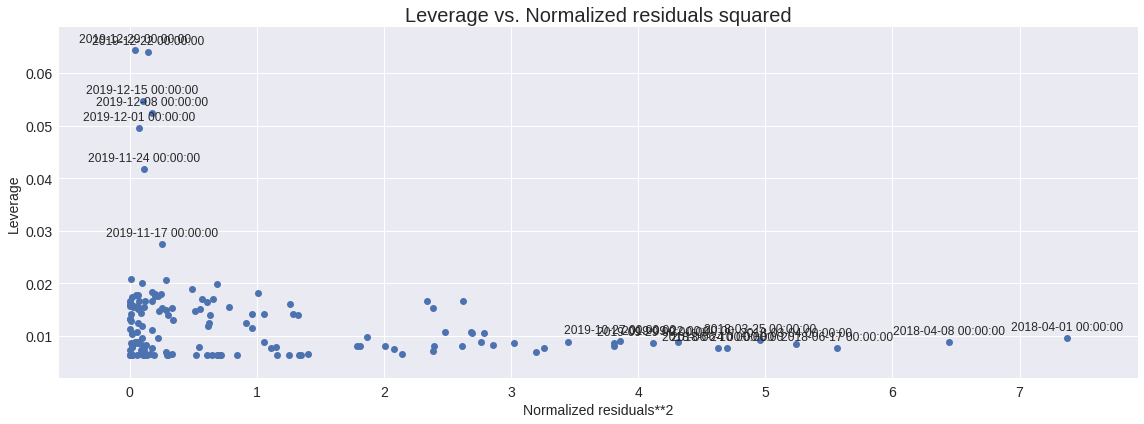

In [29]:
fig, ax = plt.subplots(figsize=(15,3))
fig = plot_leverage_resid2(m, ax=ax)

## Testing the OLS Assumptions

### 1. Linearity
   - True - The relationship can be represented by a linear equation.


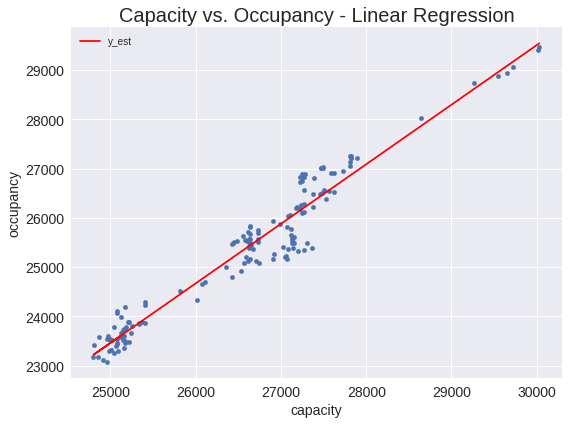

In [30]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
data.plot.scatter('capacity','occupancy',title='Capacity vs. Occupancy - Linear Regression', ax=ax);
data.plot.line('capacity','y_est', c='r', ax=ax);

### 2. Homoscedasticity (Nearly Normal Residuals)
  - Histogram shows a normal distribution of residuals.


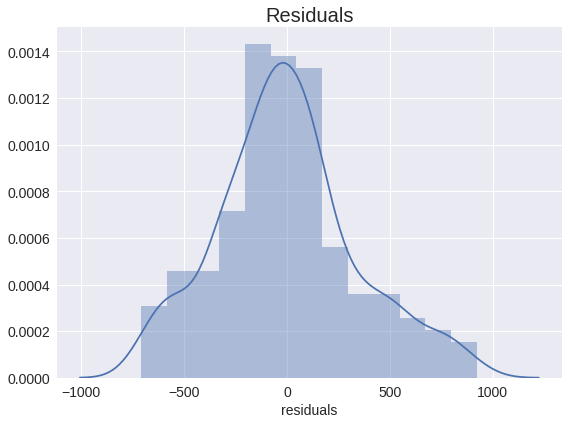

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(data.residuals,ax=ax).set_title('Residuals');
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0);

### 3. Constant Variability / No Autocorrelation
  - Significant autocorrelation is visible beyond 30 weeks in both variables.
  - No relationship between residuals and capacity.
  

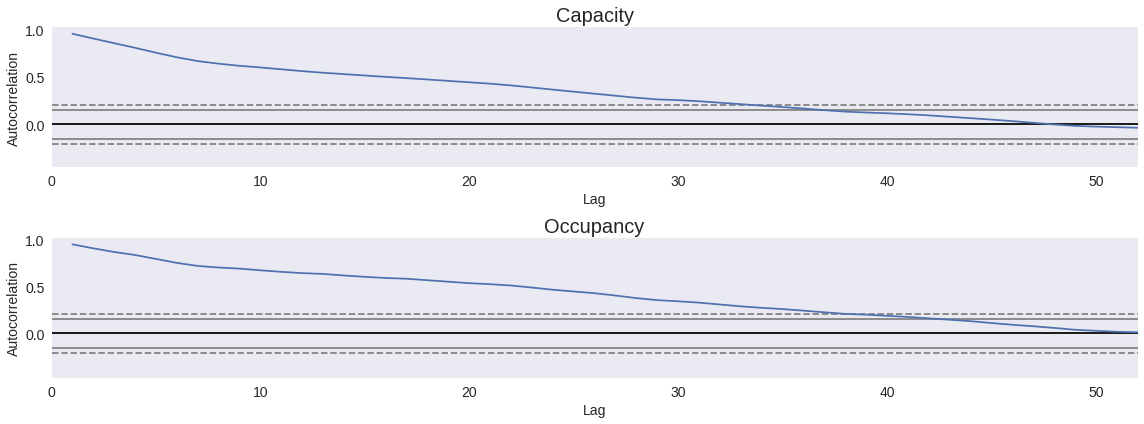

In [32]:
max_lag = 52 # 52 weeks = 1 year
fig, (ax1, ax2) = plt.subplots(2, 1)
pd.plotting.autocorrelation_plot(data.capacity, ax = ax1)
pd.plotting.autocorrelation_plot(data.occupancy, ax = ax2)

ax1.set_title('Capacity')
ax1.set_xlim(0, max_lag)

ax2.set_title('Occupancy')
ax2.set_xlim(0, max_lag)

plt.show()

### 4. Independent Observations
  - The autocorrelation of the residuals is less than that of the predictor.

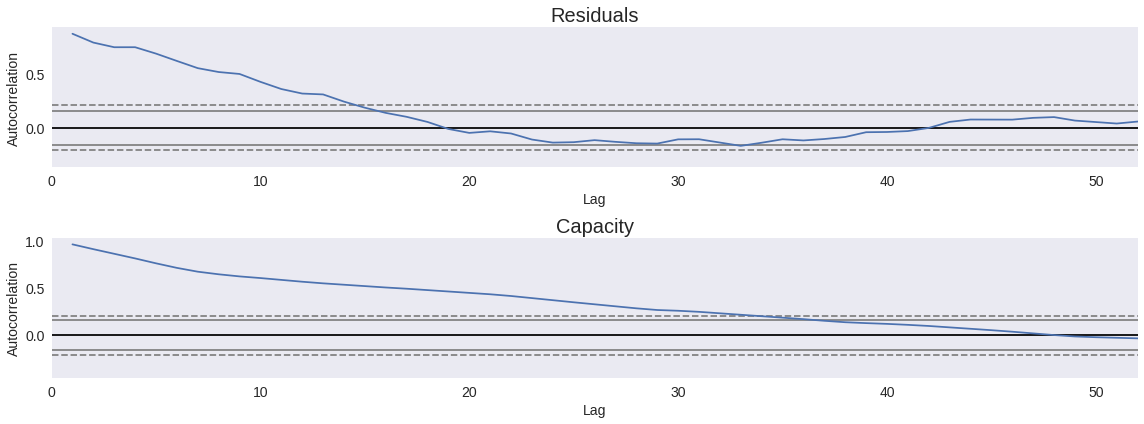

In [33]:
max_lag = 52 # 52 weeks = 1 year
fig, (ax1, ax2) = plt.subplots(2, 1)
pd.plotting.autocorrelation_plot(data.residuals, ax = ax1)
pd.plotting.autocorrelation_plot(data.capacity, ax = ax2)

ax1.set_title('Residuals')
ax1.set_xlim(0, max_lag)

ax2.set_title('Capacity')
ax2.set_xlim(0, max_lag)

plt.show()

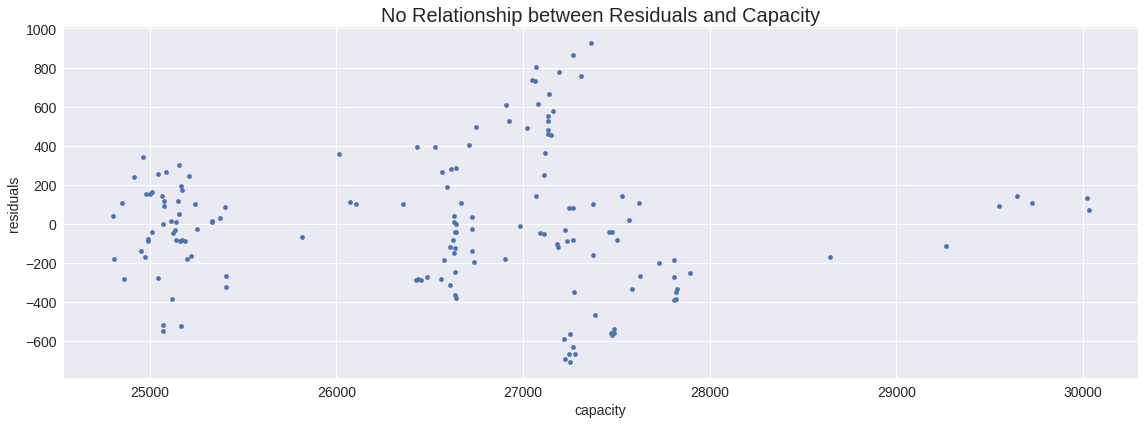

In [34]:
data.plot.scatter(x='capacity',y='residuals',title='No Relationship between Residuals and Capacity');



---

# Weather


---



## Setup

In [35]:
%reset-f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

## Load Shelter Data

In [36]:
# Import the daily shelter occupancy stats for the years 2017-2019
path = 'https://raw.githubusercontent.com/VernonNaidoo-Toronto/Understanding-Toronto-Shelters/master/Shelter%20Data/'
df = pd.read_csv(path+'shelter_use_totals_without_families__daily.csv', parse_dates=['Date'])
df.head()

Date  capacity  occupancy  vacancy
0 2017-01-01      3503       3265      238
1 2017-01-02      3548       3270      278
2 2017-01-03      3577       3268      309
3 2017-01-04      3607       3396      211
4 2017-01-05      3629       3367      262

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1095 non-null   datetime64[ns]
 1   capacity   1095 non-null   int64         
 2   occupancy  1095 non-null   int64         
 3   vacancy    1095 non-null   int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 34.3 KB


In [38]:
# Change the name of the date field to match what I used in functions below
df.rename(columns={'Date': 'Year_Month_Day', 'occupancy': 'OCCUPANCY' }, inplace=True)

In [39]:
# Set the date as a the index
df.set_index('Year_Month_Day', inplace=True)
df.head()

capacity  OCCUPANCY  vacancy
Year_Month_Day                              
2017-01-01          3503       3265      238
2017-01-02          3548       3270      278
2017-01-03          3577       3268      309
2017-01-04          3607       3396      211
2017-01-05          3629       3367      262

## Load Weather Data

In [40]:
# *******************************************************
# Add weather data
path = 'https://raw.githubusercontent.com/VernonNaidoo-Toronto/Understanding-Toronto-Shelters/master/Weather%20Data/'
dfw17 = pd.read_csv(path+'en_climate_daily_ON_6158355_2017_P1D.csv', parse_dates=['Date/Time'])
dfw18 = pd.read_csv(path+'en_climate_daily_ON_6158355_2018_P1D.csv', parse_dates=['Date/Time'])
dfw19 = pd.read_csv(path+'en_climate_daily_ON_6158355_2019_P1D.csv', parse_dates=['Date/Time'])

In [41]:
# Concatenate into one dataframe
dfw=pd.concat([dfw17,dfw18,dfw19])
# Clean up missing values - remove them. 
# Remove days with no temp data
#dfw = dfw[dfw.'Max Temp Flag' != 'M']
dfw.drop(dfw.index[dfw['Max Temp Flag'] == 'M'], inplace = True)
dfw.head()

Longitude (x)  Latitude (y)  ... Spd of Max Gust (km/h)  Spd of Max Gust Flag
0          -79.4         43.67  ...                    NaN                     M
1          -79.4         43.67  ...                    NaN                     M
2          -79.4         43.67  ...                    NaN                     M
3          -79.4         43.67  ...                    NaN                     M
4          -79.4         43.67  ...                    NaN                     M

[5 rows x 31 columns]

In [42]:
# Drop empty columns
dfw.drop(['Data Quality', 'Max Temp Flag', 'Min Temp Flag', 'Mean Temp Flag', 
          'Heat Deg Days Flag', 'Cool Deg Days Flag', 'Total Rain (mm)',
          'Total Rain Flag', 'Total Snow (cm)', 'Total Snow Flag', 
          'Total Precip Flag', 'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)', 
          'Spd of Max Gust (km/h)', 'Spd of Max Gust Flag'], axis = 1, inplace=True) 
dfw.head()

Longitude (x)  Latitude (y)  ... Snow on Grnd (cm)  Dir of Max Gust Flag
0          -79.4         43.67  ...               3.0                     M
1          -79.4         43.67  ...               3.0                     M
2          -79.4         43.67  ...               1.0                     M
3          -79.4         43.67  ...               NaN                     M
4          -79.4         43.67  ...               NaN                     M

[5 rows x 16 columns]

## Independent EDA Visualization of Shelter and Weather

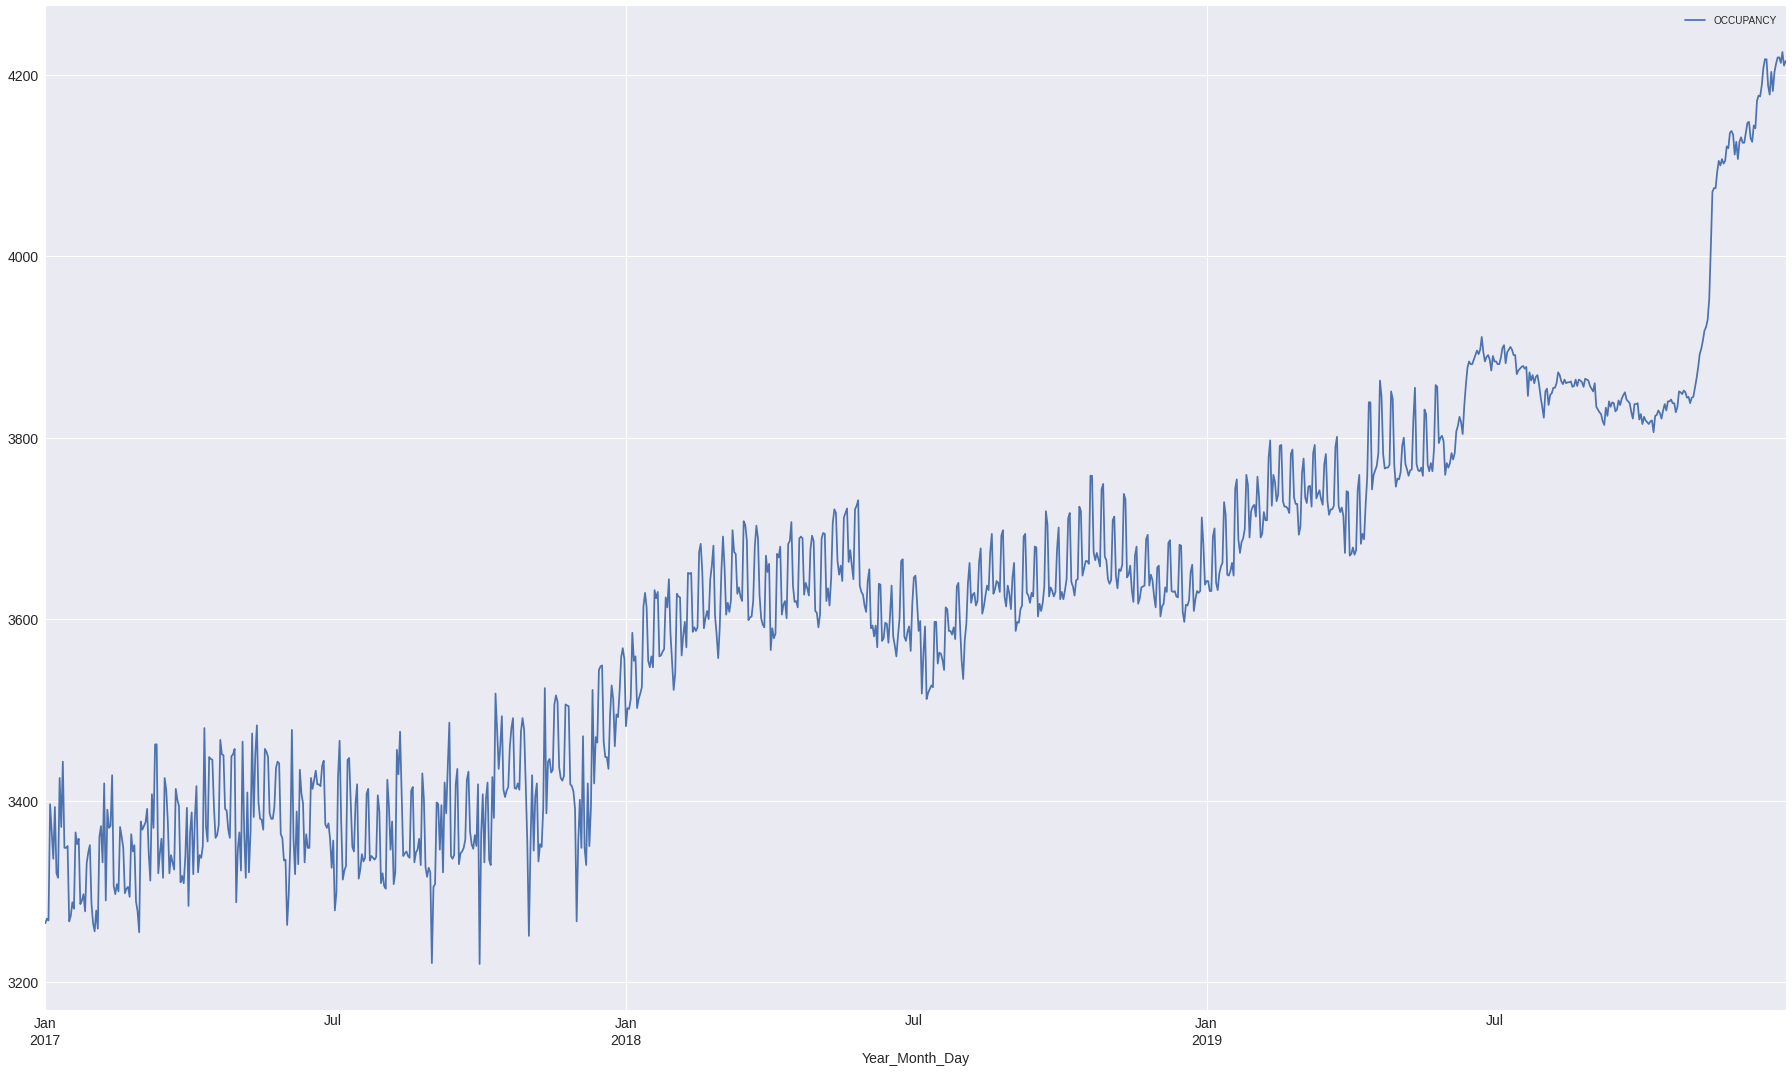

In [43]:
# Plot Occupancy
ax = df.reset_index().plot(x='Year_Month_Day', y='OCCUPANCY', figsize=(25,15))
ax;

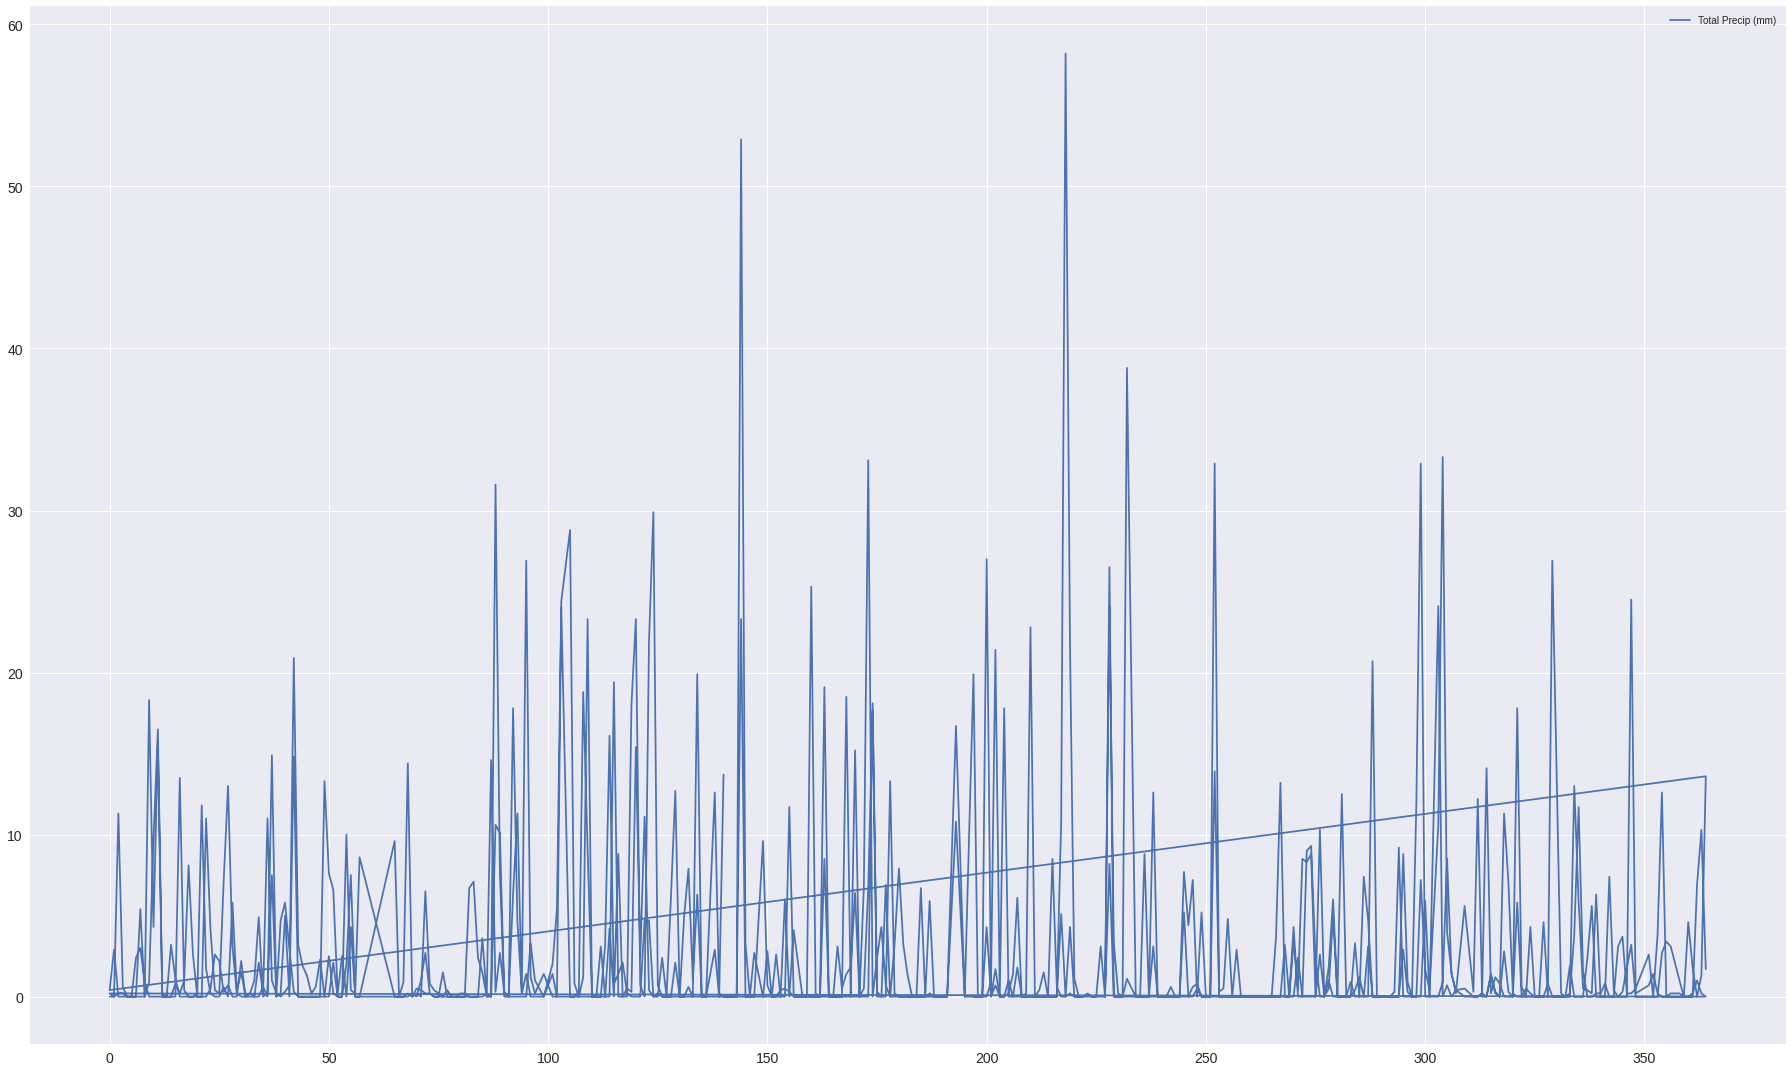

In [44]:
# Long term growth trend, some seasonality seems apparent.
#********************
# Now plot precipitation
axw = dfw.plot(y='Total Precip (mm)', figsize=(25,15))

In [45]:
dfw.head()

Longitude (x)  Latitude (y)  ... Snow on Grnd (cm)  Dir of Max Gust Flag
0          -79.4         43.67  ...               3.0                     M
1          -79.4         43.67  ...               3.0                     M
2          -79.4         43.67  ...               1.0                     M
3          -79.4         43.67  ...               NaN                     M
4          -79.4         43.67  ...               NaN                     M

[5 rows x 16 columns]

## Merge Shelter and Weather Data

In [46]:
# In preparation for statistical analysis, merge the Weather & Shelter data
dfw.set_index('Date/Time', inplace=True)

In [47]:
print('PRE-MERGE CHECK:',
      np.where(df.index.dtype==dfw.index.dtype,'Index datatypes match. Ready for merge.', 'Index datatypes do not match.  Resolve before merging.')
      )

PRE-MERGE CHECK: Index datatypes match. Ready for merge.


In [48]:
# To run additional analysis, bring the two datasets into a single dataframe
merged_df = pd.concat([df, dfw], axis=1, sort=False)
merged_df.head()

capacity  OCCUPANCY  ...  Snow on Grnd (cm)  Dir of Max Gust Flag
2017-01-01      3503       3265  ...                3.0                     M
2017-01-02      3548       3270  ...                3.0                     M
2017-01-03      3577       3268  ...                1.0                     M
2017-01-04      3607       3396  ...                NaN                     M
2017-01-05      3629       3367  ...                NaN                     M

[5 rows x 18 columns]

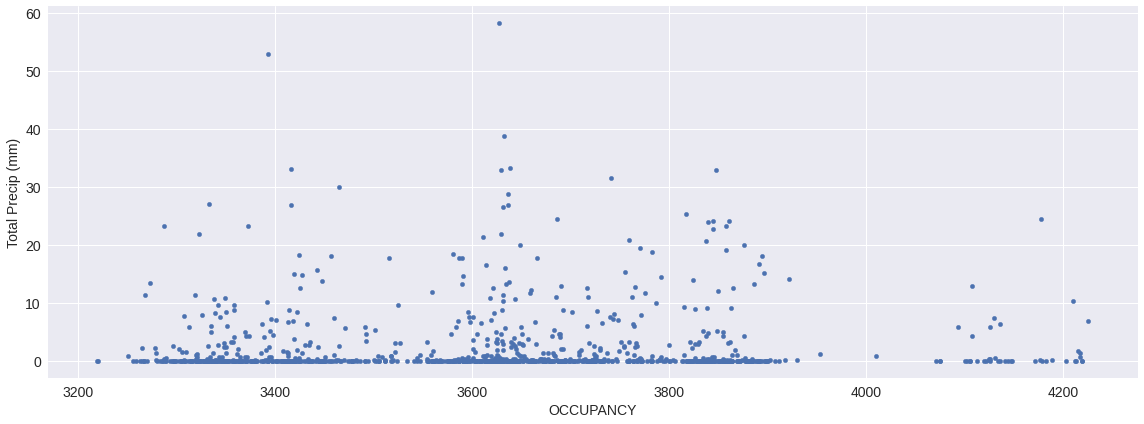

In [49]:
# Scatter plot with Occupancy and Total Precipitation
ax = merged_df.plot.scatter(x='OCCUPANCY', y='Total Precip (mm)')

## Linear Regression

In [50]:
# Run regression analysis on hypothesis 1 (Precipitation)
# For regression analysis we will use the statsmodels package
import statsmodels.formula.api as sm

In [51]:
# For visual inspection of the regression models
from statsmodels.graphics.regressionplots import plot_regress_exog, plot_fit, plot_leverage_resid2, influence_plot

In [52]:
# Let's rename Total Precip(mm) & Min Temp (°C) - it may cause us trouble later
merged_df.rename(columns={'Total Precip (mm)':'TotalPrecipmm', 'Min Temp (°C)':'MinTempCelsius'}, inplace=True)

In [53]:
cm = merged_df.corr(method = 'pearson')

# Print correlation matrix
cm

capacity  ...  Snow on Grnd (cm)
capacity            1.000000e+00  ...           0.033090
OCCUPANCY           9.600173e-01  ...          -0.006024
vacancy            -5.018454e-01  ...           0.104707
Longitude (x)       5.379520e-15  ...           0.000000
Latitude (y)        1.136569e-14  ...           0.000000
Climate ID                   NaN  ...                NaN
Year                8.774954e-01  ...           0.031360
Month               1.489256e-01  ...          -0.154480
Day                 5.275758e-02  ...          -0.092733
Max Temp (°C)      -6.729312e-02  ...          -0.425311
MinTempCelsius     -6.703496e-02  ...          -0.463796
Mean Temp (°C)     -6.782993e-02  ...          -0.457069
Heat Deg Days (°C)  7.596914e-02  ...           0.457069
Cool Deg Days (°C) -9.556921e-03  ...                NaN
TotalPrecipmm       2.595372e-02  ...          -0.093688
Snow on Grnd (cm)   3.309050e-02  ...           1.000000

[16 rows x 16 columns]

In [54]:
# Calculate the means of x, y
mu_x = merged_df["OCCUPANCY"].mean()
mu_y = merged_df["TotalPrecipmm"].mean()

print(mu_x, mu_y)

3618.611872146119 2.454005934718103


In [55]:
# Calculate the standard deviations of x, y
sig_x = merged_df["OCCUPANCY"].std()
sig_y = merged_df["TotalPrecipmm"].std()

print(sig_x, sig_y)

210.7277371415258 5.95645180413759


In [56]:
beta_1 = sig_y/sig_x * cm.loc['OCCUPANCY', 'TotalPrecipmm']
beta_0 = mu_y - beta_1 * mu_x

print(beta_0, beta_1)

-0.4689350568064503 0.0008077520040277272


In [57]:
#Fit the regression model using the OLS method
# Initialize the regression model
m = sm.ols('TotalPrecipmm ~ OCCUPANCY', data = merged_df)

In [58]:
# Fit the regression model
m = m.fit()

In [59]:
# Print the regression parameters
m.params

Intercept   -0.472353
OCCUPANCY    0.000808
dtype: float64

In [60]:
# Visualize our results.
# Calculate estimates of y

intercept, slope = m.params
merged_df['y_est'] = intercept + slope * merged_df.OCCUPANCY

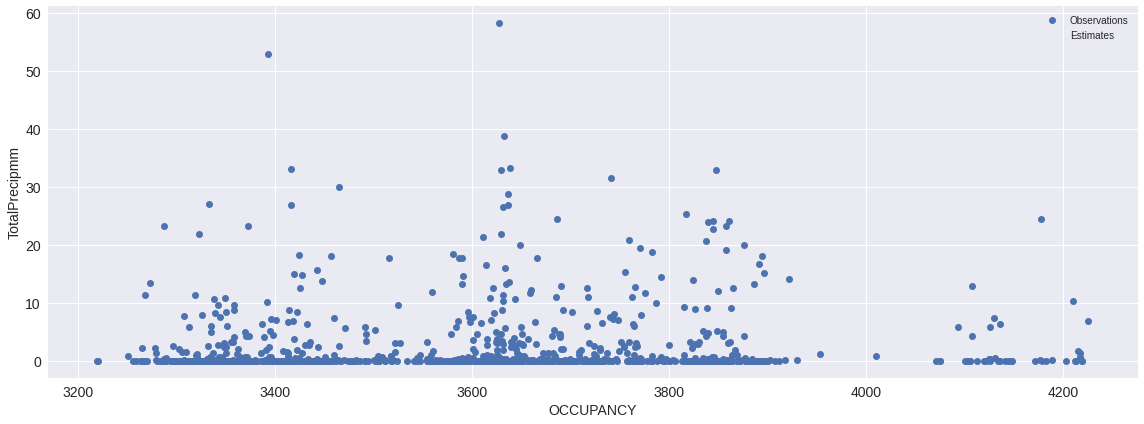

In [61]:
# Plot the estimates along the actual observations
plt.plot(merged_df.OCCUPANCY, merged_df.TotalPrecipmm, 'o', label = 'Observations')
plt.xlabel('OCCUPANCY')
plt.ylabel('TotalPrecipmm')

# Draw estimates
plt.plot(merged_df.OCCUPANCY, merged_df.y_est, 'r+', label='Estimates')

# Add legend
plt.legend()
plt.show()

In [62]:
# Show the model summary
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TotalPrecipmm   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8247
Date:                Sun, 09 Aug 2020   Prob (F-statistic):              0.364
Time:                        20:54:55   Log-Likelihood:                -3237.7
No. Observations:                1011   AIC:                             6479.
Df Residuals:                    1009   BIC:                             6489.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4724      3.228     -0.146      0.884      -6.807       5.862
OCCUPANCY      0.0008      0.001      0.908      0.364      -0.001       0.003
==============================================================================
Omnibus:                      851.660   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19070.256
Skew:                           3.867   Prob(JB):                         0.00
Kurtosis:                      22.821   Cond. No.                     6.25e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [63]:
# No relationship. Try hypothesis #2 - negative relationship between minimum daily temperature
# and occupancy

In [64]:
# Same x, input a new y
mu_y2 = merged_df["MinTempCelsius"].mean()

print(mu_x, mu_y2)

3618.611872146119 5.921730580137663


In [65]:
# Calculate the standard deviations of the new y

sig_y2 = merged_df["MinTempCelsius"].std()

print(sig_x, sig_y2)

210.7277371415258 9.91449814060688


In [66]:
beta_1 = sig_y2/sig_x * cm.loc['OCCUPANCY', 'MinTempCelsius']
beta_0 = mu_y2 - beta_1 * mu_x

print(beta_0, beta_1)

9.777287453164925 -0.001065479528961092


In [67]:
#Fit the regression model using the OLS method
# Initialize the regression model

m = sm.ols('MinTempCelsius ~ OCCUPANCY', data = merged_df)

In [68]:
# Fit the regression model
m = m.fit()

In [69]:
# Print the regression parameters
m.params

Intercept    9.780576
OCCUPANCY   -0.001066
dtype: float64

In [70]:
# Visualize our results.
# Calculate estimates of y2

intercept, slope = m.params
merged_df['y2_est'] = intercept + slope * merged_df.OCCUPANCY

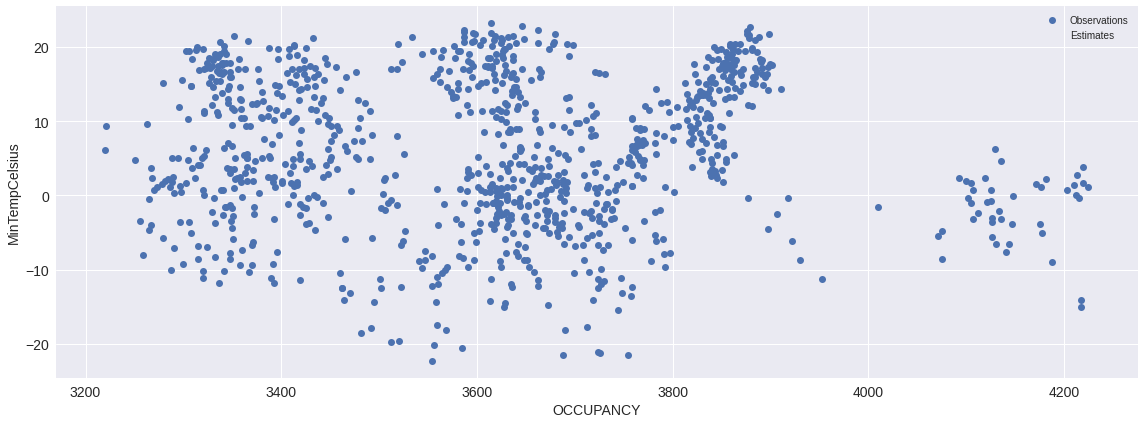

In [71]:
# Plot the estimates along the actual observations

plt.plot(merged_df.OCCUPANCY, merged_df.MinTempCelsius, 'o', label = 'Observations')
plt.xlabel('OCCUPANCY')
plt.ylabel('MinTempCelsius')

# Draw estimates
plt.plot(merged_df.OCCUPANCY, merged_df.y2_est, 'r+', label='Estimates')

# Add legend
plt.legend()
plt.show()

In [72]:
# Visually a very slight negative relationship
# Show the model summary 
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         MinTempCelsius   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5208
Date:                Sun, 09 Aug 2020   Prob (F-statistic):              0.471
Time:                        20:54:55   Log-Likelihood:                -3775.3
No. Observations:                1017   AIC:                             7555.
Df Residuals:                    1015   BIC:                             7564.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.7806      5.356      1.826      0.068      -0.730      20.291
OCCUPANCY     -0.0011      0.001     -0.722      0.471      -0.004       0.002
==============================================================================
Omnibus:                       63.294   Durbin-Watson:                   0.103
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.253
Skew:                          -0.300   Prob(JB):                     2.21e-08
Kurtosis:                       2.313   Cond. No.                     6.24e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.24e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [73]:
# No correlation at all

In [74]:
# What's the main problem? Growing capacity is driving Occupancy
# We need to de-trend this data. We'll try two methods
# 1. Statistical
# 2. Taking a sample where capacity is held constant.

# *********************************************************
# 1. Using statmodels: Subtracting the Trend Component.
from statsmodels.tsa.seasonal import seasonal_decompose
# We'll use additive & multiplicative decomposition then compare.
merged_df.interpolate(inplace = True)
#merged_df.index=merged_df.index.to_timestamp()
result_mul = seasonal_decompose(merged_df['OCCUPANCY'], model='multiplicative')

# And to compare, do Additive as well
# Additive model
result_add = seasonal_decompose(merged_df['OCCUPANCY'], model='additive')

<Figure size 1440x720 with 0 Axes>

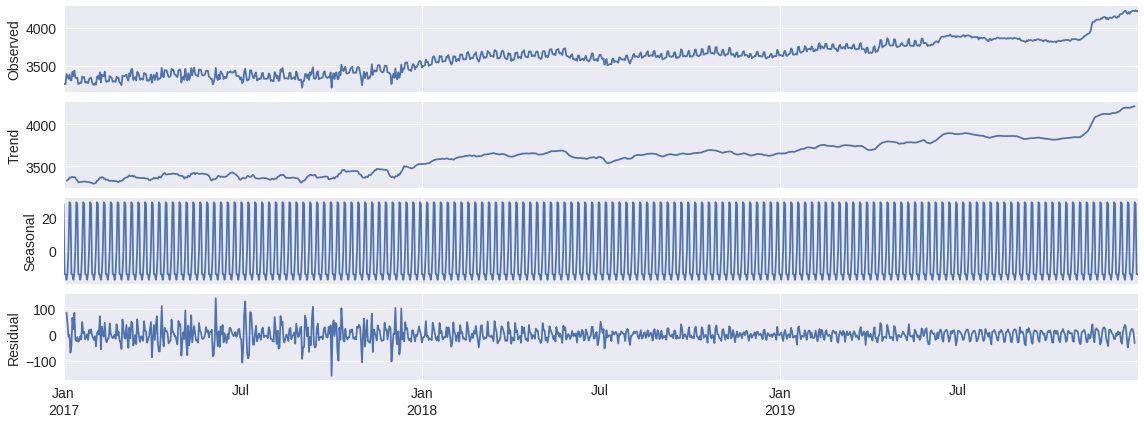

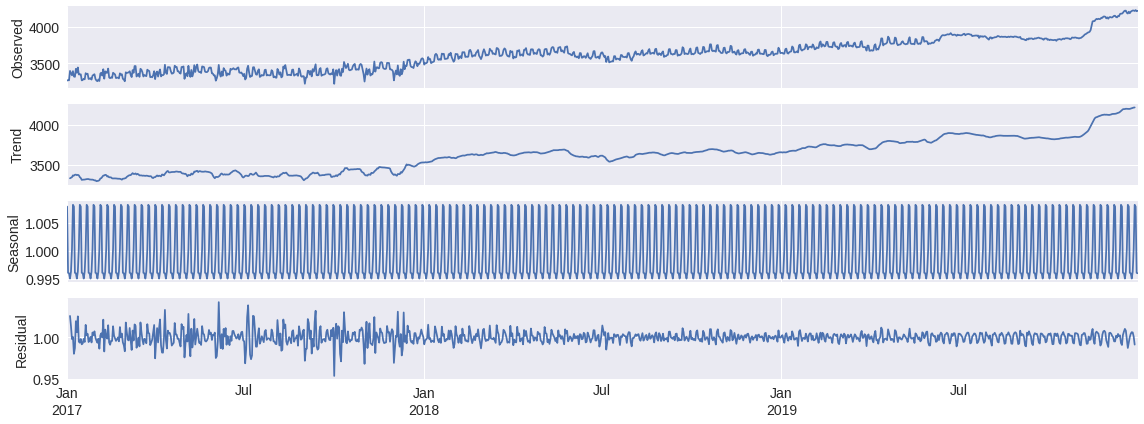

In [75]:
plt.figure(figsize=(20,10))
p1 = result_add.plot()
p2 = result_mul.plot()
plt.show()

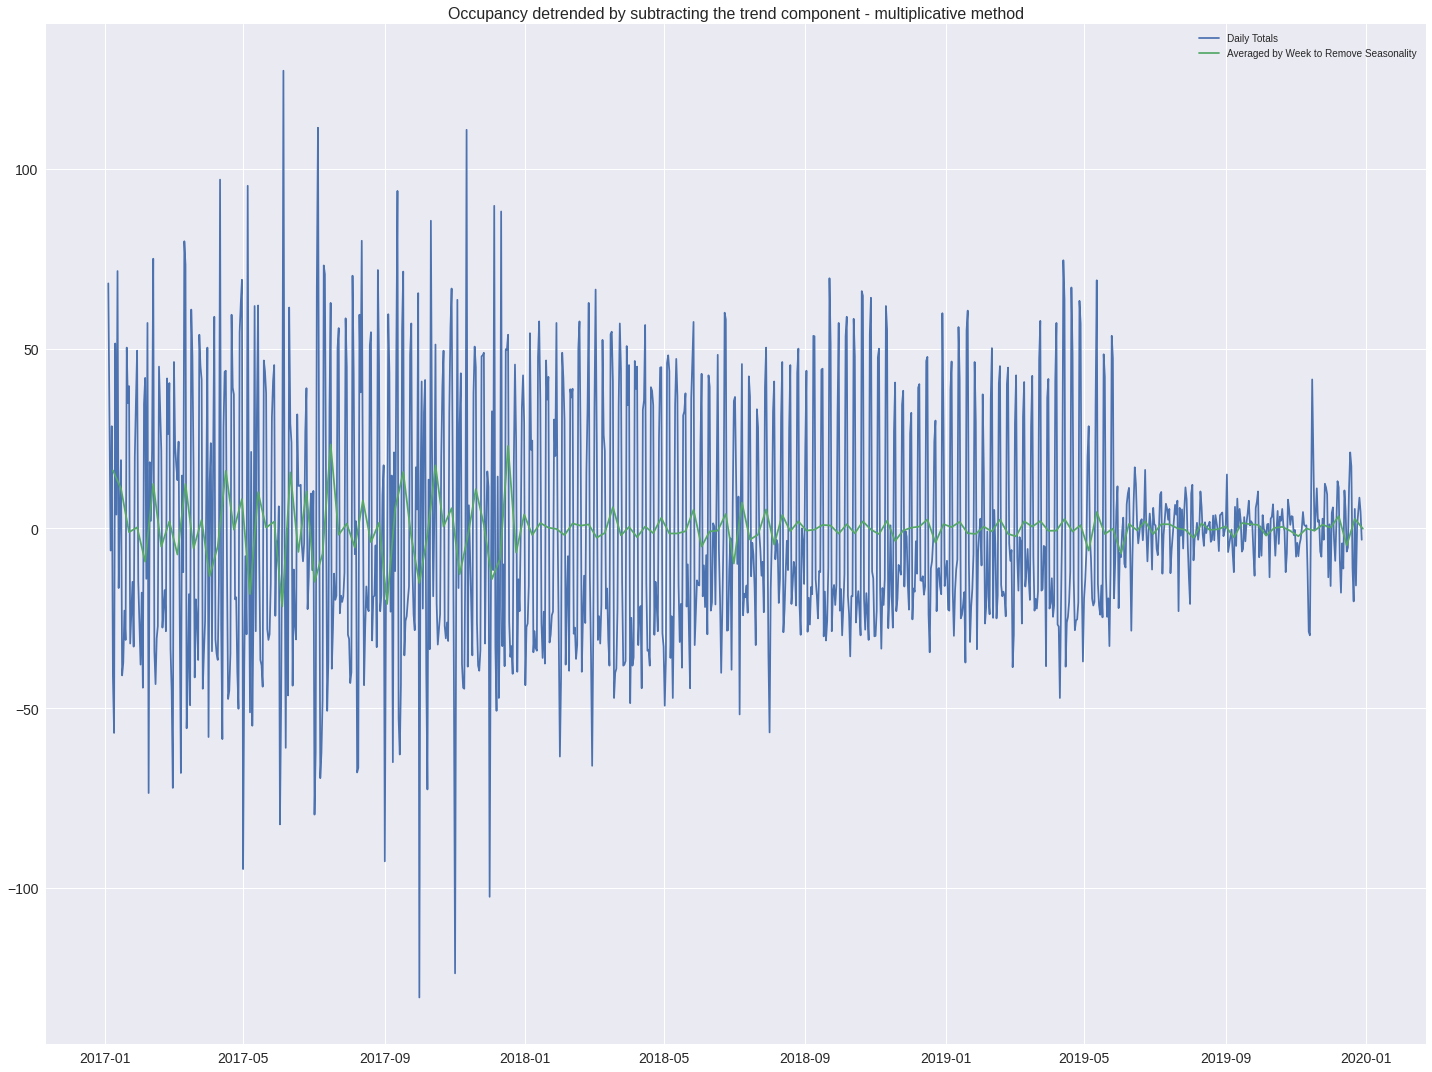

In [76]:
detrended_mul = merged_df.OCCUPANCY.values - result_mul.trend
detrended_add = merged_df.OCCUPANCY.values - result_add.trend
fig=plt.figure(figsize=(20,15))
plt.plot(detrended_mul)
plt.plot(detrended_mul.resample('W').mean())
plt.legend(['Daily Totals','Averaged by Week to Remove Seasonality'])
plt.title('Occupancy detrended by subtracting the trend component - multiplicative method', fontsize=16);

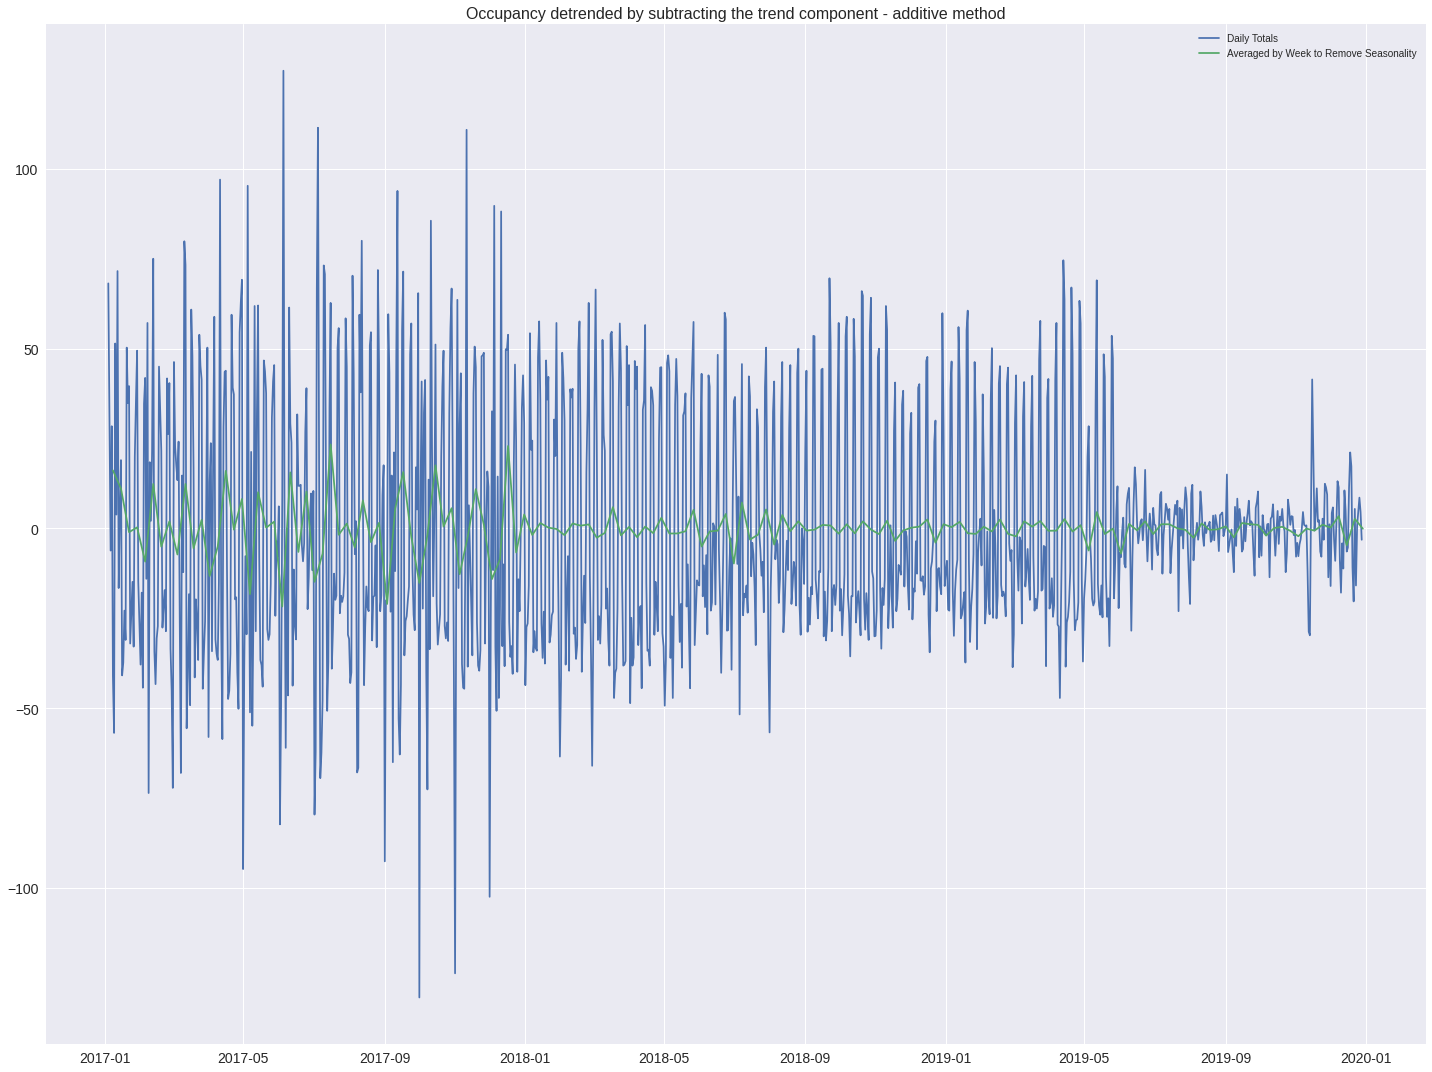

In [77]:
fig=plt.figure(figsize=(20,15))
plt.plot(detrended_add)
plt.plot(detrended_add.resample('W').mean())
plt.legend(['Daily Totals','Averaged by Week to Remove Seasonality'])
plt.title('Occupancy detrended by subtracting the trend component - additive method', fontsize=16);

In [78]:
# Ok, the transformation has successfully removed the growth trend. The Occupancy though
# though it highly erratic through to May 2019 for some reason.
# Check to see if remaining noise is white noise
# Take the residuals and remove NaNs
residual1 = result_mul.resid.dropna()
residual2 = result_add.resid.dropna()

In [79]:
# Calculate means
mu1 = residual1.mean()
mu2 = residual2.mean()

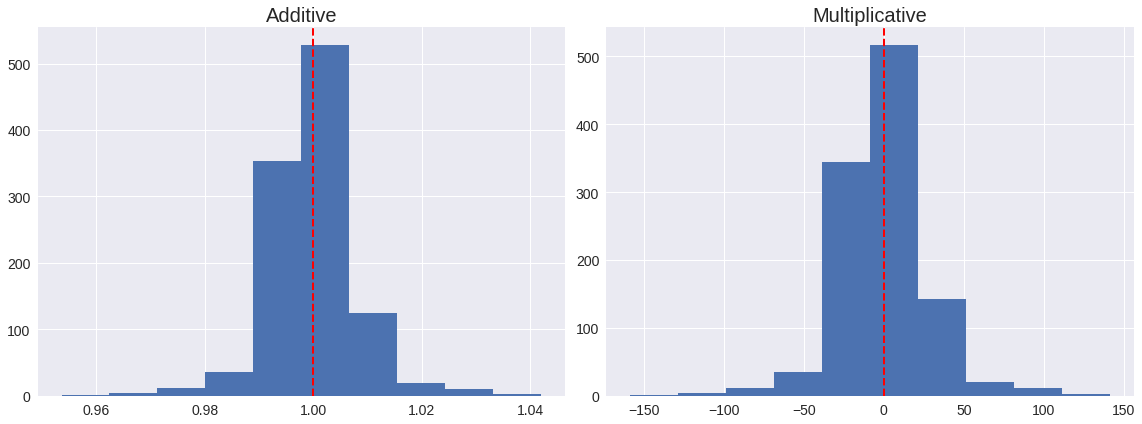

In [80]:
# Plot histograms
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(residual1)
ax2.hist(residual2)

# Add titles
ax1.set_title('Additive')
ax2.set_title('Multiplicative')

# Add vertical lines to highlight the means
ax1.axvline(x = mu1, 
            color='r', 
            linestyle='dashed', 
            linewidth=2)

ax2.axvline(x = mu2, 
            color='r', 
            linestyle='dashed', 
            linewidth=2)

plt.show()

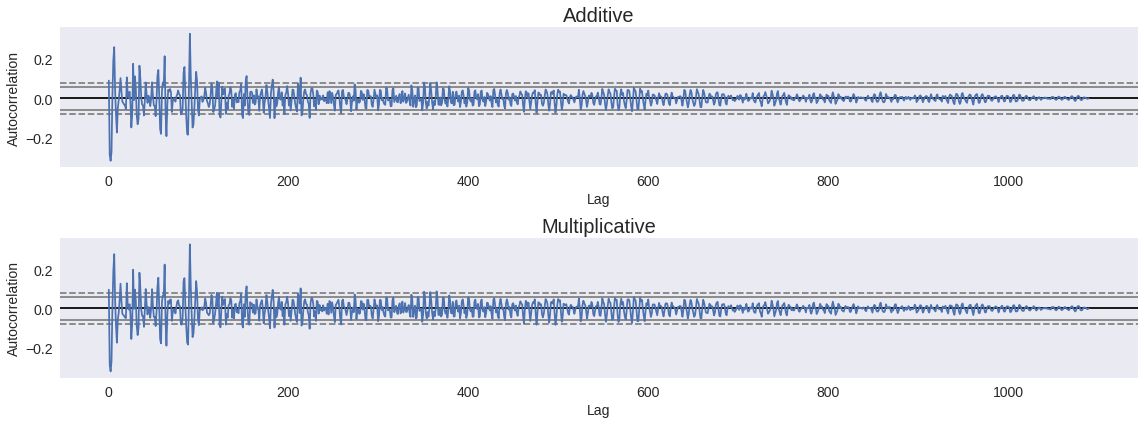

In [81]:
# Results are very similar - spread is nearly identical. 
# Assess the independence by calculating autocorrelation
fig, (ax1, ax2) = plt.subplots(2, 1)

pd.plotting.autocorrelation_plot(residual1, ax = ax1)
pd.plotting.autocorrelation_plot(residual2, ax = ax2)

# Add titles
ax1.set_title('Additive')
ax2.set_title('Multiplicative')

plt.subplots_adjust(hspace = 0.9)
plt.show()

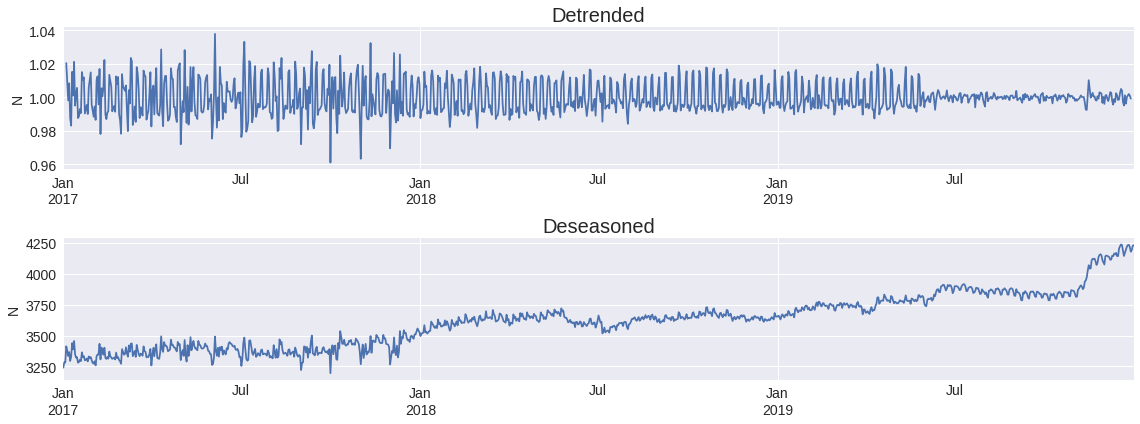

In [82]:
# Both models show similar autocorrelation. Either model could be used.
# Remove the trend from the signal a different way
merged_df['detrended'] = merged_df.OCCUPANCY / result_mul.trend
merged_df['deseasoned'] = merged_df.OCCUPANCY / result_mul.seasonal

fix, (ax1, ax2) = plt.subplots(2, 1)
merged_df['detrended'].plot(ax = ax1)
merged_df['deseasoned'].plot(ax = ax2)

ax1.set_ylabel('N')
ax2.set_ylabel('N')

ax1.set_title('Detrended')
ax2.set_title('Deseasoned')

plt.subplots_adjust(hspace = 0.9)
plt.show()

In [83]:
trend_strength = 1. - np.var(result_mul.resid) / np.var(result_mul.resid * result_mul.trend)
seasonality_strength = 1. - np.var(result_mul.resid) / np.var(result_mul.resid + result_mul.seasonal)

In [84]:
print ('Strength of trend is: %1.3f' % trend_strength)
print ('Strength of seasonality is: %1.3f' % seasonality_strength)

Strength of trend is: 1.000
Strength of seasonality is: 0.309


- The strength of the trend is far greater than the strength of seasonality
- So we'll use de-trended data to do OLS Regression

In [85]:
# Print correlation matrix
cm = merged_df.corr(method = 'pearson')
cm

capacity     OCCUPANCY  ...     detrended    deseasoned
capacity            1.000000e+00  9.600173e-01  ...  2.591181e-02  9.640440e-01
OCCUPANCY           9.600173e-01  1.000000e+00  ...  1.647544e-01  9.958368e-01
vacancy            -5.018454e-01 -7.239170e-01  ... -4.413074e-01 -7.011302e-01
Longitude (x)      -6.494116e-15 -1.510143e-14  ... -5.007081e-14 -2.995047e-15
Latitude (y)       -9.504516e-15  1.904776e-15  ...  5.007071e-14  3.123122e-15
Climate ID                   NaN           NaN  ...           NaN           NaN
Year                8.762745e-01  8.996592e-01  ... -5.789073e-03  9.035371e-01
Month               1.507538e-01  2.455493e-01  ... -2.461896e-03  2.457844e-01
Day                 5.265180e-02  6.546114e-02  ...  6.860823e-02  6.568431e-02
Max Temp (°C)      -7.927908e-02 -3.976223e-02  ... -2.580512e-02 -3.774928e-02
MinTempCelsius     -8.258603e-02 -3.823994e-02  ... -2.221002e-02 -3.704385e-02
Mean Temp (°C)     -8.197664e-02 -3.970905e-02  ... -2.421567e-02 -3.806258e-02
Heat Deg Days (°C)  9.181870e-02  4.610282e-02  ...  2.647998e-02  4.434810e-02
Cool Deg Days (°C) -1.137309e-02  1.110307e-03  ... -5.965632e-03  1.702687e-03
TotalPrecipmm       2.687045e-02  3.111807e-02  ...  3.586040e-02  3.406359e-02
Snow on Grnd (cm)   2.079127e-01  1.586527e-01  ... -1.964410e-02  1.604405e-01
y_est               9.600173e-01  1.000000e+00  ...  1.647544e-01  9.958368e-01
y2_est             -9.600173e-01 -1.000000e+00  ... -1.647544e-01 -9.958368e-01
detrended           2.591181e-02  1.647544e-01  ...  1.000000e+00  1.145231e-01
deseasoned          9.640440e-01  9.958368e-01  ...  1.145231e-01  1.000000e+00

[20 rows x 20 columns]

In [86]:
# Calculate the means of x, y
mu_x = merged_df["detrended"].mean()
mu_y = merged_df["TotalPrecipmm"].mean()

print(mu_x, mu_y)

1.00002056909523 2.482328767123289


In [87]:
# Calculate the standard deviations of x, y
sig_x = merged_df["detrended"].std()
sig_y = merged_df["TotalPrecipmm"].std()

print(sig_x, sig_y)

0.009541850853523905 5.8646930416138305


In [88]:
beta_1 = sig_y/sig_x * cm.loc['detrended', 'TotalPrecipmm']
beta_0 = mu_y - beta_1 * mu_x

print(beta_0, beta_1)

-19.558948466430454 22.040823873748536


In [89]:
#Fit the regression model using the OLS method
# Initialize the regression model
m = sm.ols('TotalPrecipmm ~ detrended', data = merged_df)

In [90]:
# Fit the regression model
m = m.fit()

In [91]:
# Print the regression parameters
m.params

Intercept   -19.58326
detrended    22.05108
dtype: float64

In [92]:
# Visualize our results.
# Calculate estimates of y
intercept, slope = m.params
merged_df['y_est'] = intercept + slope * merged_df.detrended

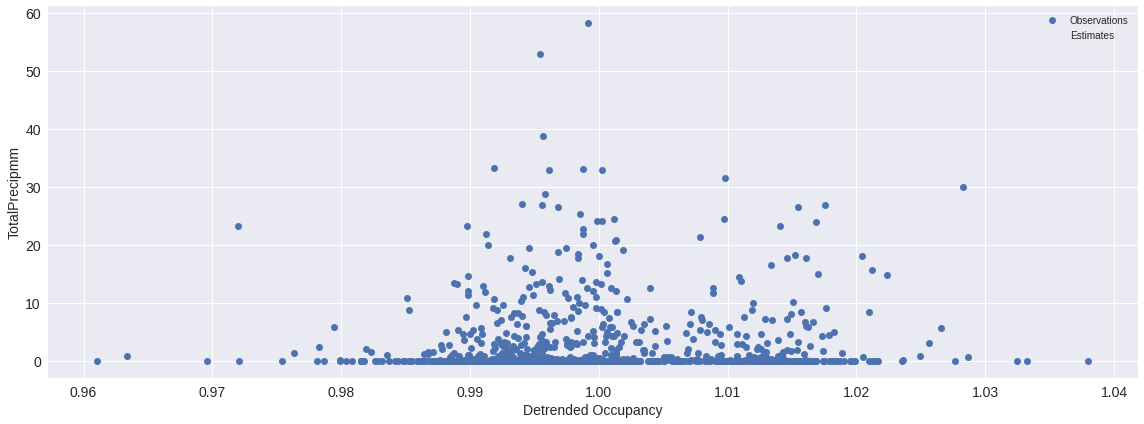

In [93]:
# Plot the estimates along the actual observations
plt.plot(merged_df.detrended, merged_df.TotalPrecipmm, 'o', label = 'Observations')
plt.xlabel('Detrended Occupancy')
plt.ylabel('TotalPrecipmm')

# Draw estimates
plt.plot(merged_df.detrended, merged_df.y_est, 'r+', label='Estimates')

# Add legend
plt.legend()
plt.show()

In [94]:
# Show the model summary
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          TotalPrecipmm   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.400
Date:                Sun, 09 Aug 2020   Prob (F-statistic):              0.237
Time:                        20:55:03   Log-Likelihood:                -3470.9
No. Observations:                1089   AIC:                             6946.
Df Residuals:                    1087   BIC:                             6956.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -19.5833     18.640     -1.051      0.294     -56.158      16.991
detrended     22.0511     18.639      1.183      0.237     -14.521      58.623
==============================================================================
Omnibus:                      912.100   Durbin-Watson:                   1.695
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20504.665
Skew:                           3.849   Prob(JB):                         0.00
Kurtosis:                      22.815   Cond. No.                         210.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

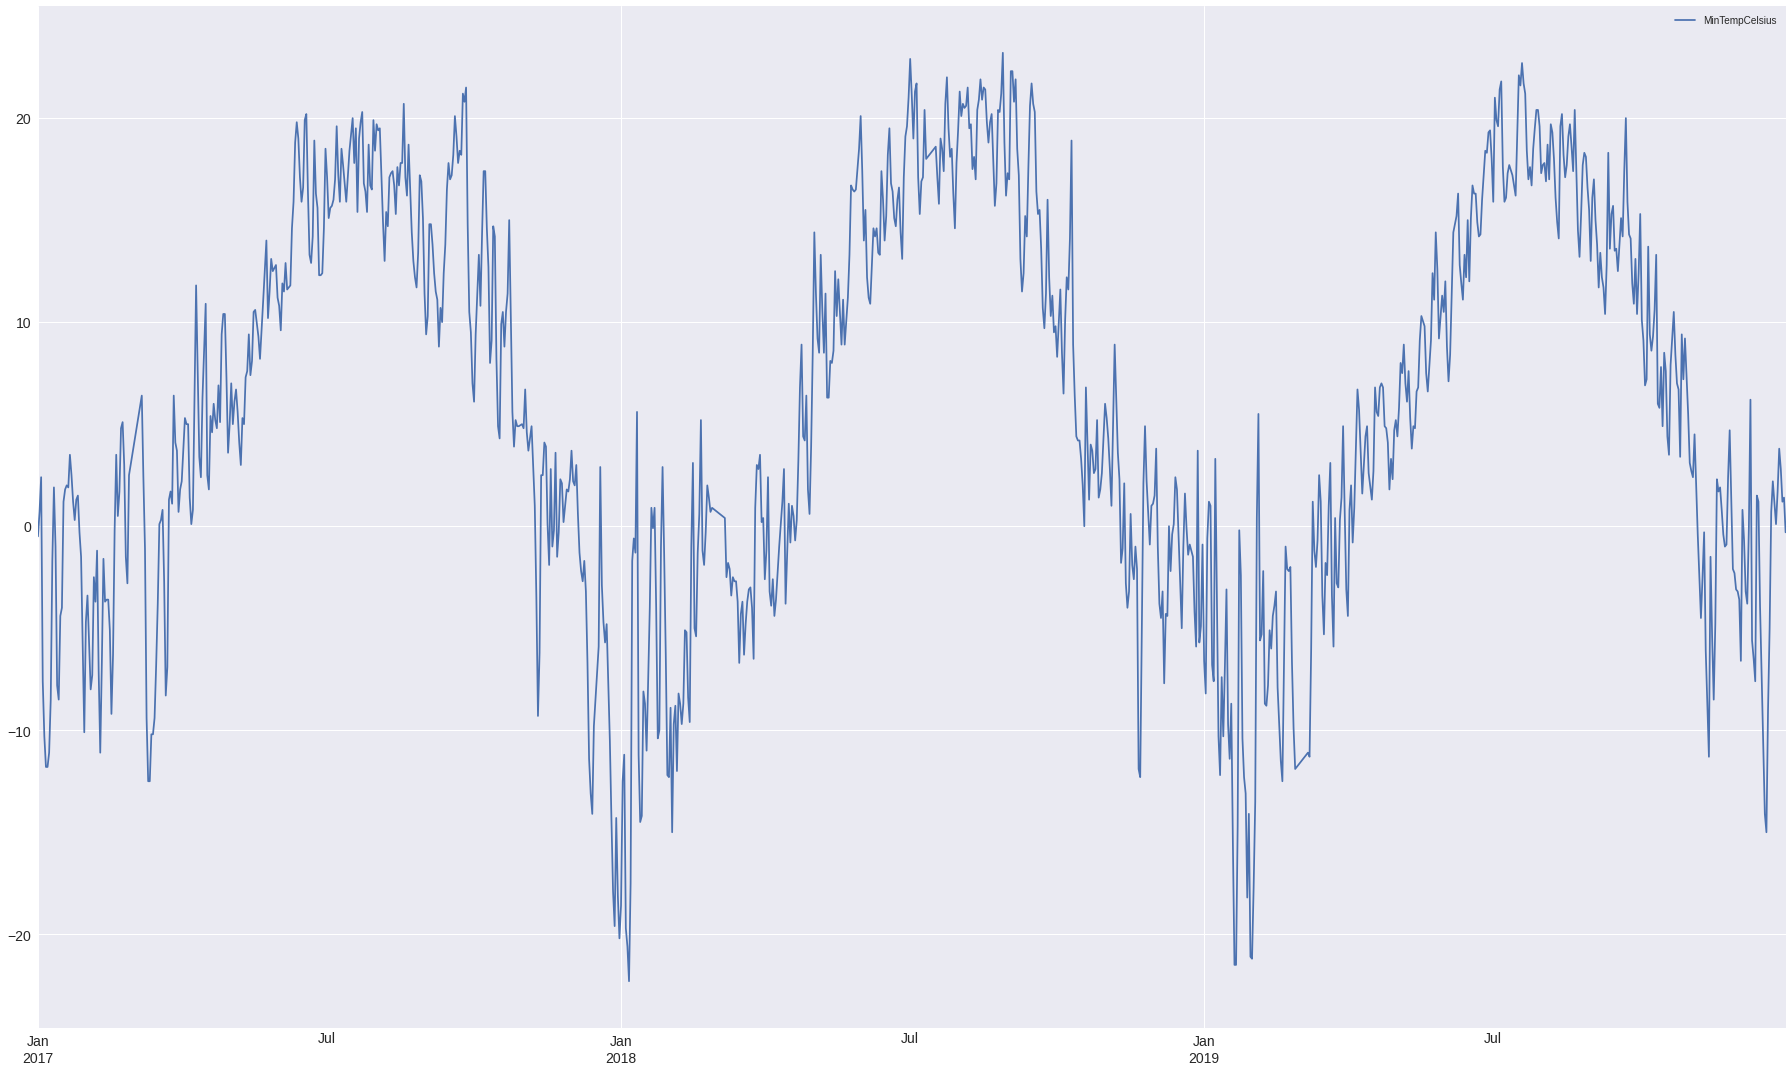

In [95]:
# The R-squared and Adjusted R-squared values show no correlation at all between Total
# Precipitation and the detrended Occupancy data.

# Let's do the same with temperature.
# Now plot temperature
axw = merged_df.plot(y='MinTempCelsius', figsize=(25,15))

In [96]:
# Same x, input a new y
mu_y2 = merged_df["MinTempCelsius"].mean()

print(mu_x, mu_y2)

1.00002056909523 5.844474885844754


In [97]:
# Calculate the standard deviations of the new y
sig_y2 = merged_df["MinTempCelsius"].std()

print(sig_x, sig_y2)

0.009541850853523905 9.856542861126368


In [98]:
beta_1 = sig_y2/sig_x * cm.loc['detrended', 'MinTempCelsius']
beta_0 = mu_y2 - beta_1 * mu_x

print(beta_0, beta_1)

28.787459685187088 -22.94251289260983


In [99]:
#Fit the regression model using the OLS method
# Initialize the regression model

m2 = sm.ols('MinTempCelsius ~ detrended', data = merged_df)

In [100]:
# Fit the regression model
m2 = m2.fit()

In [101]:
# Print the regression parameters
m2.params

Intercept    28.861175
detrended   -22.988526
dtype: float64

In [102]:
# Visualize our results.
# Calculate estimates of y2

intercept, slope = m2.params
merged_df['y2_est'] = intercept + slope * merged_df.detrended

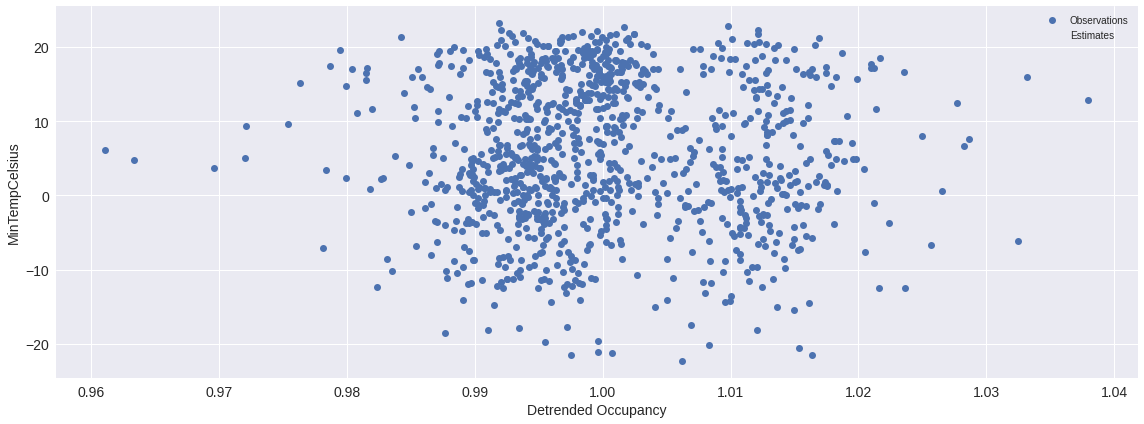

In [103]:
# Plot the estimates along the actual observations

plt.plot(merged_df.detrended, merged_df.MinTempCelsius, 'o', label = 'Observations')
plt.xlabel('Detrended Occupancy')
plt.ylabel('MinTempCelsius')

# Draw estimates
plt.plot(merged_df.detrended, merged_df.y2_est, 'r+', label='Estimates')

# Add legend
plt.legend()
plt.show()

In [104]:
# Show the model summary for Extreme Cold
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         MinTempCelsius   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5365
Date:                Sun, 09 Aug 2020   Prob (F-statistic):              0.464
Time:                        20:55:04   Log-Likelihood:                -4038.4
No. Observations:                1089   AIC:                             8081.
Df Residuals:                    1087   BIC:                             8091.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.8612     31.388      0.919      0.358     -32.727      90.450
detrended    -22.9885     31.386     -0.732      0.464     -84.573      38.596
==============================================================================
Omnibus:                       71.431   Durbin-Watson:                   0.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.029
Skew:                          -0.293   Prob(JB):                     5.52e-09
Kurtosis:                       2.296   Cond. No.                         210.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
# No correlation at all.
# Last attempt - isolate the days with some precipitation (precip >= 2mm) and the tempurature is near freezing
# (-10 to +1)
NearZero_Precip = merged_df[(merged_df['TotalPrecipmm'] >= 2) & (merged_df['MinTempCelsius'] >-10) & (merged_df['MinTempCelsius'] <= 1)]

In [106]:
NearZero_Precip.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53 entries, 2017-01-10 to 2019-12-06
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   capacity              53 non-null     int64  
 1   OCCUPANCY             53 non-null     int64  
 2   vacancy               53 non-null     int64  
 3   Longitude (x)         53 non-null     float64
 4   Latitude (y)          53 non-null     float64
 5   Station Name          50 non-null     object 
 6   Climate ID            53 non-null     float64
 7   Year                  53 non-null     float64
 8   Month                 53 non-null     float64
 9   Day                   53 non-null     float64
 10  Max Temp (°C)         53 non-null     float64
 11  MinTempCelsius        53 non-null     float64
 12  Mean Temp (°C)        53 non-null     float64
 13  Heat Deg Days (°C)    53 non-null     float64
 14  Cool Deg Days (°C)    53 non-null     float64
 15  Total

In [107]:
NearZero_Precip.head()

capacity  OCCUPANCY  vacancy  ...    y2_est  detrended   deseasoned
2017-01-10      3547       3425      122  ...  5.522199   1.015245  3438.582562
2017-01-12      3647       3443      204  ...  5.384630   1.021229  3455.653116
2017-01-31      3543       3265      278  ...  6.057236   0.991970  3277.948048
2017-02-07      3602       3419      183  ...  5.481904   1.016997  3432.558767
2017-02-10      3562       3370      192  ...  5.858022   1.000636  3368.783769

[5 rows x 22 columns]

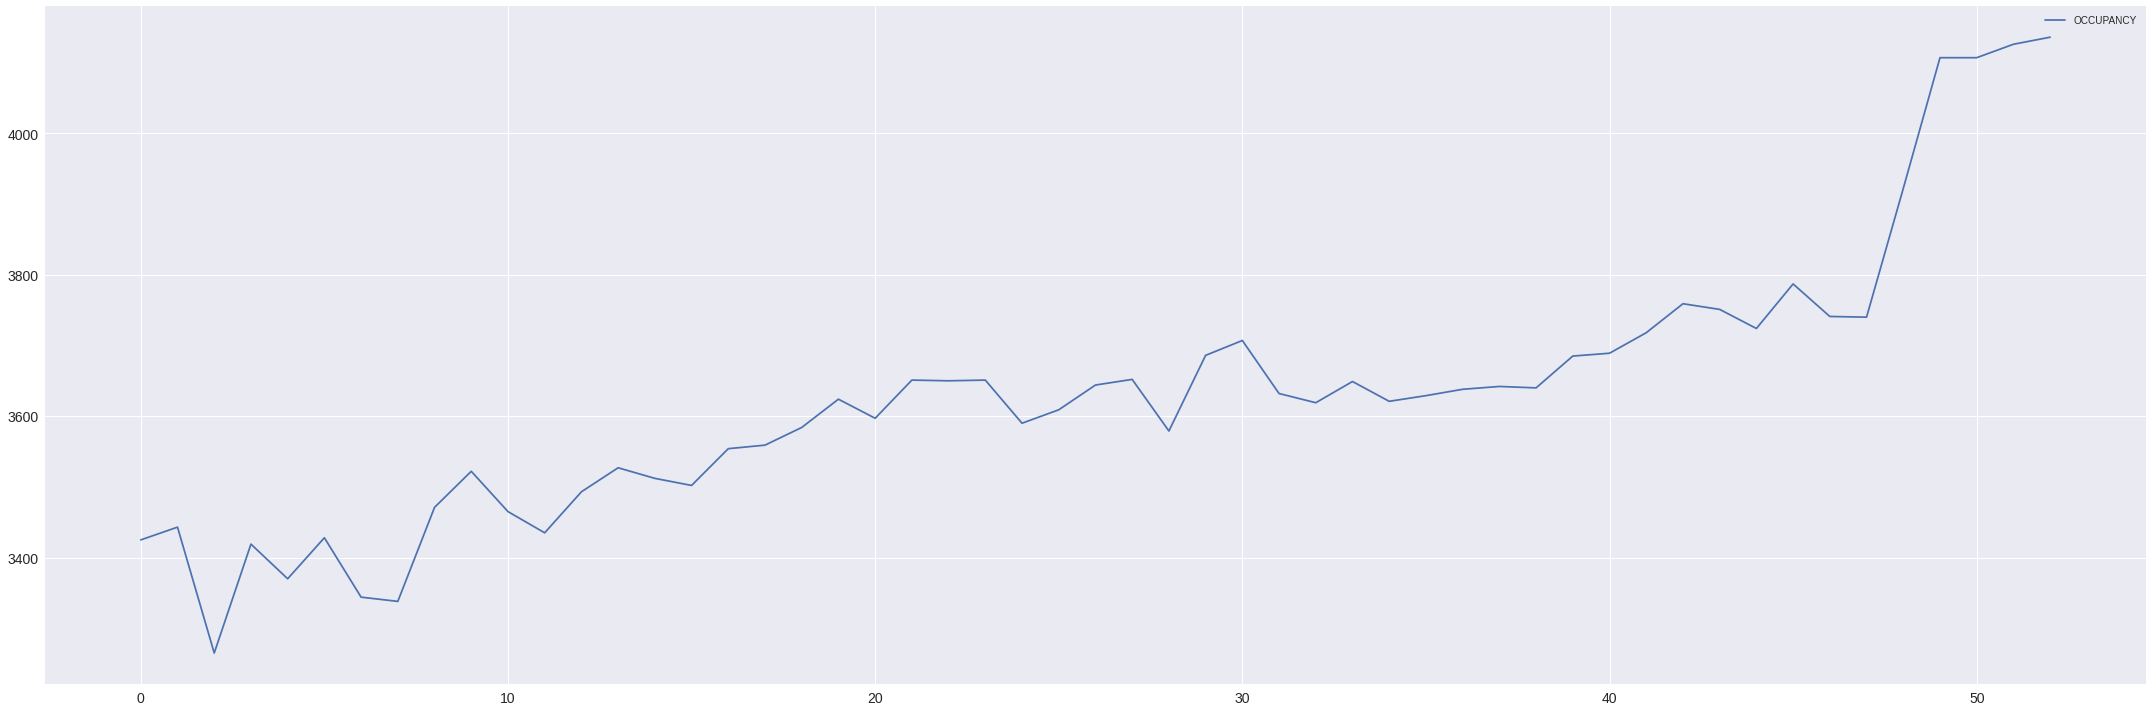

In [108]:
ax5 = NearZero_Precip.reset_index().plot(y='OCCUPANCY',figsize=(30,10))

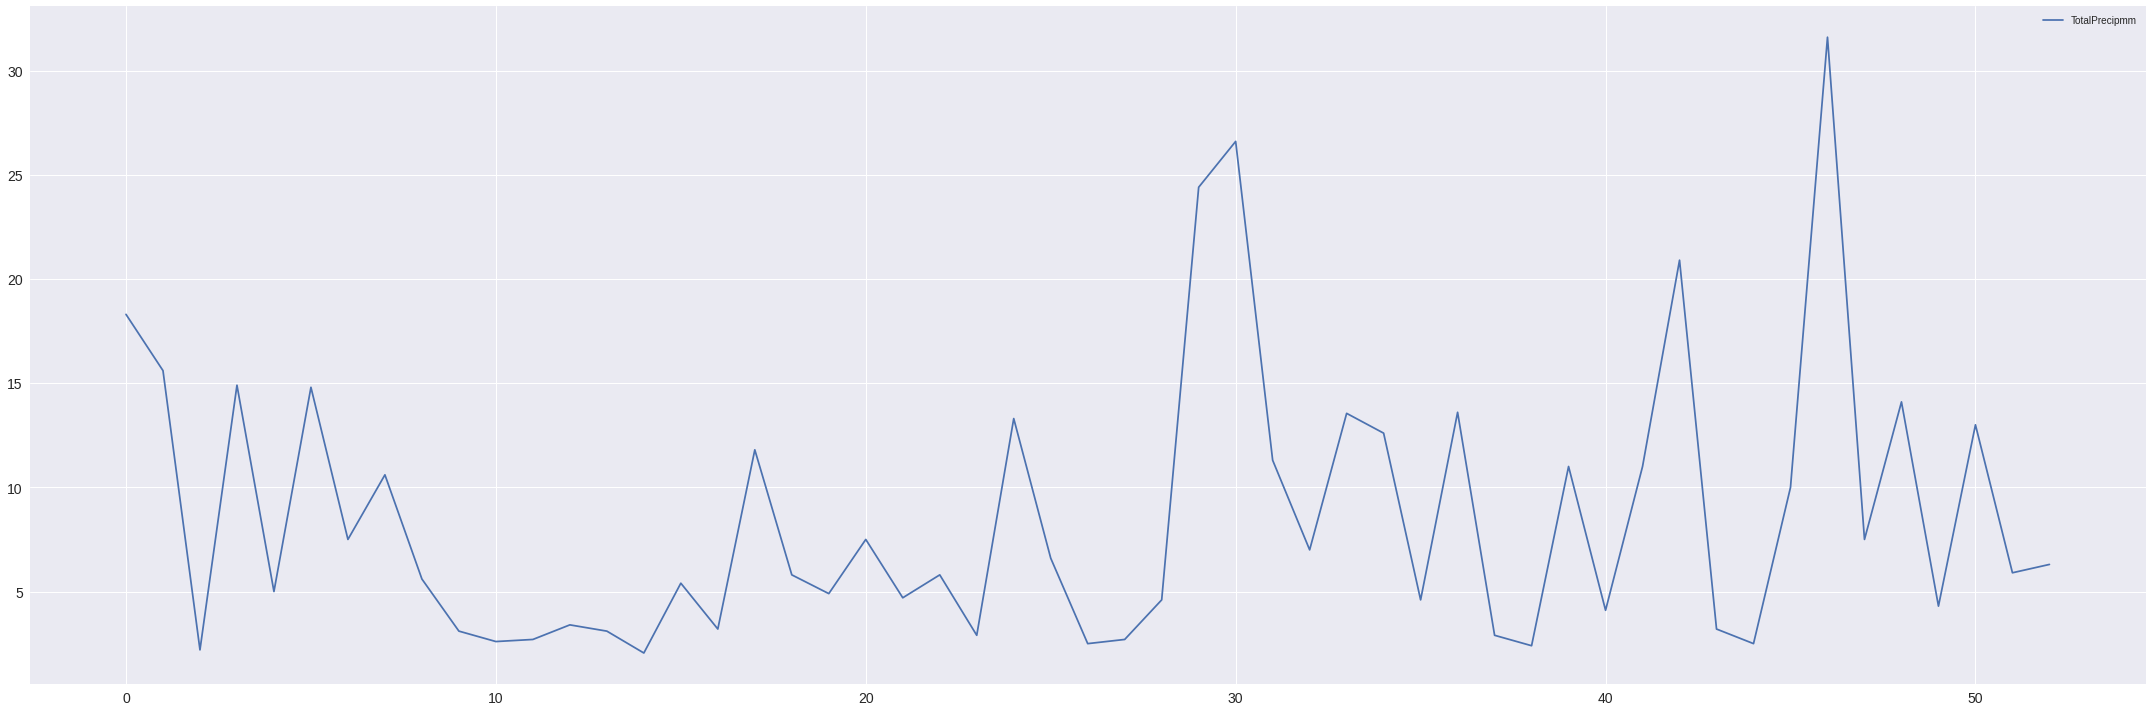

In [109]:
ax6 = NearZero_Precip.reset_index().plot(y='TotalPrecipmm',figsize=(30,10))

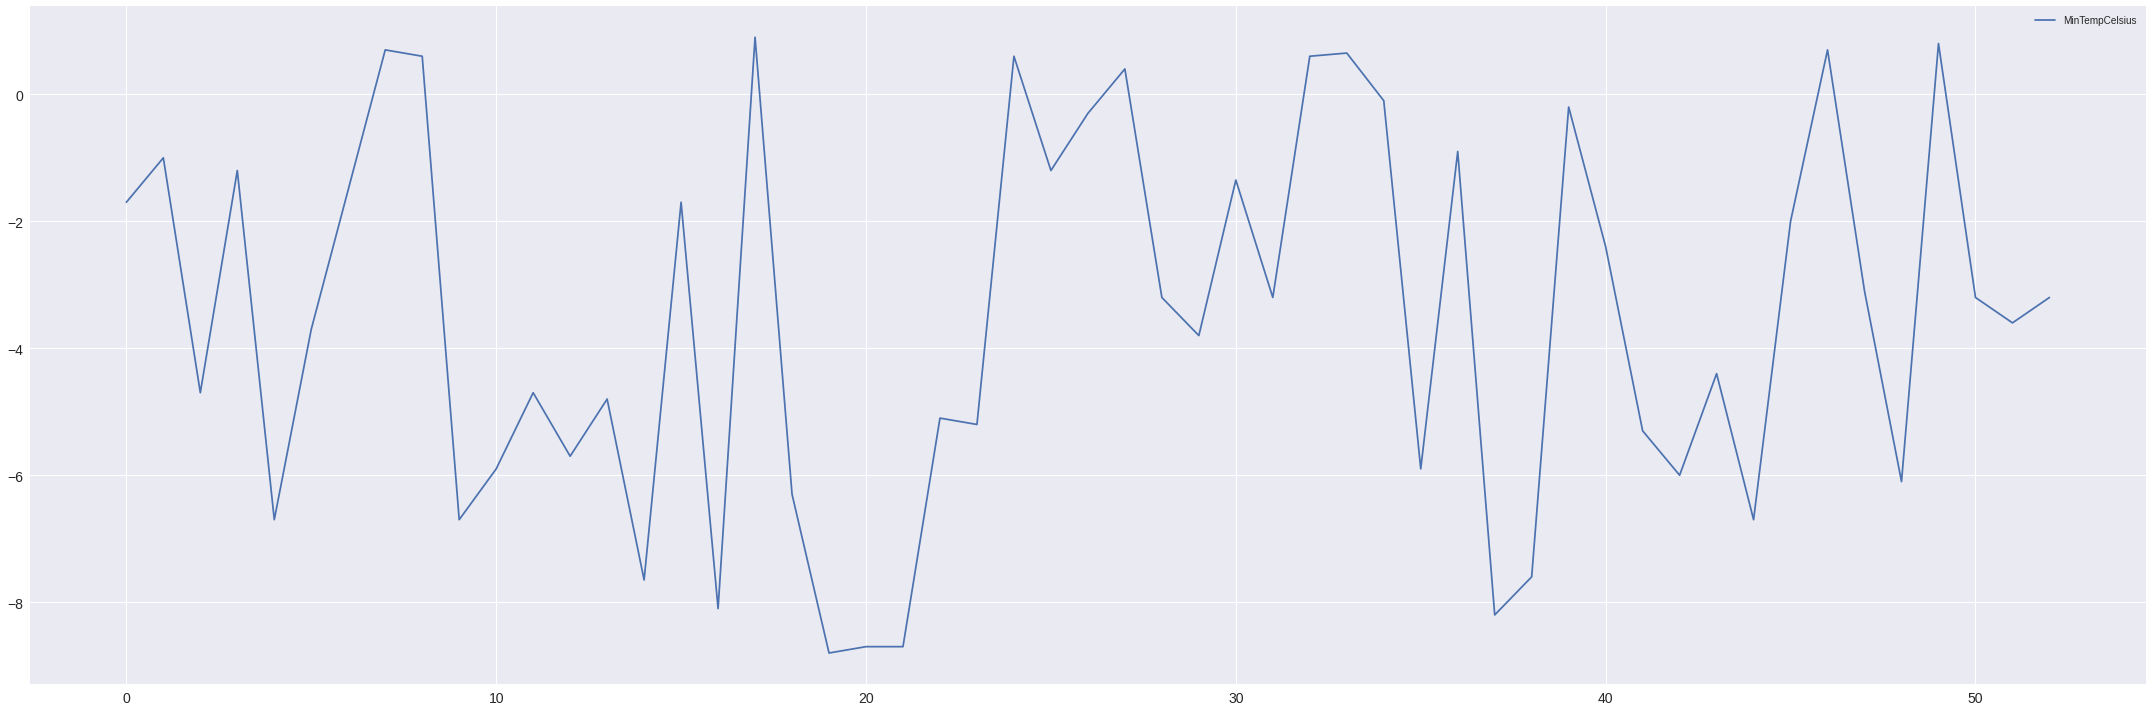

In [110]:
ax5 = NearZero_Precip.reset_index().plot(y='MinTempCelsius',figsize=(30,10))

In [111]:
# Apply multiple regression
from sklearn import linear_model
# here we have 2 variables for multiple regression.
X = NearZero_Precip[['TotalPrecipmm','MinTempCelsius']] 
Y = NearZero_Precip['OCCUPANCY']

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [112]:
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 3599.1671457718353
Coefficients: 
 [ 3.232691   -0.66748926]


In [113]:
import statsmodels.api as sm2

model = sm2.OLS(Y, X).fit()
predictions = model.predict(X) 

In [114]:
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:              OCCUPANCY   R-squared (uncentered):                   0.835
Model:                            OLS   Adj. R-squared (uncentered):              0.828
Method:                 Least Squares   F-statistic:                              128.8
Date:                Sun, 09 Aug 2020   Prob (F-statistic):                    1.16e-20
Time:                        20:55:06   Log-Likelihood:                         -462.01
No. Observations:                  53   AIC:                                      928.0
Df Residuals:                      51   BIC:                                      932.0
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------

In [115]:
# Strong R-squared & adjusted R-squared values, so there's correlation. A future study would
# delve deeper into the nature of the correlation and looking at the impact of the variables
# using either backward elimination or forward selection

<a href="https://colab.research.google.com/github/VernonNaidoo-Toronto/Understanding-Toronto-Shelters/blob/master/CPI_vs_Occupancy_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# CPI and Shelter Occupancy Analysis
---

In [116]:
%reset-f
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import sklearn
import scipy, scipy.stats
import statsmodels.formula.api as sm
from statsmodels.graphics.regressionplots import plot_regress_exog, plot_fit, plot_leverage_resid2, influence_plot
from random import randrange
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [117]:
# Take a random sample of x records from DataFrame y:
def sample(df,number_of_records):
  display(df.loc[np.random.choice(len(df),number_of_records),:])
  print(f'Random sample of {number_of_records} rows from DataFrame with {df.shape[0]} records and {df.shape[1]} columns.')

**Import Data**

In [118]:
path = 'https://raw.githubusercontent.com/VernonNaidoo-Toronto/Understanding-Toronto-Shelters/master/Shelter%20Data/'
dso2017 = pd.read_csv(path + 'daily-shelter-occupancy-2017-csv.csv', 
                    parse_dates=['OCCUPANCY_DATE']); dso2017['source_file']=2017
dso2018 = pd.read_csv(path + 'daily-shelter-occupancy-2018-csv.csv',
                    parse_dates=['OCCUPANCY_DATE']); dso2018['source_file']=2018
dso2019 = pd.read_csv(path + 'daily-shelter-occupancy-2019-csv.csv',
                    parse_dates=['OCCUPANCY_DATE']); dso2019['source_file']=2019

# Get summary of records loaded
for year, df in [[2017,dso2017], [2018,dso2018], [2019,dso2019]]:
  print(f'Loaded {len(df)} records from the {year} file.')

cpi_data = pd.read_csv(path + 'CPI_MONTHLY.csv', header=20, names=['date', 'CPI', 'CPI_adj', 'Static', 'CPI_TRIM', 
                                                      'CPI_MEDIAN', 'CPI_COMMON', 'ATOM', 'CPIXFET', 'CPIW'])

Loaded 38700 records from the 2017 file.
Loaded 37770 records from the 2018 file.
Loaded 39446 records from the 2019 file.


In [119]:
# Concatenate DataFrames
daily_shelter_occupancy = pd.concat([dso2017, dso2018, dso2019], ignore_index=True) 

# Get list of column names; change to Python standard lowercase:
cols = [column_name.lower() for column_name in daily_shelter_occupancy.columns] 
daily_shelter_occupancy.columns = cols

# Move source_file column to front of DataFrame
cols = cols[-1:] + cols[0:-1]
daily_shelter_occupancy = daily_shelter_occupancy[cols]

# Show sample records
sample(daily_shelter_occupancy,5)

source_file    _id occupancy_date  ... sector occupancy capacity
83111          2019   6642     2019-03-04  ...  Women        39     40.0
14993          2017  14994     2017-05-21  ...    Men         0      0.0
76763          2019    294     2019-01-03  ...    Men        18     18.0
112342         2019  35873     2019-11-30  ...  Youth        50     50.0
84311          2019   7842     2019-03-15  ...  Women        37     37.0

[5 rows x 14 columns]

Random sample of 5 rows from DataFrame with 115916 records and 14 columns.


**Data cleaning**

In [120]:
# Identify columns with missing values:
for col in daily_shelter_occupancy.columns:
  null_count = daily_shelter_occupancy[col].isna().sum()
  if null_count >0:
    print(f'The {col} column has {null_count} rows without values.')

The shelter_postal_code column has 5494 rows without values.
The capacity column has 343 rows without values.


In [121]:
# Drop 343 rows with null capacity
original_row_count=daily_shelter_occupancy.shape[0]
daily_shelter_occupancy.dropna(subset=['capacity'], inplace=True)
dropped_row_count=original_row_count-daily_shelter_occupancy.shape[0]
print(f'Dropped {dropped_row_count} of {original_row_count} rows, due to nulls in capacity column.')

Dropped 343 of 115916 rows, due to nulls in capacity column.


**Prepare and align data**

In [122]:
# After removing nulls, change capacity column to integer
daily_shelter_occupancy.capacity = daily_shelter_occupancy.capacity.astype(int)

daily = daily_shelter_occupancy.set_index('occupancy_date')\
  .resample('D')[['occupancy','capacity']].sum()
daily['vacancy']=daily.capacity - daily.occupancy
daily['occupancy_rate']=daily.occupancy/daily.capacity*100
# monthly average occupancy
monthly = daily.resample('M')[['occupancy','capacity','vacancy']].mean()

monthly_df = monthly.reset_index()
# reformat shelter period 
monthly_df['year_month']=pd.to_datetime(monthly_df['occupancy_date']).dt.to_period('M')
# reformat CPI period
cpi_data['year_month']=pd.to_datetime(cpi_data['date']).dt.to_period('M')

# align CPI time with occupancy based on occupancy time
df = monthly_df.set_index('year_month').join(cpi_data.set_index('year_month'), lsuffix='_gas', rsuffix='_oil')
df.head()

occupancy_date    occupancy     capacity  ...  ATOM CPIXFET  CPIW
year_month                                           ...                    
2017-01        2017-01-31  4548.096774  4863.419355  ...   1.7     2.1   1.5
2017-02        2017-02-28  4598.750000  4896.428571  ...   1.7     2.0   1.5
2017-03        2017-03-31  4664.612903  4901.838710  ...   1.3     1.6   1.1
2017-04        2017-04-30  4778.466667  5032.666667  ...   1.1     1.5   1.0
2017-05        2017-05-31  4827.967742  5078.677419  ...   0.9     1.3   0.7

[5 rows x 14 columns]

**Time Series plots**

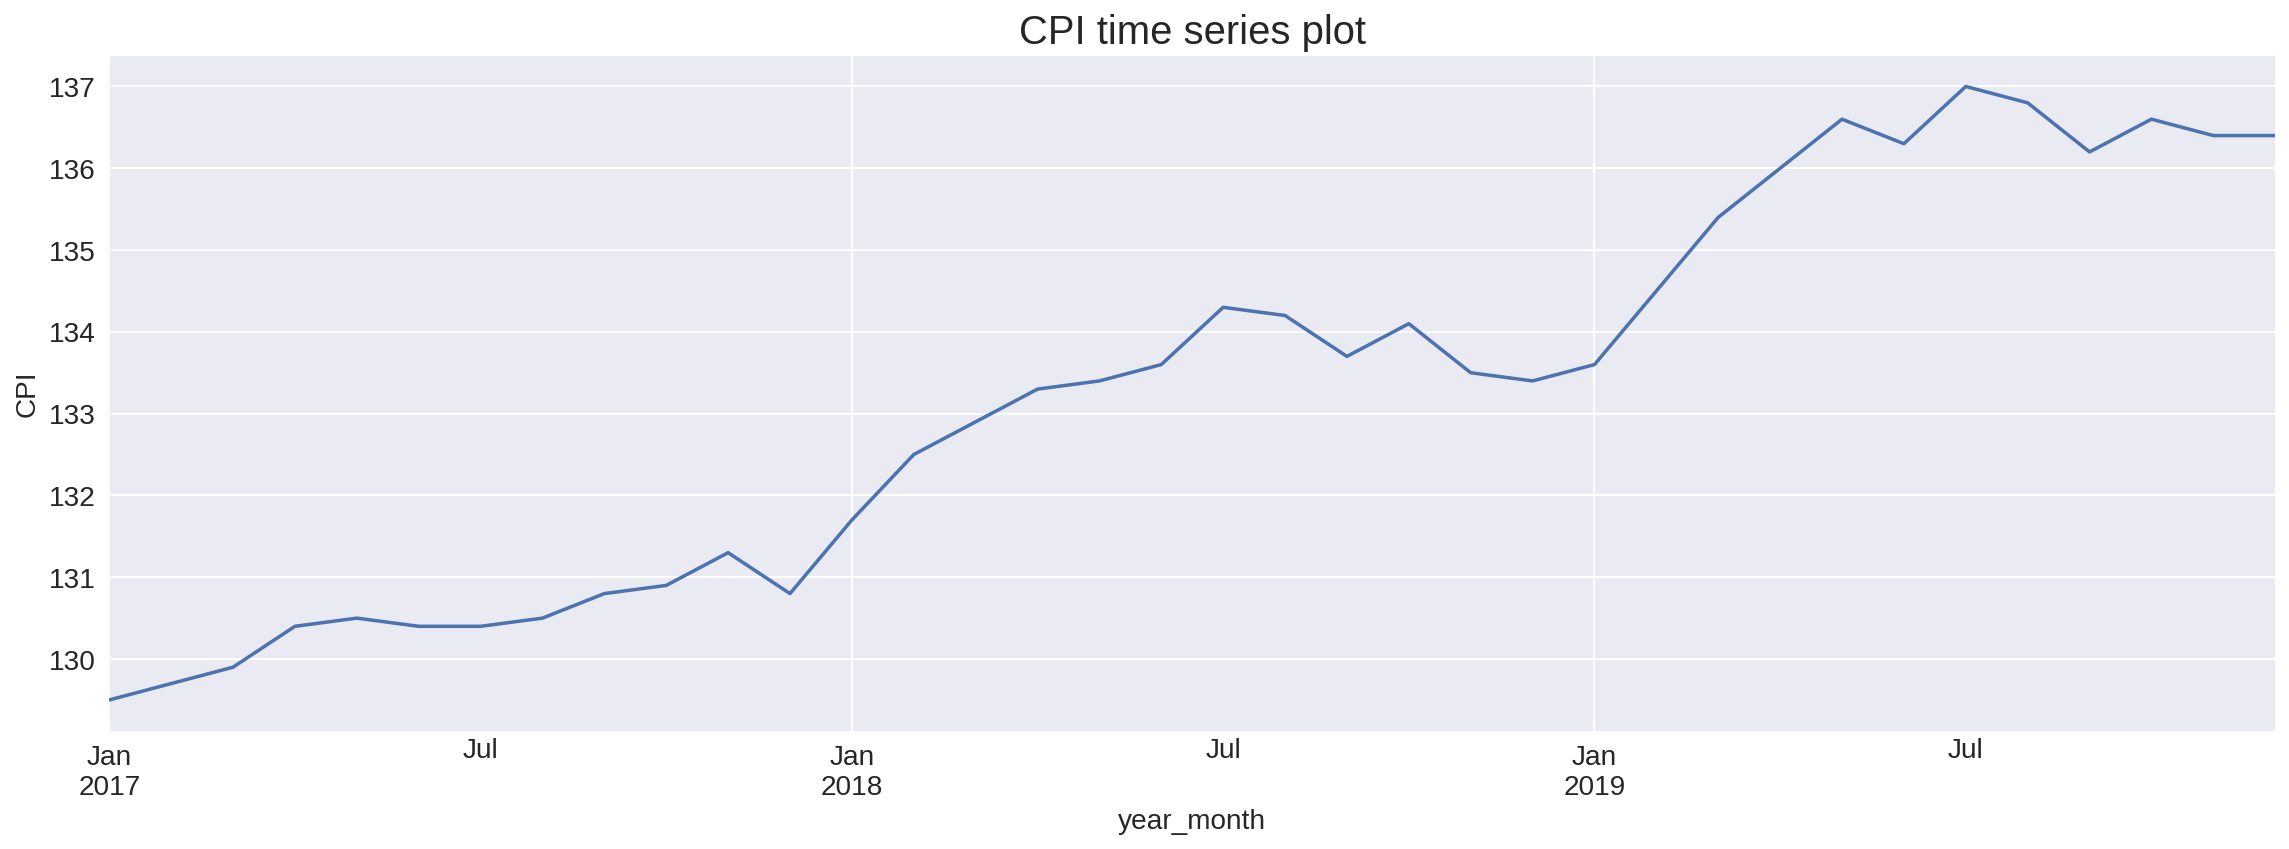

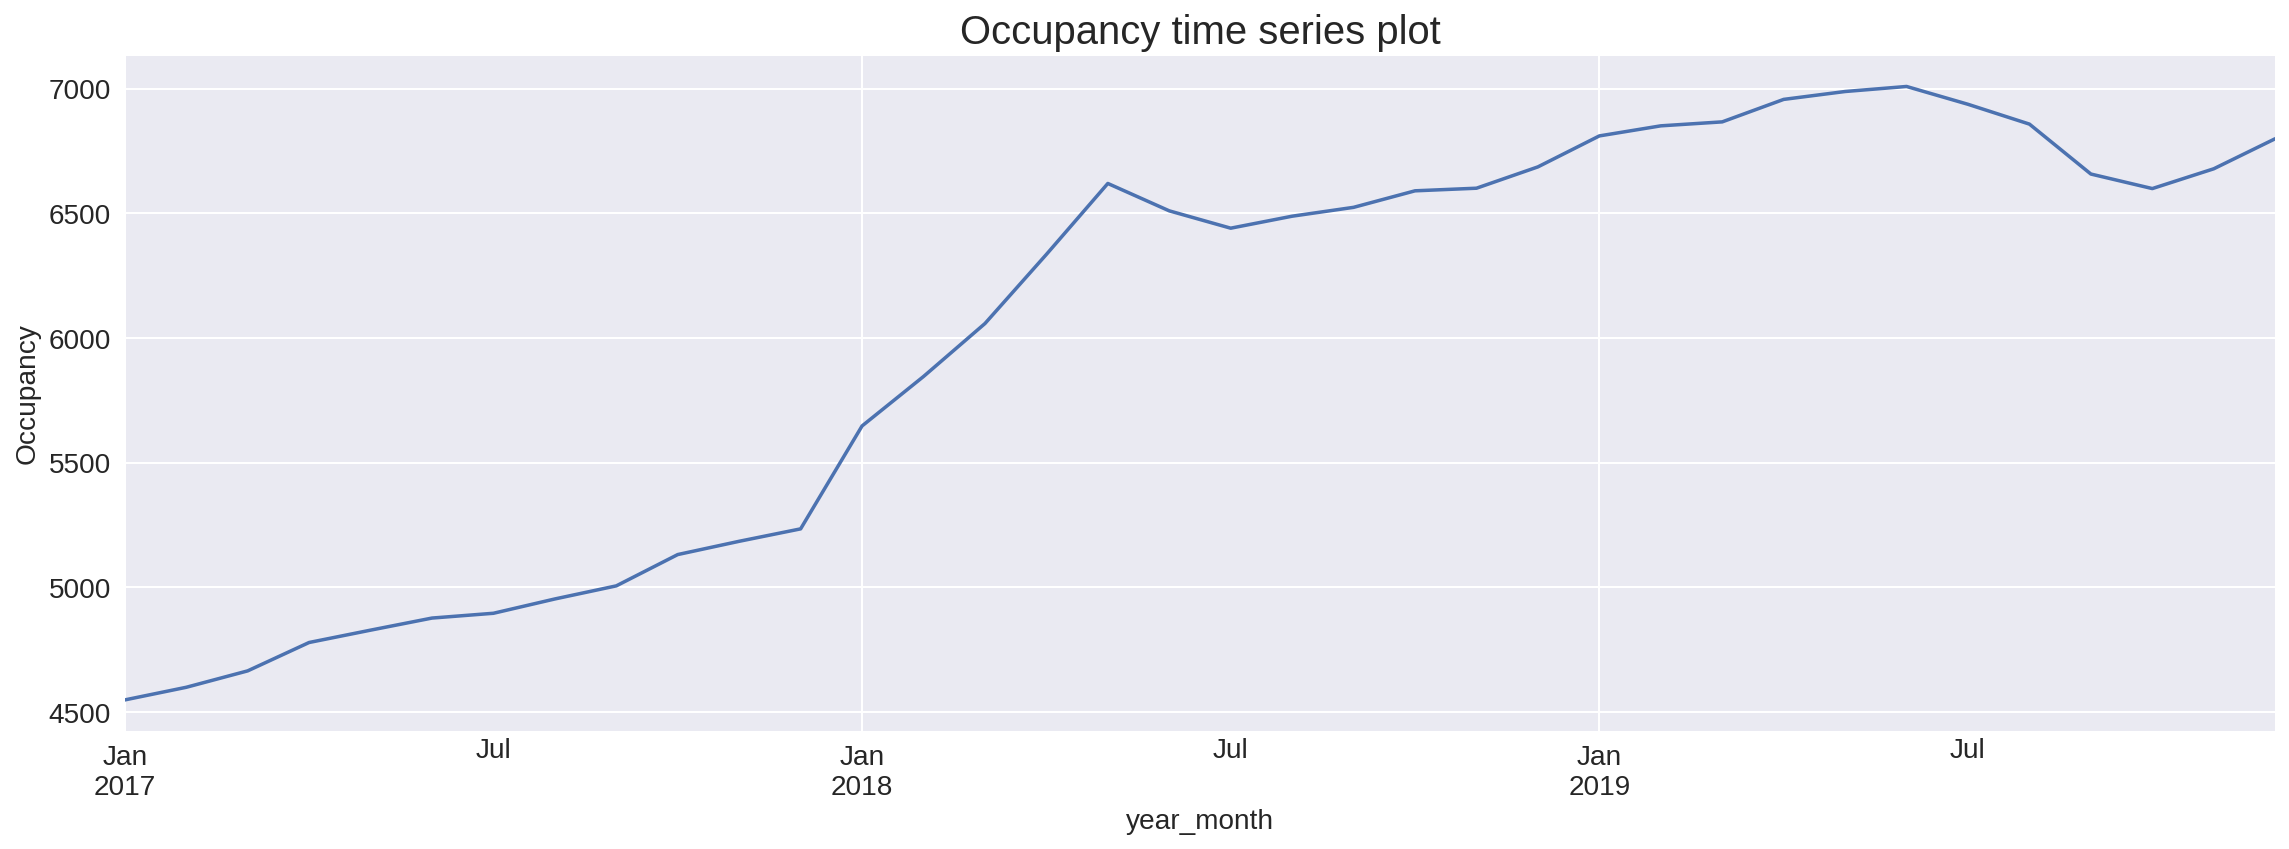

In [123]:
plt.figure();
df.CPI.plot(grid=True);
plt.ylabel('CPI');
plt.title('CPI time series plot');
plt.figure();
df.occupancy.plot(grid=True);
plt.ylabel('Occupancy');
plt.title('Occupancy time series plot');

From time series plots both occupancy and CPI data trends together from Jan 2017 to Jan 2019 after which occupancy data slope changed and trend slowed down as CPI continued to trend up.  

**Scatter plot of Occupancy vs CPI and correlation**

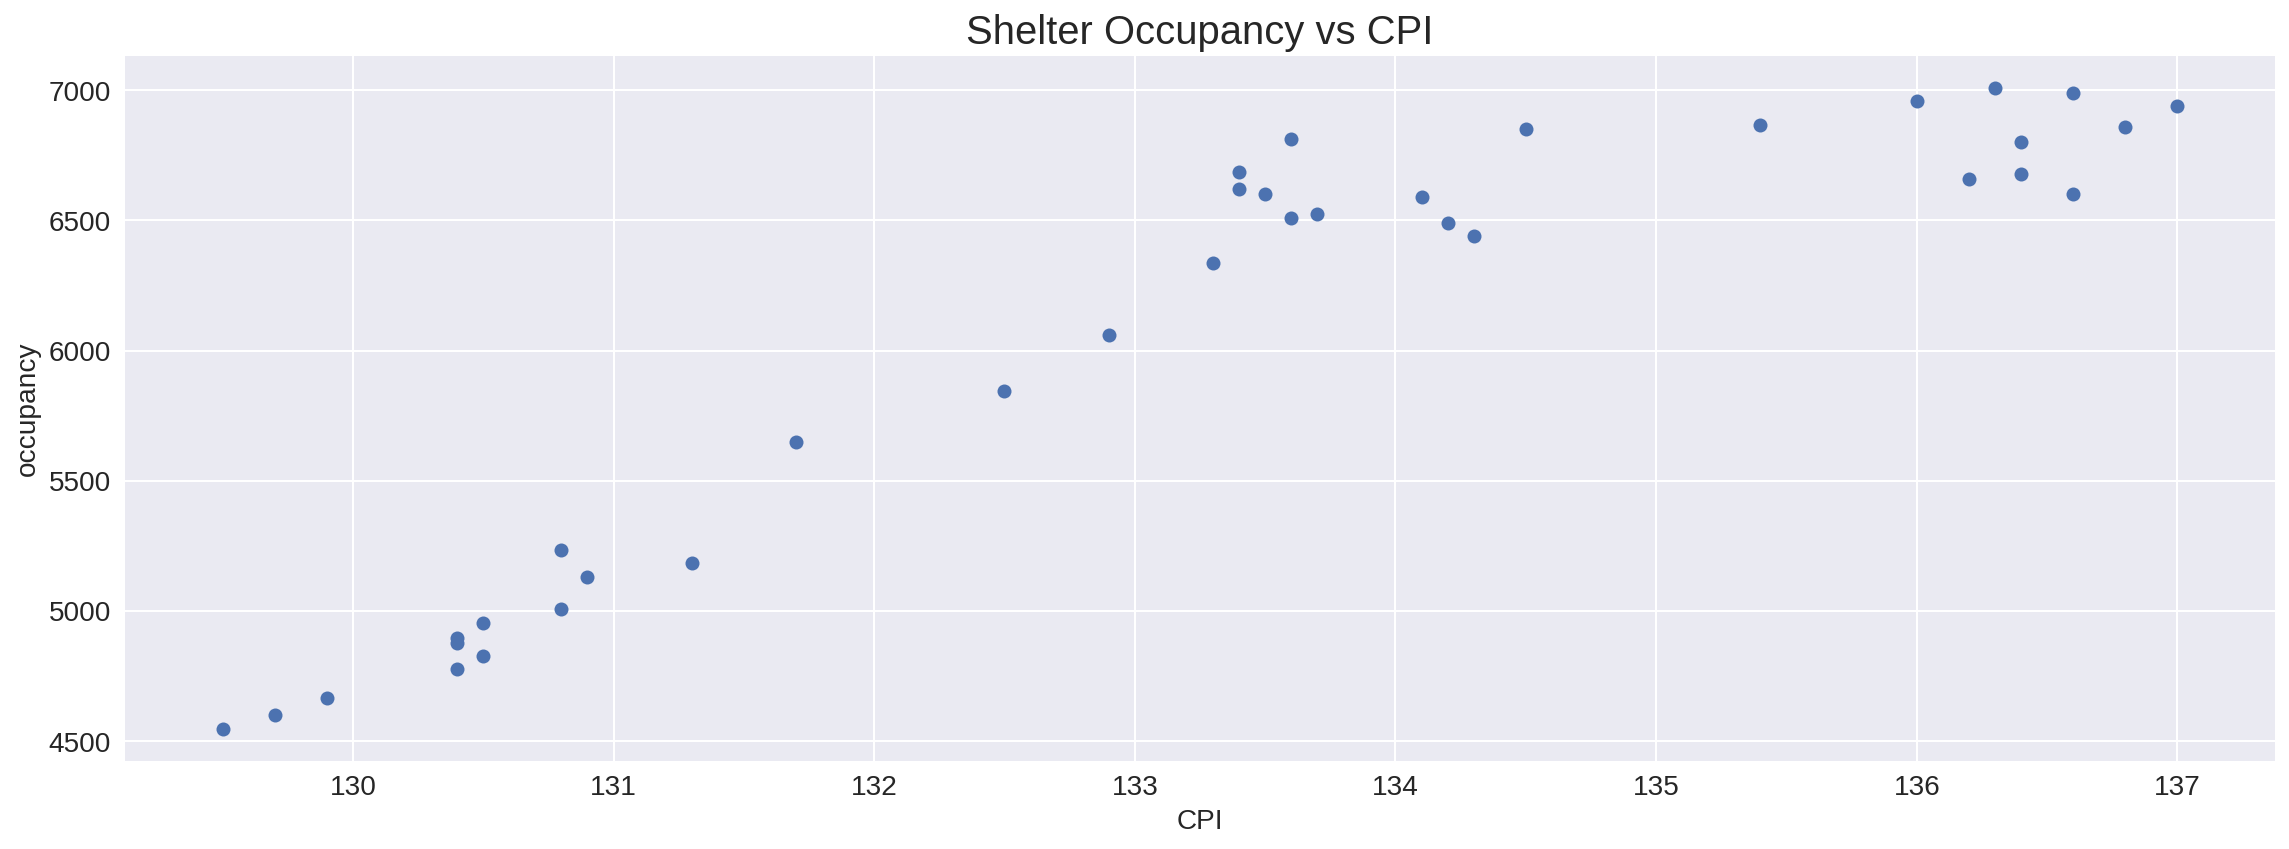

In [124]:
df2 = df.reset_index()
data = df2[['occupancy', 'CPI']]
plt.plot(data.CPI, data.occupancy, 'o', label = 'Observations');
plt.xlabel('CPI');
plt.ylabel('occupancy');
plt.title('Shelter Occupancy vs CPI');

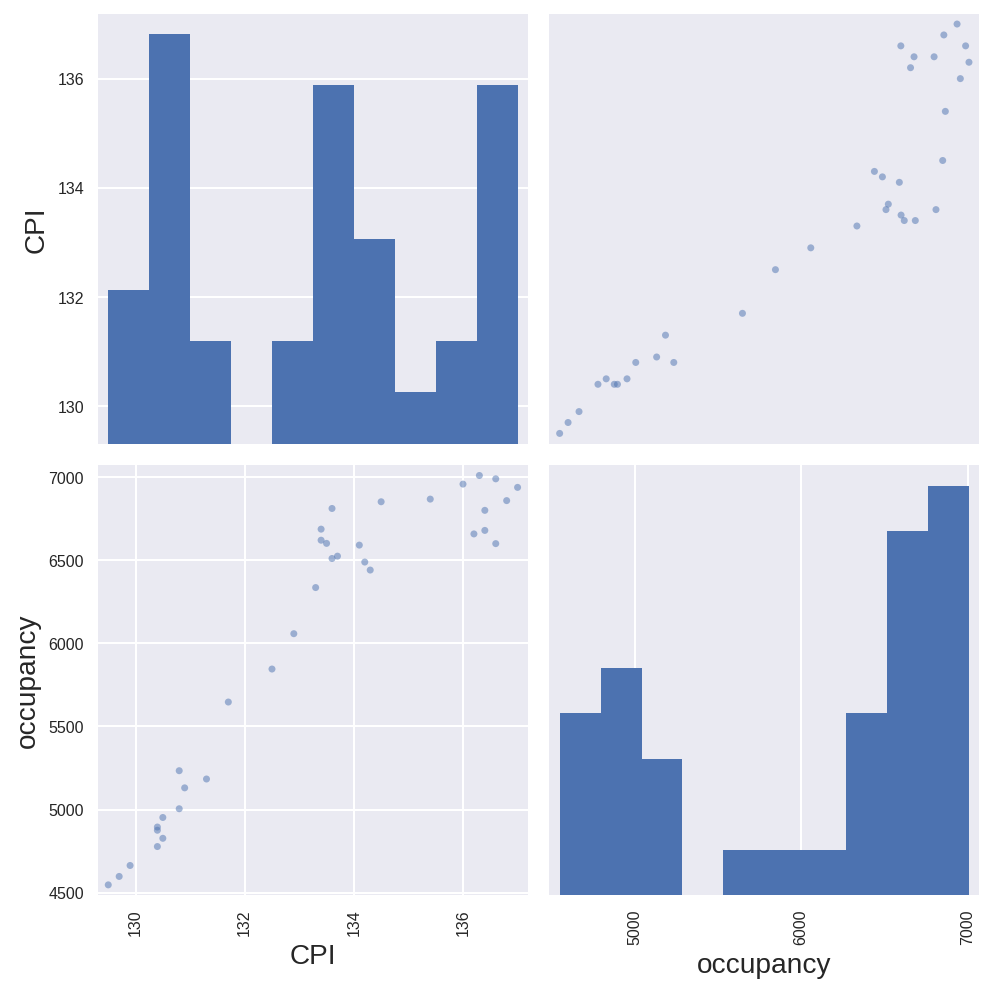

In [125]:
pd.plotting.scatter_matrix(data[['CPI', 'occupancy']], figsize= (7,7));

In [126]:
data[['CPI', 'occupancy']].corr()

CPI  occupancy
CPI        1.000000   0.932466
occupancy  0.932466   1.000000

From scatter plot and correlation analysis we can see there is a strong correlation between CPI and occupancy. Similar to what we oberved previously in the time series plot the slope of linear relationship changes suddenly at values of CPI > 135. If we try to model occupancy using CPI as predictor and since both are time series data we need to exclude sudden changes and build a model to predict the gradual change. In the next section we use linear regression to model occupancy with CPI.

**Linear Regression Analysis**

Let us first try to fit a linear model to the data without any transformation and/or removal of outliers. OLS from statsmodels is used to perform this analysis

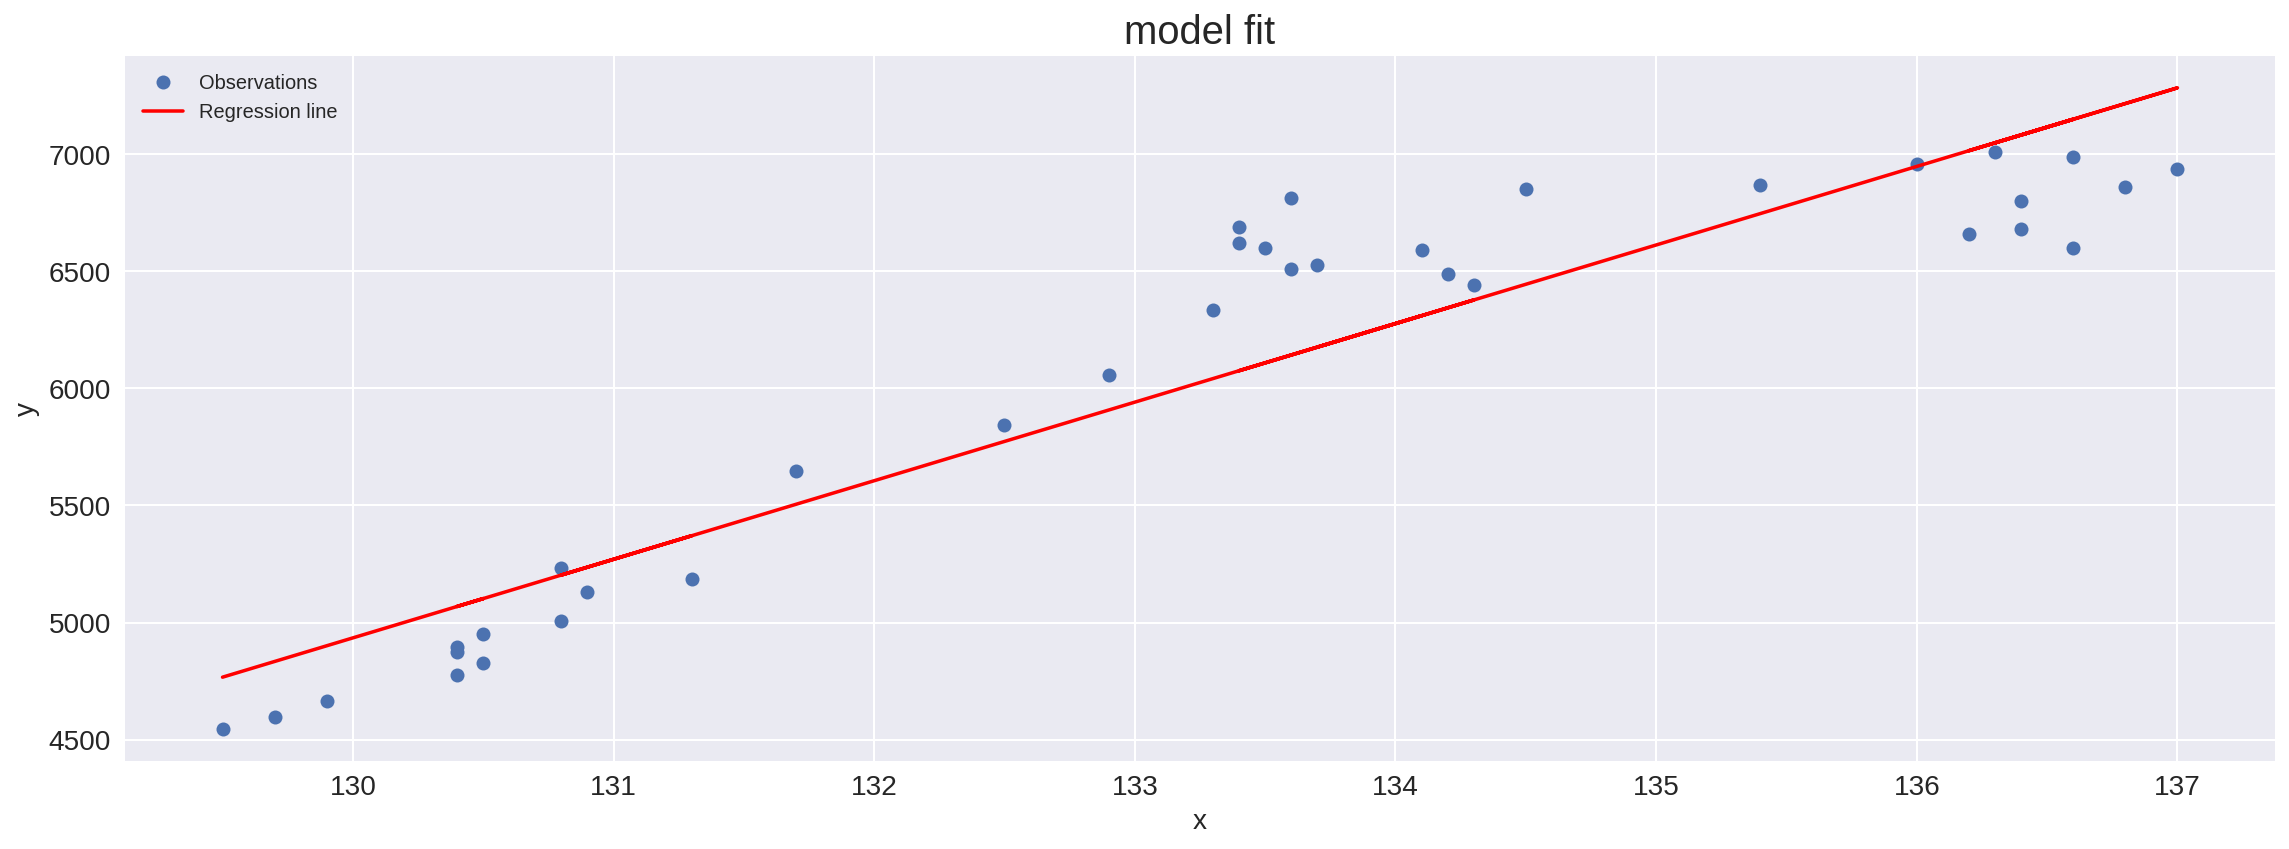

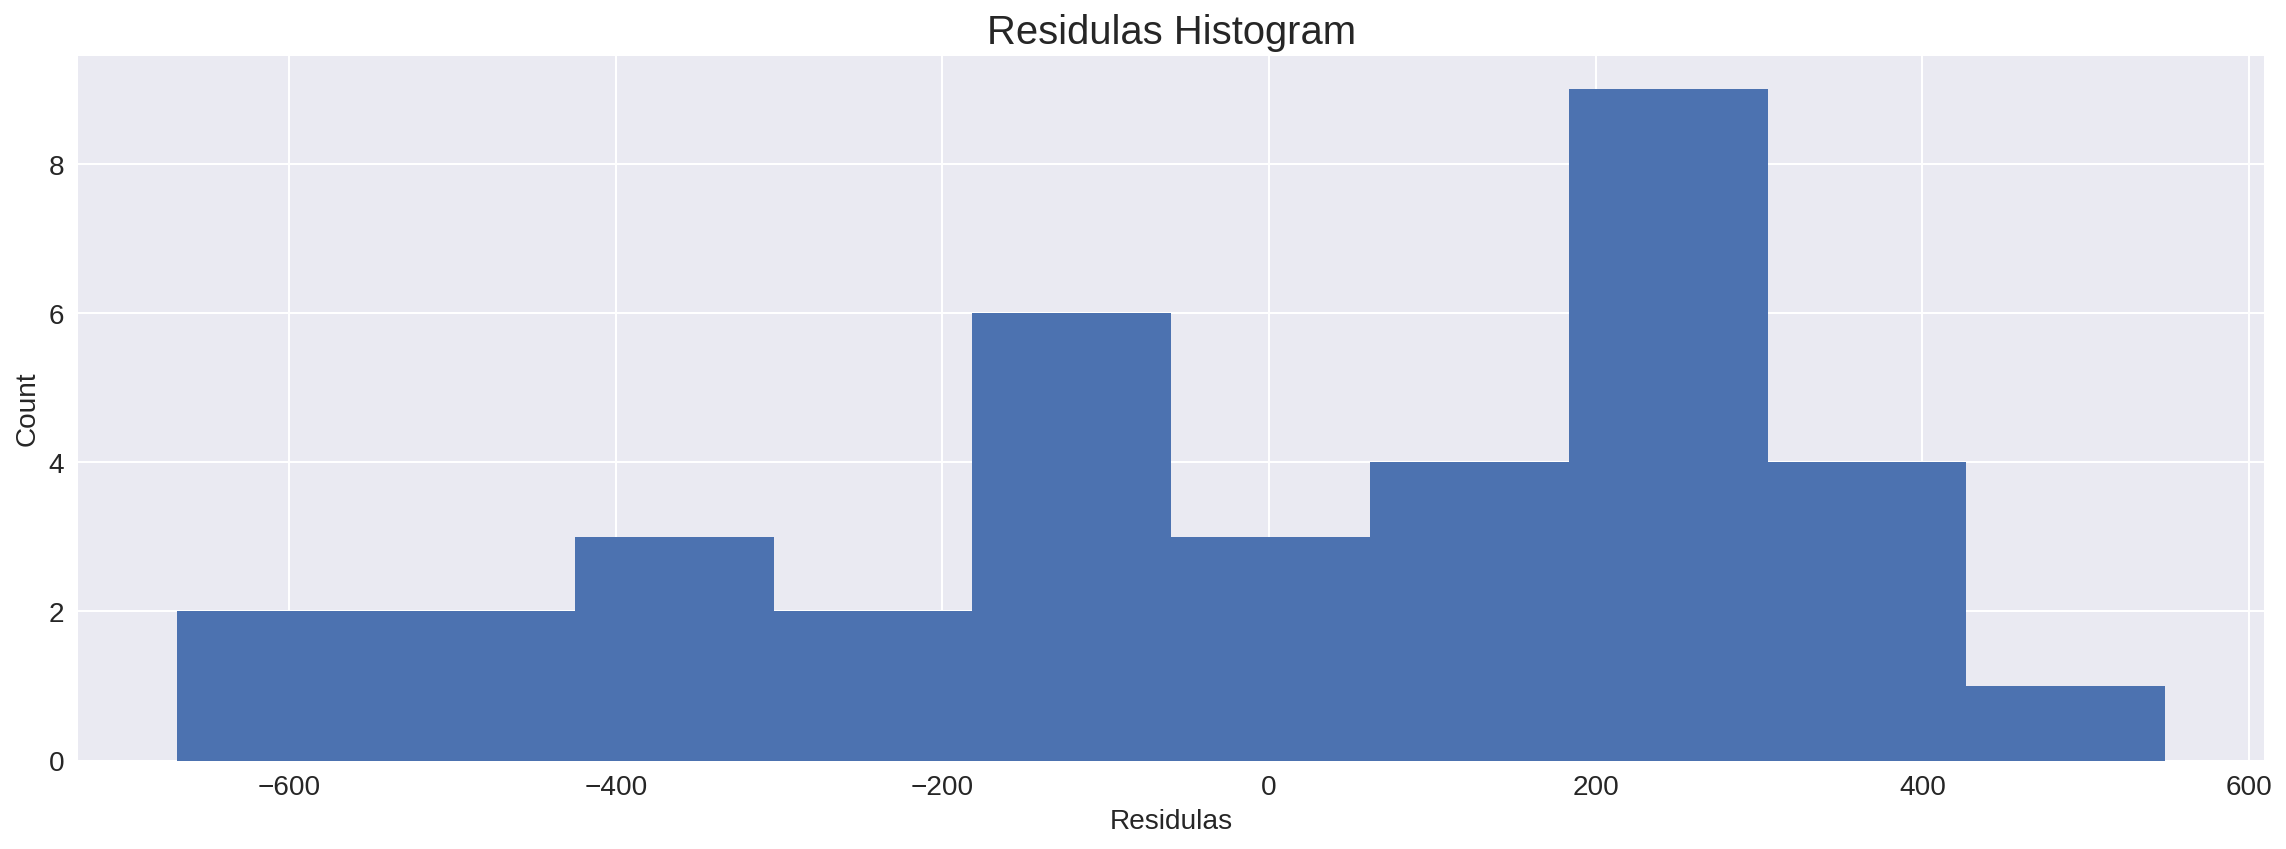

Model Residuals
count    3.600000e+01
mean    -1.952887e-11
std      3.149688e+02
min     -6.684421e+02
25%     -1.830398e+02
50%      7.202937e+01
75%      2.359488e+02
max      5.486369e+02
Name: Residuals, dtype: float64
                            OLS Regression Results                            
Dep. Variable:              occupancy   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     226.5
Date:                Sun, 09 Aug 2020   Prob (F-statistic):           1.34e-16
Time:                        20:55:12   Log-Likelihood:                -257.66
No. Observations:                  36   AIC:                             519.3
Df Residuals:                      34   BIC:                             522.5
Df Model:                           1                                         
Covariance Type:            nonrobust                            

In [127]:
m = sm.ols('occupancy ~ CPI', data = data)
m = m.fit()
intercept, slope = m.params
data['y_est'] = intercept + slope * data.CPI

# Calculate the residuals
data['Residuals'] = data['y_est'] - data['occupancy']

plt.plot(data.CPI, data.occupancy, 'o', label = 'Observations')
plt.xlabel('x')
plt.ylabel('y')
plt.title('model fit')

# Plot regression line
plt.plot(data.CPI, data.y_est, 'r-', label='Regression line')

# Add legend
plt.legend()
plt.show()

# We will plot the histogram of the residuals first
plt.hist(data.Residuals)

# Add axes labels
plt.xlabel('Residulas')
plt.ylabel('Count')
plt.title('Residulas Histogram')
plt.show()

# And we will print the statistical summary of the residuals,
# i.e. (median, mean, quartiles, etc.)
print('Model Residuals')
print(data['Residuals'].describe())
print('=========================')
# Print model summary 
print(m.summary())

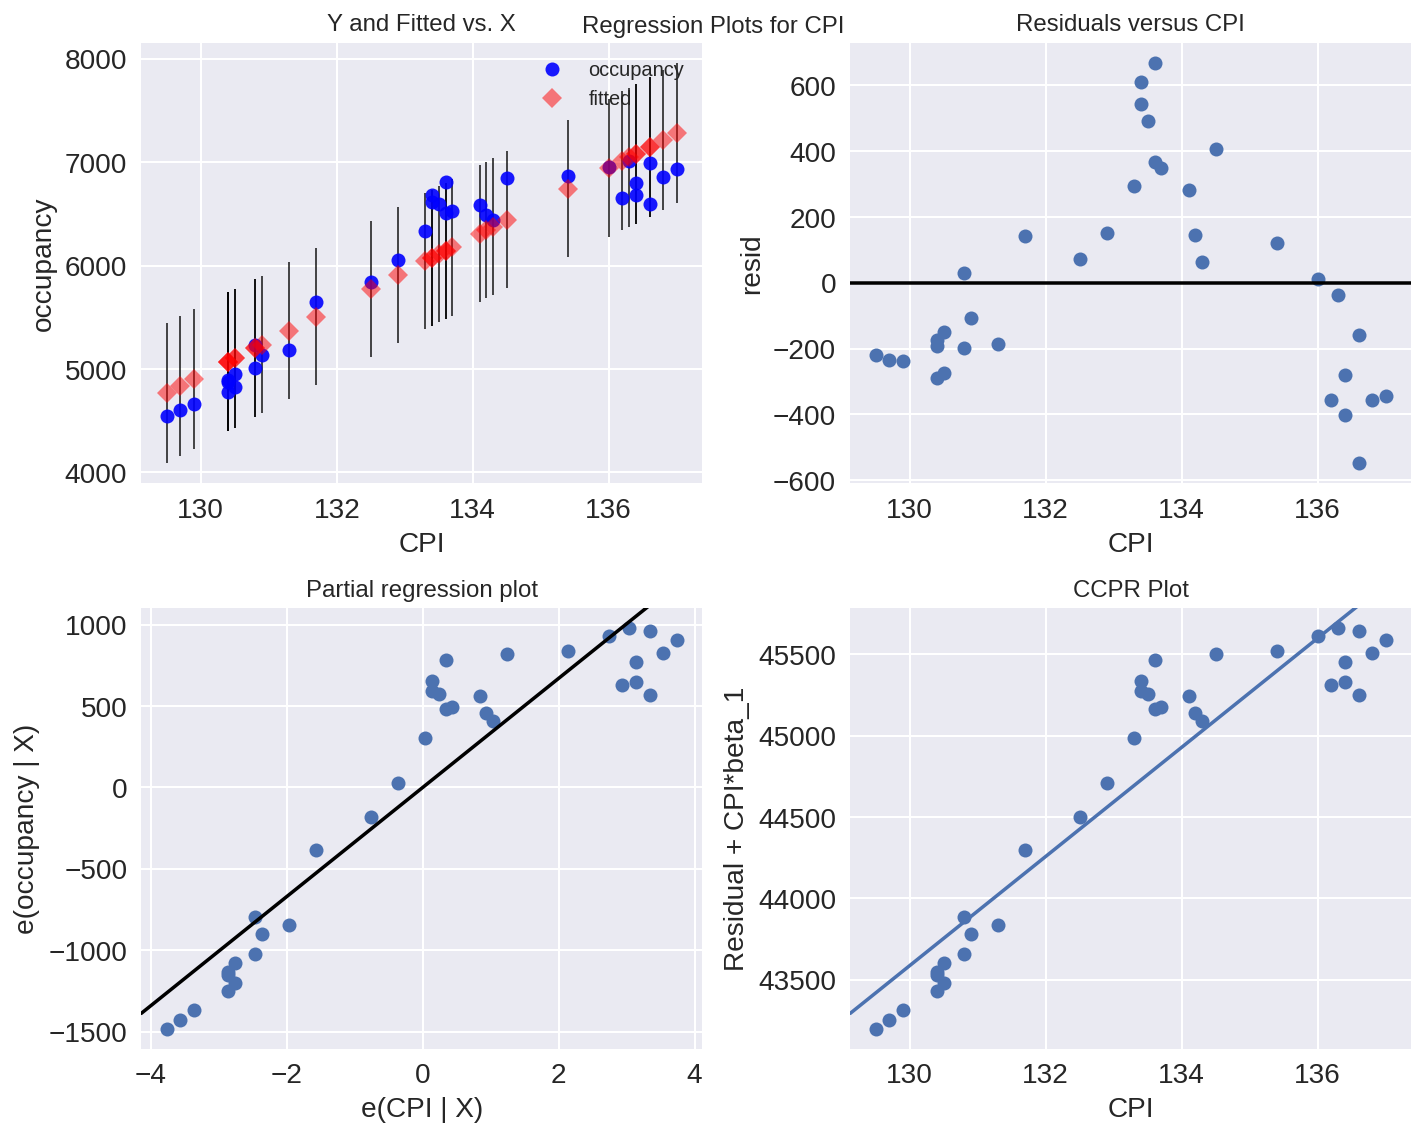

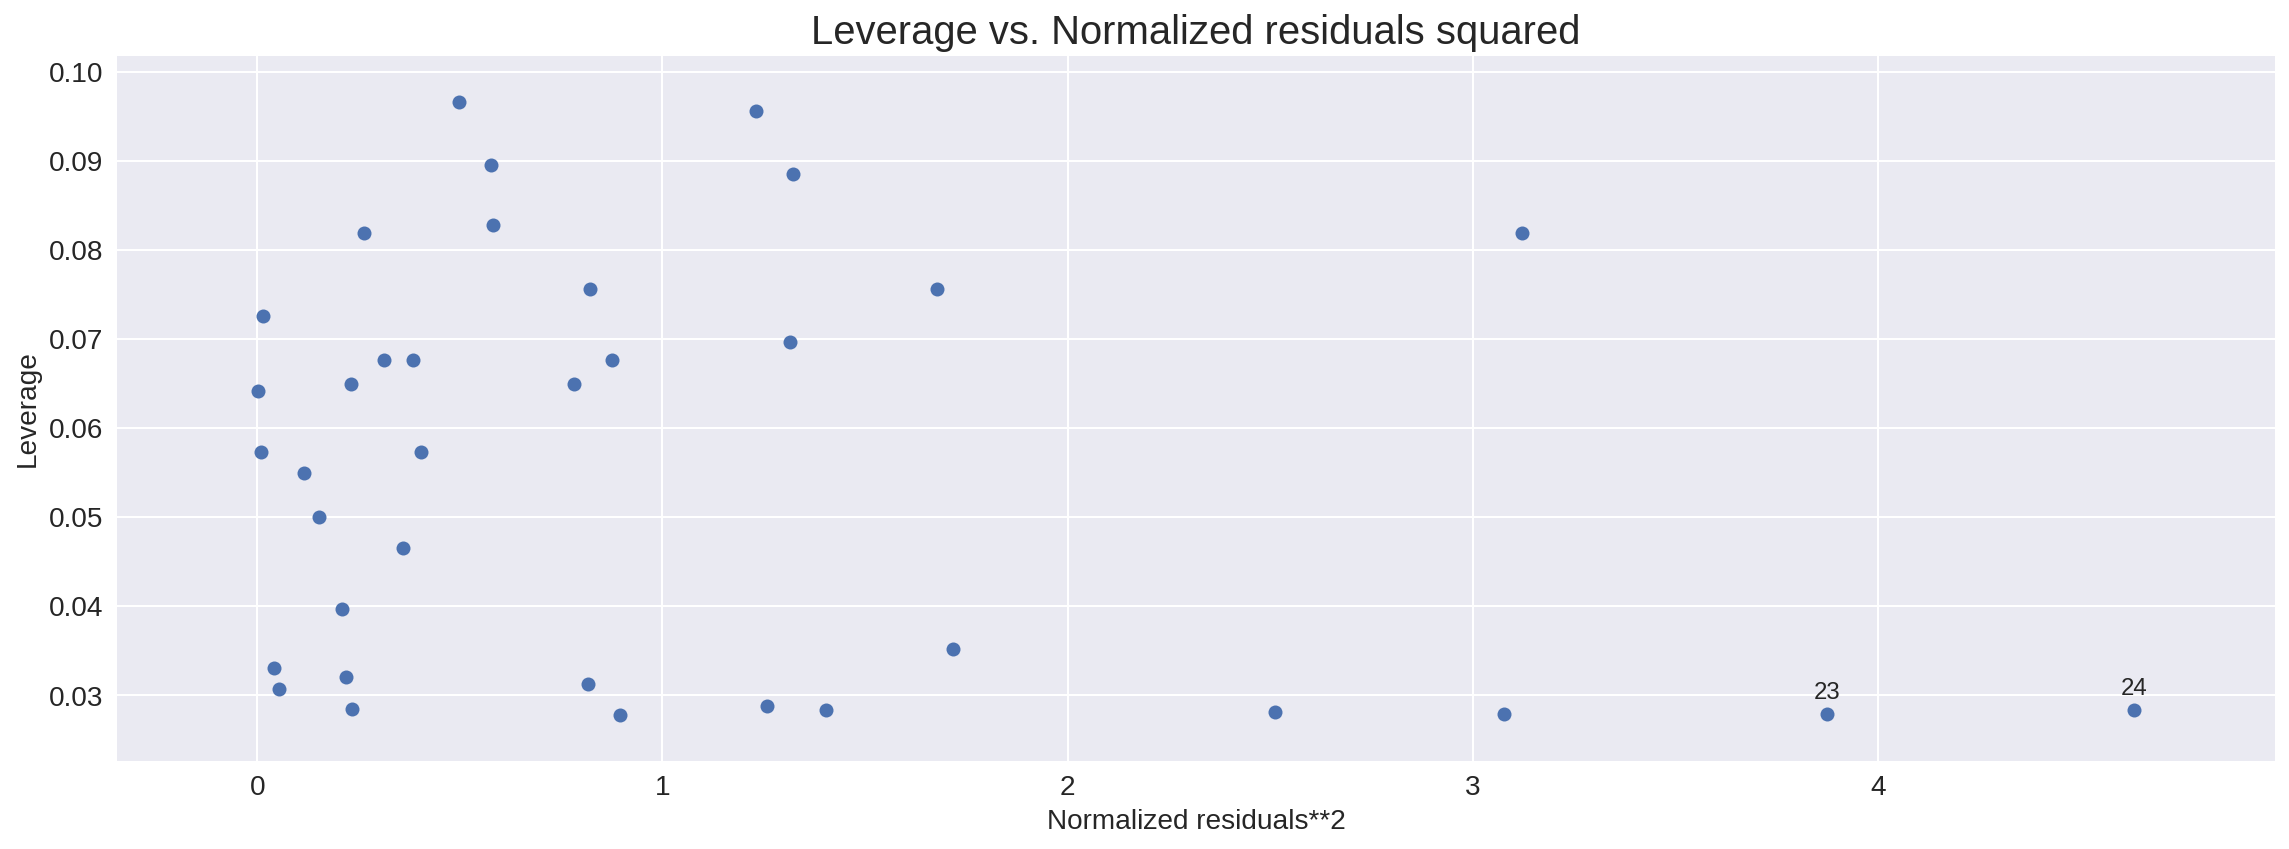

In [128]:
fig = plt.figure(figsize=(10,8))
fig = plot_regress_exog(m, "CPI", fig = fig)
fig = plot_leverage_resid2(m)

Overall the OLS results are reasonable with good fit in terms of R-squared overall p value and significance of the model parameters with small p-values. However, as we discussed earlier regarding the sudden change in model slope beyond CPI values of 135 we can observe that from the trend between the model residuals and CPI that is clear at values of CPI>135. Next, we try to exclude the last portion of data where the sudden slope change is observed and repeat the analysis

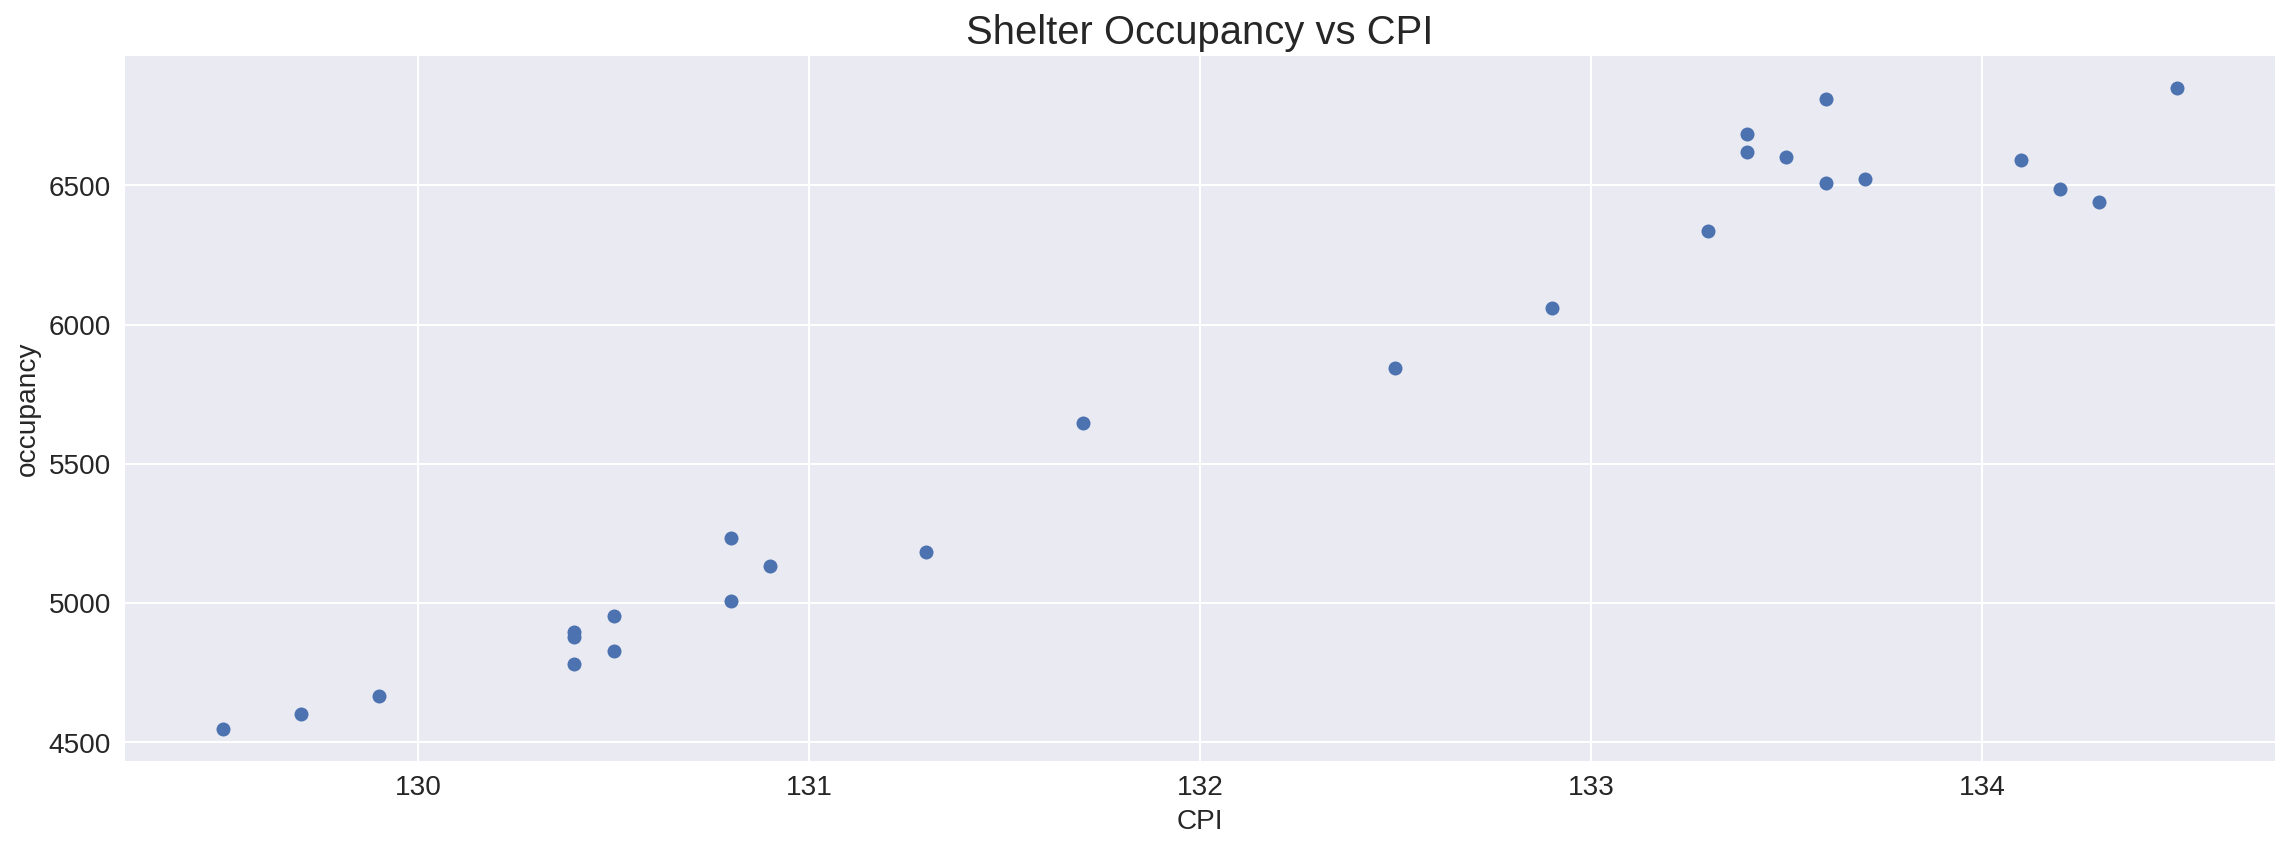

In [129]:
x = data.CPI.shift(10);
y = data.occupancy.shift(10);
plt.plot(x, y, 'o', label = 'Observations');
plt.xlabel('CPI');
plt.ylabel('occupancy');
plt.title('Shelter Occupancy vs CPI');

As we excluded the data that shown a sudden change in slope we can see now a linear model could be improved if we run OLS again 

In [130]:
x.dropna(inplace=True)
y.dropna(inplace=True)

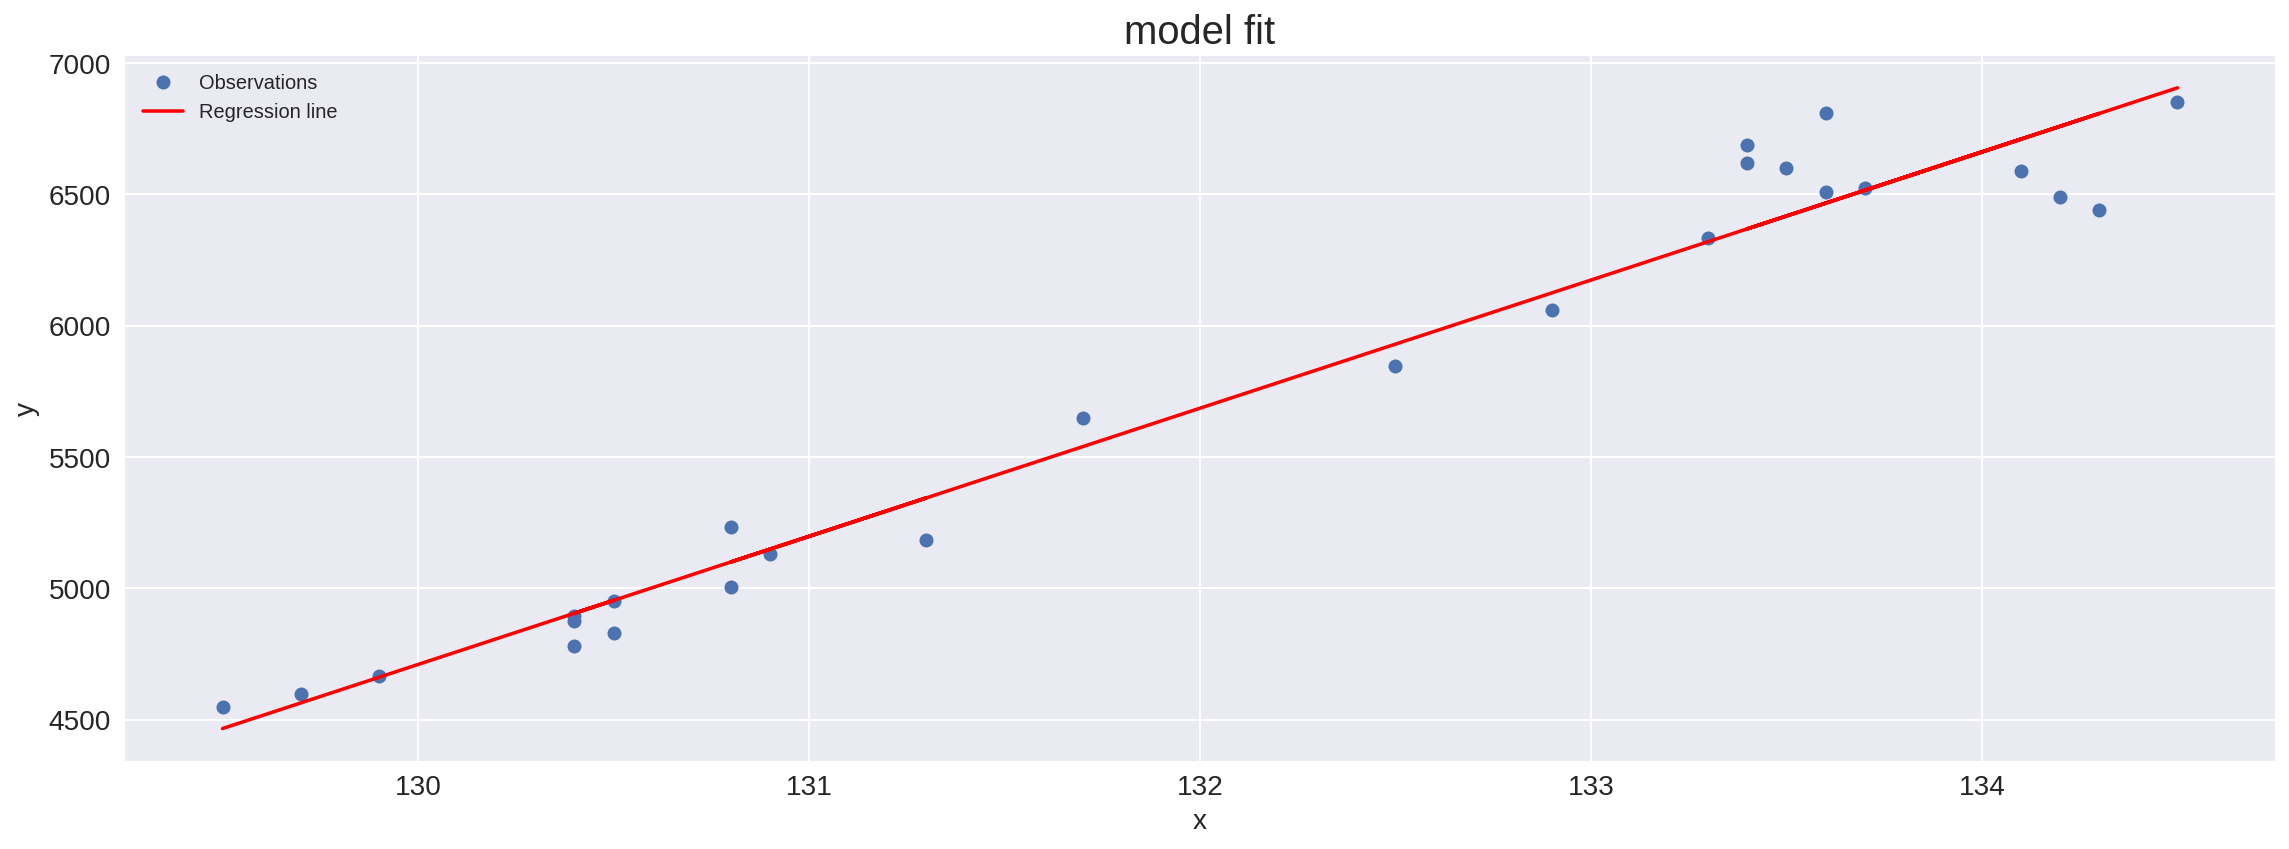

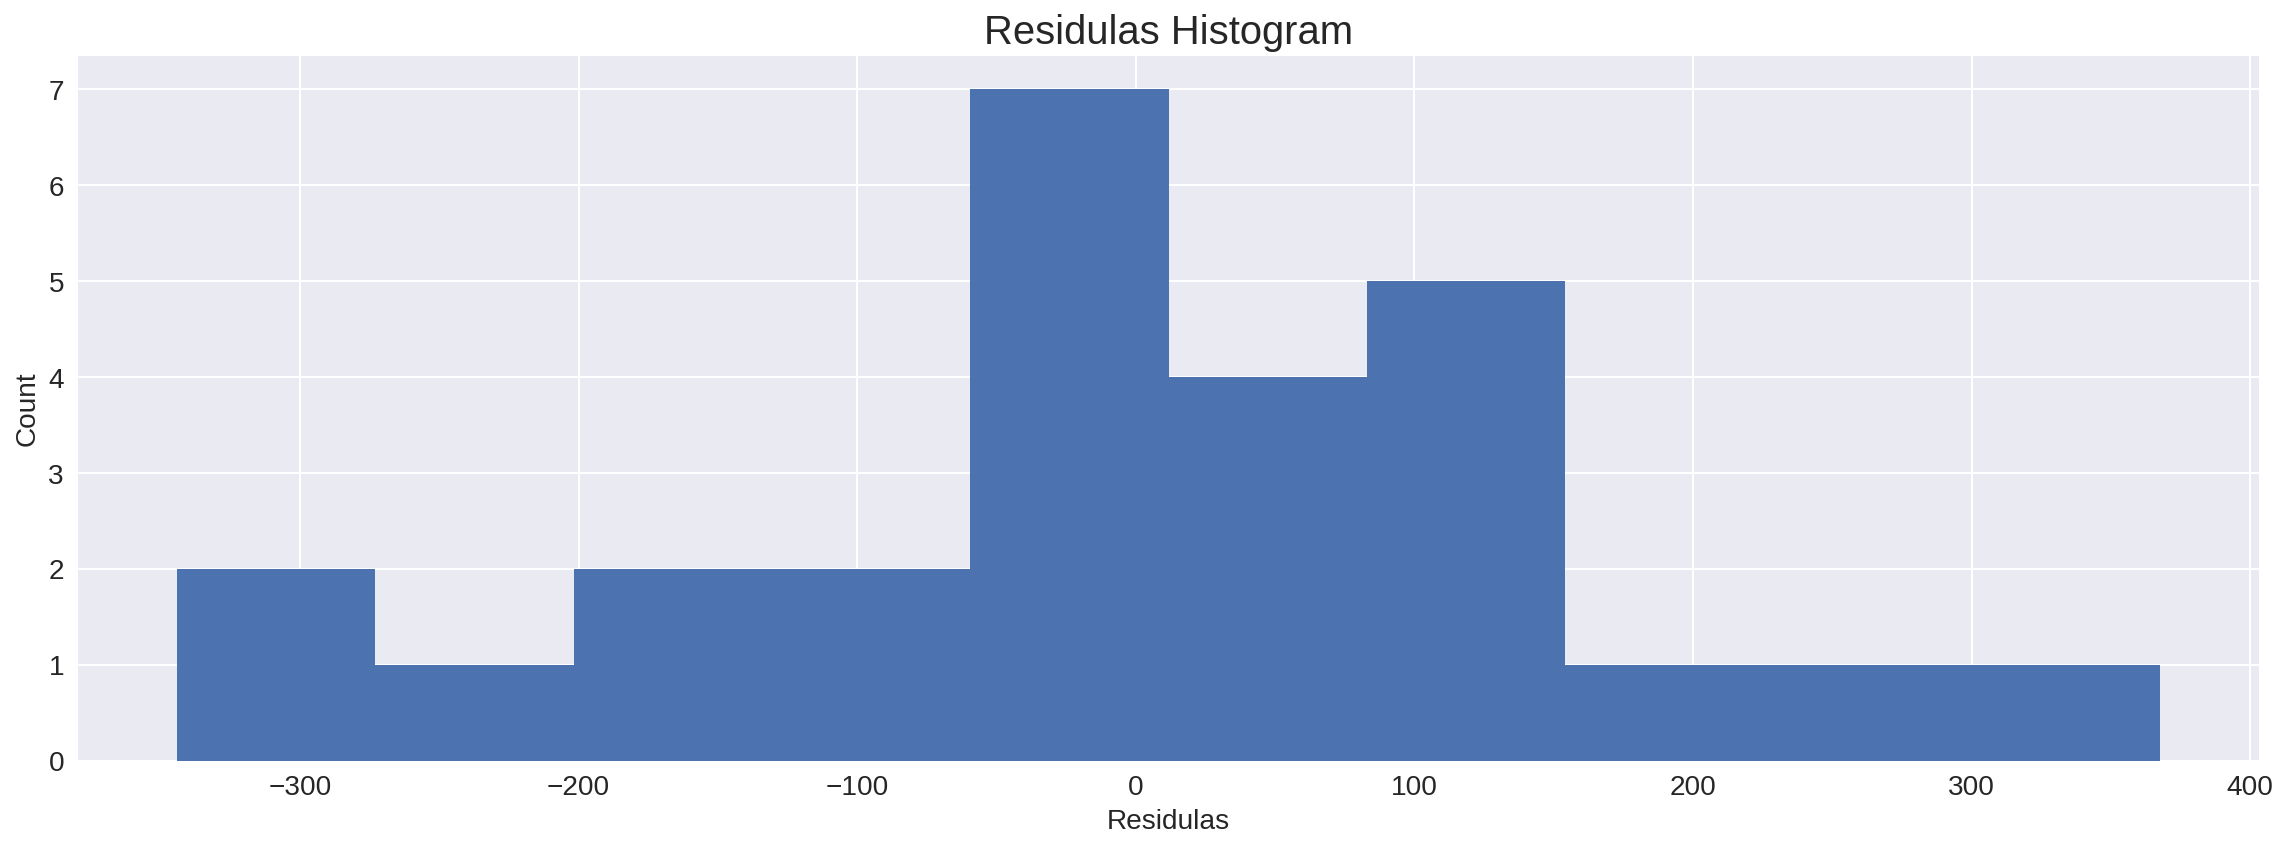

Model Residuals
count    2.600000e+01
mean    -8.570239e-12
std      1.625292e+02
min     -3.440669e+02
25%     -7.266513e+01
50%      4.889196e+00
75%      9.188056e+01
max      3.676418e+02
Name: Residuals, dtype: float64
                            OLS Regression Results                            
Dep. Variable:              occupancy   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     609.2
Date:                Sun, 09 Aug 2020   Prob (F-statistic):           1.44e-18
Time:                        20:55:15   Log-Likelihood:                -168.74
No. Observations:                  26   AIC:                             341.5
Df Residuals:                      24   BIC:                             344.0
Df Model:                           1                                         
Covariance Type:            nonrobust                            

In [131]:
data = pd.concat([x, y], axis=1, sort=False)
m = sm.ols('occupancy ~ CPI', data = data)
m = m.fit()
intercept, slope = m.params
data['y_est'] = intercept + slope * data.CPI

# Calculate the residuals
data['Residuals'] = data['y_est'] - data['occupancy']

plt.plot(data.CPI, data.occupancy, 'o', label = 'Observations')
plt.xlabel('x')
plt.ylabel('y')
plt.title('model fit')

# Plot regression line
plt.plot(data.CPI, data.y_est, 'r-', label='Regression line')

# Add legend
plt.legend()
plt.show()

# We will plot the histogram of the residuals first
plt.hist(data.Residuals)

# Add axes labels
plt.xlabel('Residulas')
plt.ylabel('Count')
plt.title('Residulas Histogram')
plt.show()

# And we will print the statistical summary of the residuals,
# i.e. (median, mean, quartiles, etc.)
print('Model Residuals')
print(data['Residuals'].describe())
print('=========================')
# Print model summary 
print(m.summary())

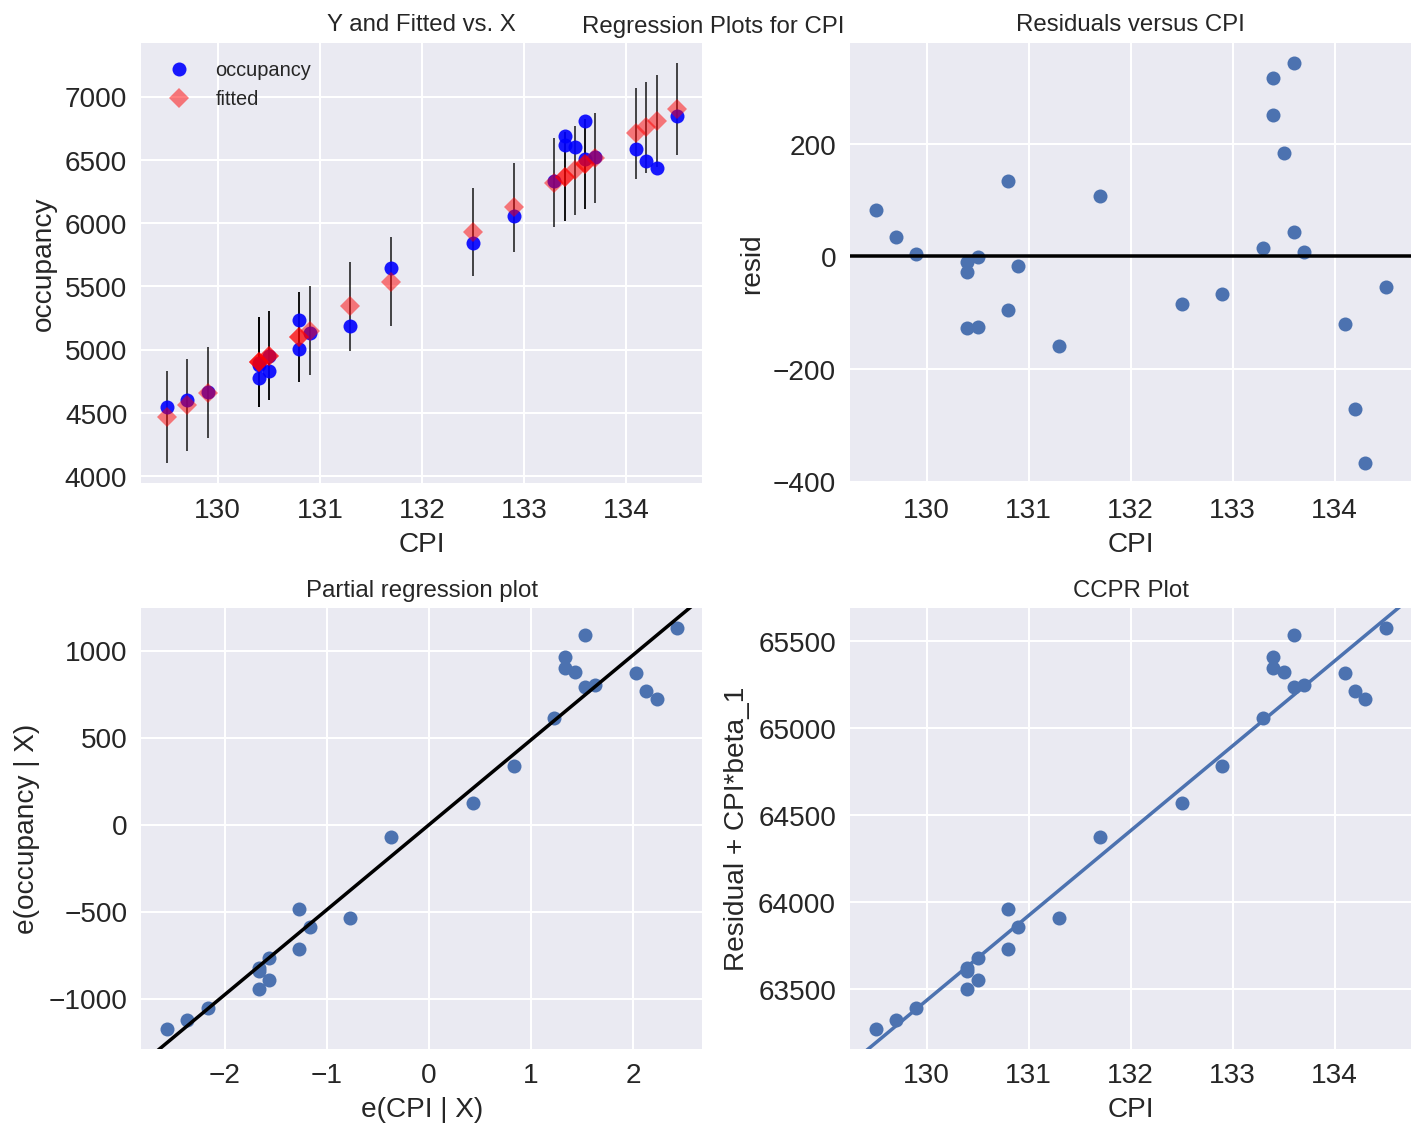

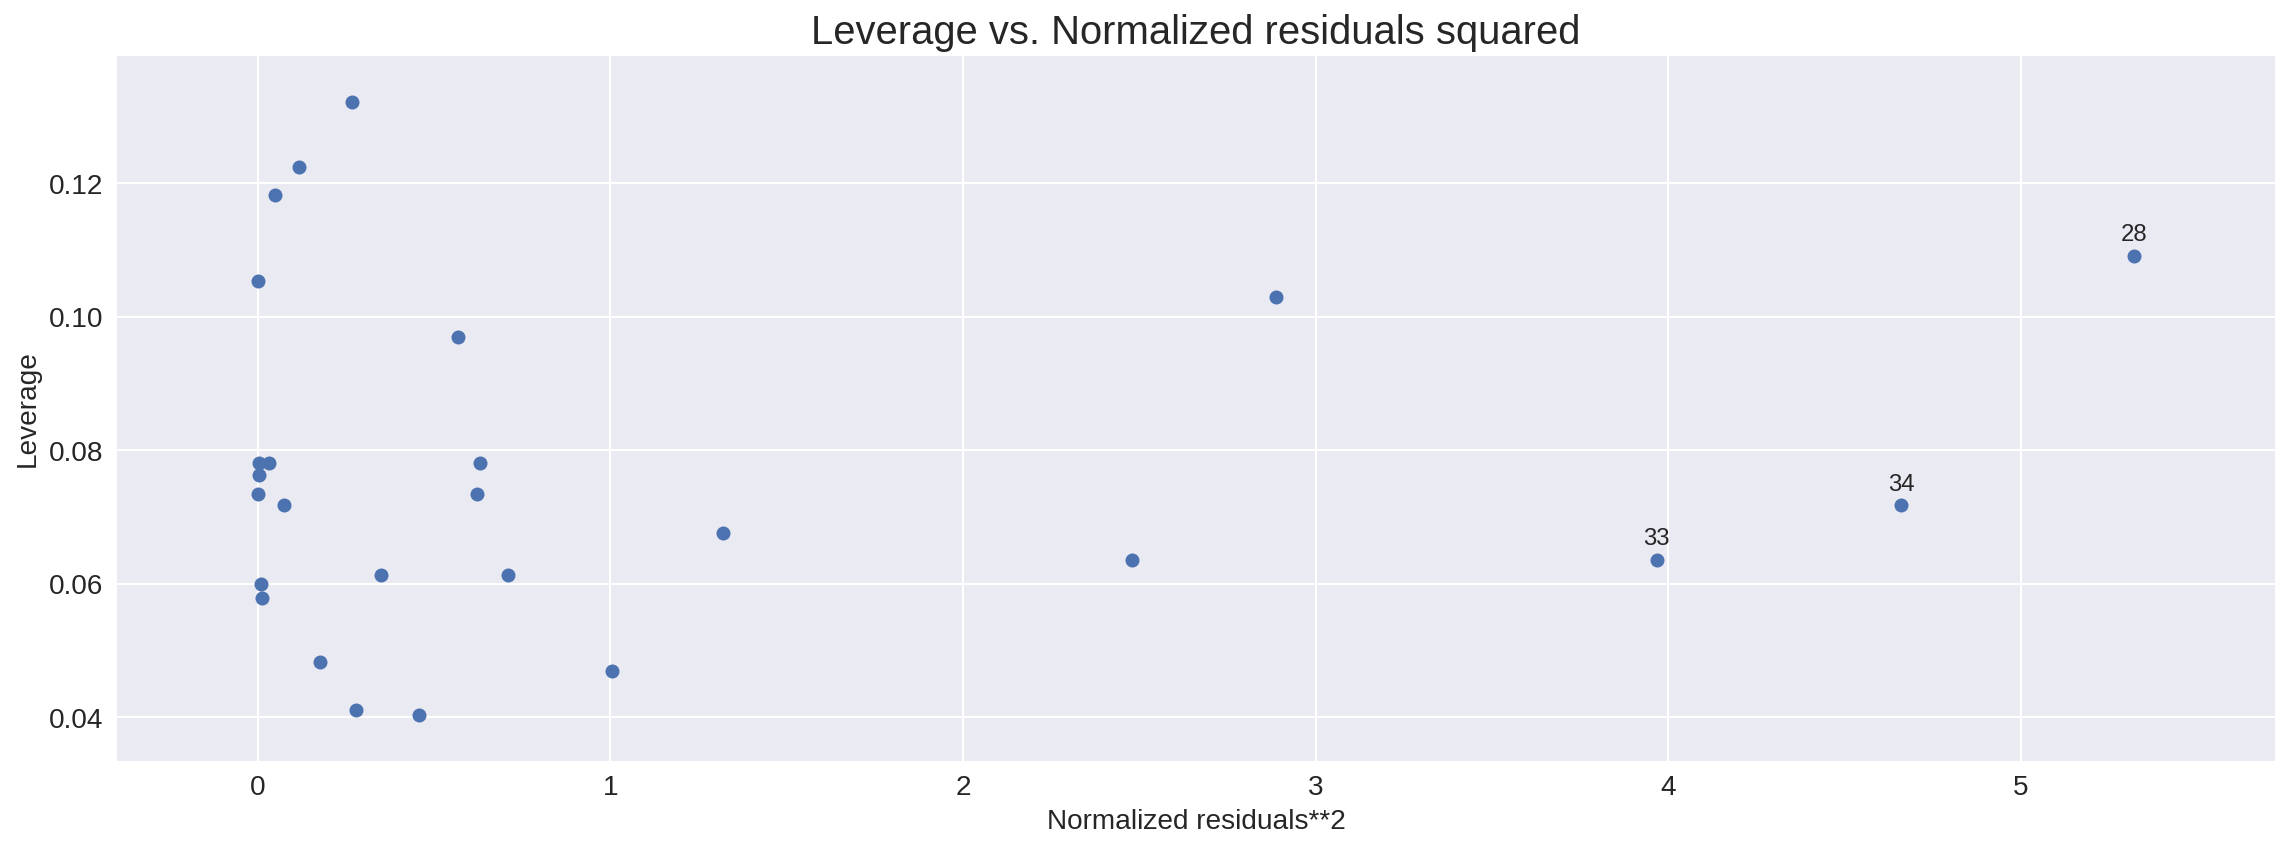

In [132]:
fig = plt.figure(figsize=(10,8))
fig = plot_regress_exog(m, "CPI", fig = fig)
fig = plot_leverage_resid2(m)

As we can see here that model is improved in terms of ad. R-squared from 0.866 to 0.961. However, we can still see some trending in residulas vs CPI plot indicationg potential outliers and/or unmodelled factors in the model.